In [2]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import tensorflow_probability as tfp
from collections import defaultdict

module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v11/"
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11'

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
BATCH_SIZE = 256
N_DATA = 4000
T = 20
VOCAB = ['start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 128

## Load Data

In [4]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
# neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path, use_init_token=False):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
        
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    
    return et_seqs, ts_seqs

raw_pos_event_type_seqs, raw_pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path, use_init_token=False)

In [5]:
# cast indicator data into one-hot
pos_event_type_seqs = tf.cast(raw_pos_event_type_seqs, tf.int32)
pos_event_type_seqs = tf.one_hot(pos_event_type_seqs, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
pos_event_type_seqs = tf.squeeze(pos_event_type_seqs, axis=3)

In [6]:
def zcore_norm(data):
    N = data.shape[0]
    
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)
    _mean = tf.repeat(_mean, N, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return (data - _mean) / _std, _mean[0,:,:], _std[0,:,:]

def zcore_norm_2(data, _mean, _std):
    N = data.shape[0]
    
    _mean = tf.expand_dims(_mean, axis=0)
    _mean = tf.repeat(_mean, N, axis=0)

    _std = tf.expand_dims(_std, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return (data - _mean) / _std, _mean[0,:,:], _std[0,:,:]

def get_mean_std(data):
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)

    return _mean, _std

def apply_mean_std(data, _mean, _std):
    N = data.shape[0]
    
    _mean = tf.reshape(_mean, (1, T, 1))
    _mean = tf.repeat(_mean, N, axis=0)
    
    _std = tf.reshape(_std, (1, T, 1))
    _std = tf.repeat(_std, N, axis=0)
    
    return data * _std + _mean

pos_timestamp_seqs, GLOBAL_MEAN, GLOBAL_STD = zcore_norm(raw_pos_timestamp_seqs)

## Global Functions

In [7]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [8]:
def generate_initial_noise(max_token=EVENT_VOCAB_DIM, time_mean=0, time_std=1, zero_time_start=True):
    init_token_noise_index = tf.random.uniform(shape=[BATCH_SIZE, 1, 1], maxval=max_token, dtype=tf.int32)
    init_token_noise = tf.squeeze(tf.one_hot(init_token_noise_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
        
    if zero_time_start:
        init_time_noise = tf.zeros([BATCH_SIZE, 1, 1], dtype=tf.float64)           
    else:
        init_time_noise = tf.random.truncated_normal(shape=[BATCH_SIZE, 1, 1], mean=time_mean, stddev=time_std, dtype=tf.float64)
        
    return init_token_noise, init_time_noise

In [9]:
from scipy.linalg import sqrtm

def calculate_FID_batch(batch1, batch2, weight=1, N=4000, T=20):
    batch1, batch2 = np.array(batch1).reshape((N, T)), np.array(batch2).reshape((N, T))
    mu1, sigma1 = batch1.mean(axis=0), np.cov(batch1, rowvar=False)
    mu2, sigma2 = batch2.mean(axis=0), np.cov(batch2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid2 = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid2

calculate_FID_score = lambda batch: calculate_FID_batch(raw_pos_timestamp_seqs, batch)
# calculate_FID_score(raw_pos_timestamp_seqs)

In [10]:
class MAD:
    """ Sum square of one-hot distance between tokens
    Params:
    -- batch1         : The first batch of sequences to be compared with the second one
                        or it can be the comparison base
    -- batch2
    Returns:
    --   : dict, sum square of distances and base medians
    """

    def __init__(self):
        self.base_ssad = []
        self.base_med = []
        self.base_med_oh = []
        self.one_hot_map = {0: [1, 0, 0, 0],
                            1: [0, 1, 0, 0],
                            2: [0, 0, 1, 0],
                            3: [0, 0, 0, 1]}

    def nan_if(self, arr, value):
        return np.where(arr == value, np.nan, arr)

    def fit(self, batch1):
        assert len(batch1) > 1, 'batch1 should have more than one sequence'
        X_tok = []
        for i in batch1:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        self.base_med = medians
        self.base_med_oh = medians_oh
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(medians_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        self.base_ssad = np.mean(tok_dist)

    def compare(self, batch2):
        assert len(batch2) > 1, 'batch2 should have more than one sequence'
        X_tok = []
        for i in batch2:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(self.base_med_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        compare_ssd = np.mean(tok_dist)
        return {'mad': compare_ssd,
                'base_medians': np.array(self.base_med),
                'base_medians_oh': np.array(self.base_med_oh),
                'comp_medians': np.array(medians),
                'comp_medians_oh': np.array(medians_oh)}
    
mad_obj = MAD()
mad_obj.fit(raw_pos_event_type_seqs)
calculate_MAD_score = lambda batch: mad_obj.compare(batch)['mad']
# calculate_MAD_score(raw_pos_event_type_seqs)

def calculate_self_MAD_score(batch):
    self_mad_obj = MAD()
    self_mad_obj.fit(batch)
    return self_mad_obj.compare(batch)['mad']

In [11]:
EVENT_TYPES = ['A', 'B', 'C', 'D']
EVENT_ENCODE = {'A':0, 'B':1, 'C':2, 'D':3}

MIN_SAME_DELAY = 20
MAX_PAIR_DELAY = 200


def check_min_delay_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]
    prev_et, _ = None, 0.0
    for et, dt in seq:
        if et == prev_et and dt < MIN_SAME_DELAY:
            return False
        prev_et = et
    return True

def check_paring_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]    
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if seq[i][0] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif seq[i][0] == EVENT_ENCODE['C'] and queue: # encounter a C event
            queue.pop(0)
    return len(queue) == 0

def check_max_delay_rule(seq, use_init_token=False):    
    if use_init_token:
        seq = seq[1:]    
        
    def recover_timedelta_to_timestamp(time_seq):
        csum = []
        curr = 0
        for dt in time_seq:
            if dt != 0:
                curr += dt
                csum.append(curr)
            else:
                csum.append(0)
        return csum
    
    ets = [e[0] for e in seq]
    tss = recover_timedelta_to_timestamp([e[1] for e in seq])
        
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if ets[i] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif ets[i] == EVENT_ENCODE['C'] and queue: # encounter a C event
            if tss[queue[0]] - tss[i] <= MAX_PAIR_DELAY:
                queue.pop(0)
            else:
                return False
    # for rule 6, it's fine if there are unpaired D in queue
    # b/c this rules is to ensure for each paired (C, D), the delay is bounded
    return True


def calculate_rule_score(batch):
    N_batch = batch.shape[0]
    cnt = 0
    for i in range(N_batch):
        seq = batch[i, :, :]
        if check_min_delay_rule(seq) and check_paring_rule(seq) and check_max_delay_rule(seq):
            cnt += 1    
    return cnt / N_batch

## Create multitype SeqGan

### 2-LSTM impl.

In [15]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_G_gs(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # inputs of Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)

    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(embed0)

    
    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(i_ts)
    
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dense_combined = Dense(hidden_dim, 
                           activation='elu',
                           name='dense_combination')(token_time_comb)
        
    token_logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_token',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
        
    time_delta_out = Dense(1,
                   activation='linear',
                   name='dense_time',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
    generator = Model(
        inputs=[i_et, i_ts],
        outputs=[token_logits, time_delta_out])
        
    return generator


def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(embed0)

    
    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(i_ts)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=prob)
    return discriminator

In [28]:
G0_mcc = build_G_gs(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G0_mcc.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
lstm_token (LSTM)               (256, 128)           74240       dense_emb[0][0]                  
____________________________________________________________________________________________

### time-lstm

In [16]:
# import tensorflow as tf
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Model
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
# from tensorflow.keras import regularizers

# from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

# tf.keras.backend.set_floatx('float64')

# def build_G_gs(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
#     # inputs of Time-LSTM:
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True,
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)    
        
#     token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
#     dense_combined = Dense(hidden_dim, 
#                            activation='elu',
#                            name='dense_combination')(token_time_comb)
        
#     token_logits = Dense(event_vocab_dim,
#                    activation='linear',
#                    name='dense_token',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
        
#     time_delta_out = Dense(1,
#                    activation='linear',
#                    name='dense_time',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
#     generator = Model(
#         inputs=[i_et, i_ts],
#         outputs=[token_logits, time_delta_out])
#     return generator


# def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
#     # normal LSTM
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=False,
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)  
    
#     token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
#     dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
#     prob = Dense(1, 
#              activation='sigmoid',
#              name='final',
#              kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
#              bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
#     discriminator = Model(
#         inputs=[i_et, i_ts],
#         outputs=prob)
#     return discriminator

## Define rollout and sequence generation

In [17]:
def sample_gumbel(shape, eps=1e-20): 
    U = tf.random.uniform(shape,minval=0,maxval=1)   #gumbel noise
#     print('noise:{}'.format(U))
    return -tf.math.log(-tf.math.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature=0.5): 
    y = logits + tf.cast(sample_gumbel(tf.shape(logits)), logits.dtype)
    return tf.nn.softmax( y / temperature)  # use softmax to approximate argmax

def gumbel_softmax(logits, temperature=0.5, hard=True):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    logits = tf.cast(logits, tf.float64)
    y = gumbel_softmax_sample(logits, temperature) # this is differentiable
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keepdims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y


In [29]:
def rollout_from_initial_gumbel(G, batch_size, init_et, init_ts, L=T, temperature=0.5, use_tlstm=False):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = init_et
    all_state_ts = init_ts
    
    l_prefix = init_et.shape[1]
    
    G.reset_states()
    
    if use_tlstm:
        # Time-LSTM
        G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
        G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    else:
        # LSTM-token
        G.layers[3].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
        G.layers[3].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
        # LSTM-time
        G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
        G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))

    for _ in range(L + 1 - l_prefix):  # sequence length
        curr_state_et = all_state_et[:, -1:, :]
        curr_state_ts = all_state_ts[:, -1:, :]
        
        # add step noise to token and time inputs
#         curr_state_et = tf.cast(tf.where(curr_state_et == 1, 0.9, 0.1/3), tf.float64)
#         curr_state_ts = curr_state_ts + tf.random.normal(shape=tf.shape(curr_state_ts), mean=0.0, stddev=1, dtype=tf.float64)

        token_logits, time_delta_out = G([curr_state_et, curr_state_ts])
        
        # sample event types using Gumbel-softmax
        sampled_et = gumbel_softmax(token_logits, temperature)  # this is differentiable
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, EVENT_VOCAB_DIM])        
        sampled_et = tf.cast(sampled_et, dtype=tf.float64) # cast sampled_et into float
        
        time_delta_out = tf.reshape(time_delta_out, [batch_size, 1, 1]) 
        
        # Do NOT stop genererating once hit end_token; G is supposed to learn it.
        all_state_et = tf.concat([all_state_et, sampled_et], axis=1)
        all_state_ts = tf.concat([all_state_ts, time_delta_out], axis=1)

    # the initlal random states are excluded in output
    return all_state_et[:, 1:, :], all_state_ts[:, 1:, :]


def generate_sequences_gumbel(N_gen, generator, batch_size, T, temperature=0.5, use_tlstm=False):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    all_time_seq = None
    
    init_token_noise, init_time_noise = generate_initial_noise(zero_time_start=False)
        
    while N < N_gen:
        batch_state_et, batch_state_ts = rollout_from_initial_gumbel(generator, batch_size, init_token_noise, init_time_noise, T, temperature, use_tlstm)

        if all_type_seq is None or all_time_seq is None:
            all_type_seq = batch_state_et
            all_time_seq = batch_state_ts
        else:
            all_type_seq = tf.concat([all_type_seq, batch_state_et], axis=0)
            all_time_seq = tf.concat([all_time_seq, batch_state_ts], axis=0)

        N += batch_size

    all_type_seq = all_type_seq[:N_gen, :, :]
    all_time_seq = all_time_seq[:N_gen, :, :]

    return all_type_seq, all_time_seq

In [30]:
def get_generation_metrics(G):
    _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(N_DATA, G, BATCH_SIZE, T)

    # convert one-hot event types to indices; convert normalized timestamps to original
    _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
    _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
    _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))    

    _mad_score = calculate_MAD_score(_gen_seqs_et_ind)
    _smad_score = calculate_self_MAD_score(_gen_seqs_et_ind)
    _fid_score = calculate_FID_score(_gen_seqs_ts_ori)
    _rule_score = calculate_rule_score(_gen_seqs_for_rules)
    
    return {'mad' : _mad_score, 'fid' : _fid_score, 'oracle' : _rule_score, 'smad' : _smad_score}

In [31]:
def track_training(step, G, save_path=None, verbose=True, plot=True, save_G=True, save_D=True):
    _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(N_DATA, G, BATCH_SIZE, T)
    
    # convert one-hot event types to indices; convert normalized timestamps to original
    _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
    _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
    _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))
    
    _mad_score = calculate_MAD_score(_gen_seqs_et_ind)
    _fid_score = calculate_FID_score(_gen_seqs_ts_ori)
    _rule_score = calculate_rule_score(_gen_seqs_for_rules)

    if verbose:
        print('event_types:', _gen_seqs_et_ind[0,:, :].squeeze().tolist())
        print('mad_score:', _mad_score)
        print('fid_score:', _fid_score)
        print('rule_score:', _rule_score)

    if plot:
        plt.figure()
        x = np.arange(_gen_seqs_et[0,:,:].shape[0])
        y = _gen_seqs_ts[0,:,:]
        plt.plot(x, y)
        plt.title(f'wave shape after {step} steps')
        plt.show()

    if save_path and save_G:
        G_save_path = os.path.join(save_path, f'G_{step}', 'model_weights.tf')
        G.save_weights(G_save_path)
        print('G saved to:', G_save_path)
        
    if save_path and save_D:
        D_save_path = os.path.join(save_path, f'D_{step}', 'model_weights.tf')
        D.save_weights(D_save_path)
        print('D saved to:', D_save_path)
        
    return _mad_score, _fid_score, _rule_score

## Pre-Training using MLE

In [32]:
def pretrain_discriminator(event_type_batch, time_delta_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator([event_type_batch, time_delta_batch])

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, time_delta_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape
    
    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        step_token_ce_loss_list = []
        step_time_mxe_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            curr_state_ts = time_delta_batch[:, i:i + 1, :]
            
            target_et = event_type_batch[:, i + 1, :]
            target_ts = time_delta_batch[:, i + 1, :]            
            
            token_logits, time_delta_out = generator([curr_state_et, curr_state_ts])

            token_ce_losses = tf.keras.losses.categorical_crossentropy(target_et, token_logits, from_logits=True)
            token_ce_loss = tf.reduce_mean(token_ce_losses)
            step_token_ce_loss_list.append(token_ce_loss)
            
            time_mxe_losses = tf.keras.losses.MAE(target_ts, time_delta_out)
            time_mxe_loss = tf.reduce_mean(time_mxe_losses)
            step_time_mxe_loss_list.append(time_mxe_loss)                        
    
        episode_token_ce_loss = tf.reduce_mean(step_token_ce_loss_list)
        episode_time_mxe_loss = tf.reduce_mean(step_time_mxe_loss_list)
        generator_loss = episode_token_ce_loss + episode_time_mxe_loss

    if verbose:
        print('token ce loss:{}'.format(episode_token_ce_loss))
        print('time mae loss:{}'.format(episode_time_mxe_loss))
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss, episode_token_ce_loss, episode_time_mxe_loss

## Pre-training

In [33]:
now_str = datetime.strftime(datetime.now(), format='%Y-%m-%d-%H-%M-%S')
pretrain_model_save_path = os.path.join(model_save_dir, 'pretrain', now_str)

print(pretrain_model_save_path)
pretrain_history = defaultdict(list)

/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10


### pre-train G

In [34]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 3
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)

In [35]:
pretrained_generator = build_G_gs(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

# init_G_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-09-16-18/G_0/model_weights.tf'
# pretrained_generator.build(input_shape=((BATCH_SIZE, T, 1)))
# pretrained_generator.load_weights(init_G_save_path)

get_generation_metrics(pretrained_generator)

{'mad': 0.7777875,
 'fid': 11012.448003532245,
 'oracle': 0.176,
 'smad': 0.7777875}

In [36]:
step = 0
OPTIMIZER = Adam(lr=1e-4)

  0%|          | 0/46 [00:00<?, ?it/s]

Training Step: 0
event_types: [1, 0, 2, 3, 0, 1, 2, 3, 1, 2, 0, 1, 1, 0, 0, 1, 3, 2, 1, 0]
mad_score: 0.77935
fid_score: 11024.66250776927
rule_score: 0.1655


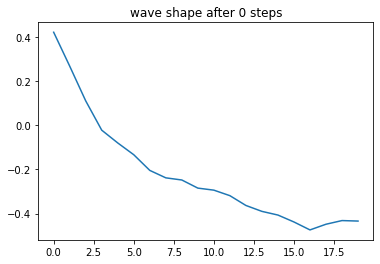

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_0/model_weights.tf
token ce loss:1.4289300218723229
time mae loss:0.7902533172308526
train loss:2.2191833391031754


  2%|▏         | 1/46 [00:19<14:22, 19.16s/it]

Training Step: 1
event_types: [0, 0, 1, 0, 0, 2, 3, 3, 2, 0, 3, 3, 3, 0, 2, 1, 0, 3, 1, 3]
mad_score: 0.7697
fid_score: 10939.982790755012
rule_score: 0.1855


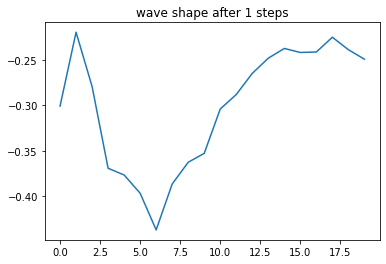

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_1/model_weights.tf
token ce loss:1.4186665159040914
time mae loss:0.7873391980634226
train loss:2.2060057139675138


  4%|▍         | 2/46 [00:38<13:58, 19.05s/it]

Training Step: 2
event_types: [2, 2, 0, 1, 3, 2, 1, 1, 3, 3, 3, 0, 1, 3, 2, 1, 3, 3, 2, 1]
mad_score: 0.7673
fid_score: 10874.042898759779
rule_score: 0.18225


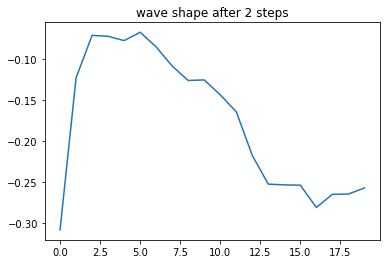

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_2/model_weights.tf
token ce loss:1.4088082872276764
time mae loss:0.7747667005011307
train loss:2.1835749877288073


  7%|▋         | 3/46 [00:57<13:40, 19.08s/it]

Training Step: 3
event_types: [0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 3, 1, 1, 3, 0, 2, 0]
mad_score: 0.76125
fid_score: 10816.102358998374
rule_score: 0.19


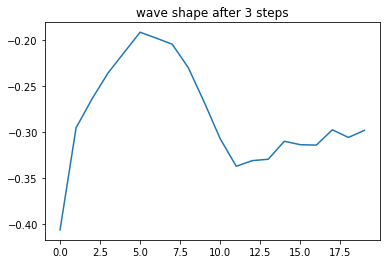

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_3/model_weights.tf
token ce loss:1.4070633692065644
time mae loss:0.8007538138007945
train loss:2.207817183007359


  9%|▊         | 4/46 [01:16<13:21, 19.08s/it]

Training Step: 4
event_types: [1, 0, 0, 0, 1, 2, 0, 1, 3, 3, 0, 0, 1, 0, 1, 3, 1, 1, 3, 0]
mad_score: 0.7524
fid_score: 10766.39469695394
rule_score: 0.209


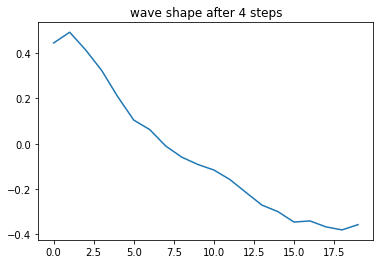

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_4/model_weights.tf
token ce loss:1.398972697721174
time mae loss:0.7694575350524856
train loss:2.1684302327736598


 11%|█         | 5/46 [01:35<13:01, 19.05s/it]

Training Step: 5
event_types: [2, 1, 1, 1, 2, 1, 3, 0, 2, 0, 2, 2, 1, 1, 0, 1, 3, 3, 1, 2]
mad_score: 0.7505625
fid_score: 10730.323019863357
rule_score: 0.203


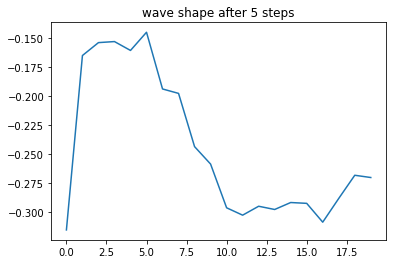

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_5/model_weights.tf
token ce loss:1.392007529425825
time mae loss:0.7920017015513409
train loss:2.184009230977166


 13%|█▎        | 6/46 [01:52<12:20, 18.51s/it]

Training Step: 6
event_types: [2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 2, 3, 2, 0, 3, 0, 3]
mad_score: 0.7424
fid_score: 10709.461970706752
rule_score: 0.2095


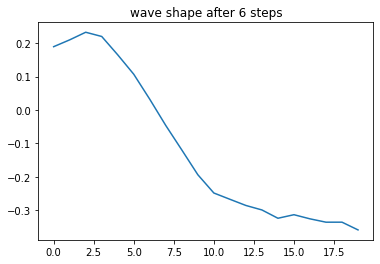

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_6/model_weights.tf
token ce loss:1.3849942883569453
time mae loss:0.7841851964862446
train loss:2.16917948484319


 15%|█▌        | 7/46 [02:07<11:13, 17.27s/it]

Training Step: 7
event_types: [3, 2, 1, 1, 1, 3, 0, 3, 1, 2, 0, 1, 2, 0, 2, 0, 1, 3, 0, 2]
mad_score: 0.73305
fid_score: 10674.105571484633
rule_score: 0.224


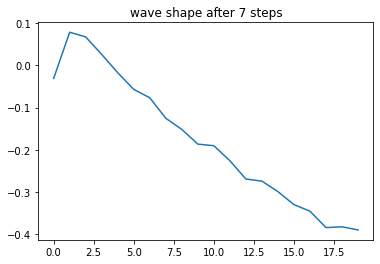

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_7/model_weights.tf
token ce loss:1.3813730547415097
time mae loss:0.7904636709833739
train loss:2.1718367257248836


 17%|█▋        | 8/46 [02:26<11:14, 17.75s/it]

Training Step: 8
event_types: [3, 2, 2, 2, 0, 3, 0, 0, 2, 2, 0, 1, 2, 1, 1, 0, 1, 1, 0, 3]
mad_score: 0.7296875
fid_score: 10675.572971707257
rule_score: 0.23425


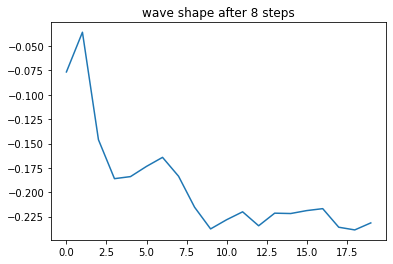

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_8/model_weights.tf
token ce loss:1.3770236276748467
time mae loss:0.7697540580249016
train loss:2.1467776856997483


 20%|█▉        | 9/46 [02:45<11:09, 18.09s/it]

Training Step: 9
event_types: [1, 1, 2, 0, 2, 3, 0, 0, 0, 2, 0, 0, 3, 2, 3, 2, 3, 2, 0, 2]
mad_score: 0.721975
fid_score: 10649.00372196539
rule_score: 0.24325


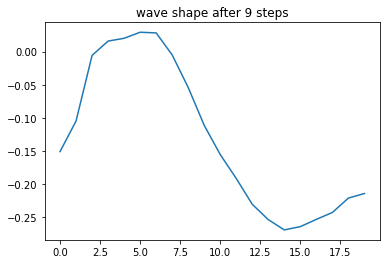

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_9/model_weights.tf
token ce loss:1.3709232402092089
time mae loss:0.7999647738755852
train loss:2.170888014084794


 22%|██▏       | 10/46 [03:04<11:04, 18.46s/it]

Training Step: 10
event_types: [2, 0, 3, 3, 3, 2, 3, 3, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 1]
mad_score: 0.71895
fid_score: 10637.946596947188
rule_score: 0.25875


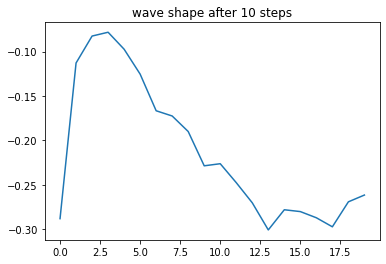

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_10/model_weights.tf
token ce loss:1.3661999936364264
time mae loss:0.7805580202804285
train loss:2.146758013916855


 24%|██▍       | 11/46 [03:23<10:50, 18.60s/it]

Training Step: 11
event_types: [0, 2, 1, 2, 2, 0, 2, 0, 2, 1, 2, 1, 2, 2, 0, 2, 1, 1, 3, 1]
mad_score: 0.7122625
fid_score: 10648.933285464695
rule_score: 0.26


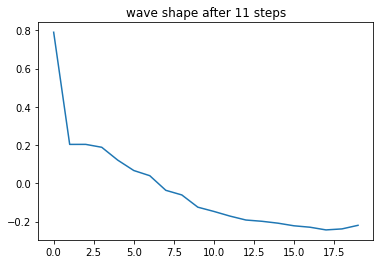

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_11/model_weights.tf
token ce loss:1.3640004262551009
time mae loss:0.7861525757394668
train loss:2.1501530019945676


 26%|██▌       | 12/46 [03:42<10:36, 18.71s/it]

Training Step: 12
event_types: [0, 3, 1, 0, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 0, 0, 1, 2, 1, 1]
mad_score: 0.707675
fid_score: 10644.83672364601
rule_score: 0.2595


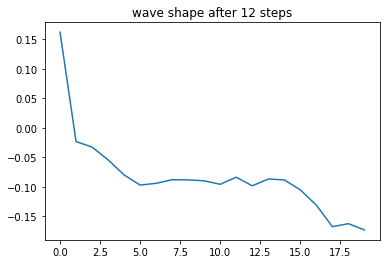

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_12/model_weights.tf
token ce loss:1.3587507445735696
time mae loss:0.7853397063891014
train loss:2.144090450962671


 28%|██▊       | 13/46 [04:01<10:19, 18.77s/it]

Training Step: 13
event_types: [3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 0, 1, 2, 1, 0, 3, 1]
mad_score: 0.7005125
fid_score: 10638.037891362277
rule_score: 0.28025


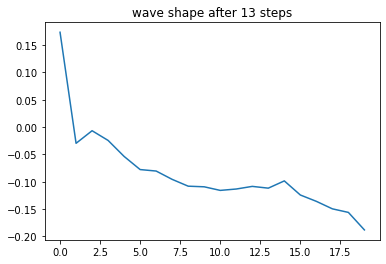

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_13/model_weights.tf
token ce loss:1.358154795729994
time mae loss:0.7887417821985675
train loss:2.1468965779285614


 30%|███       | 14/46 [04:18<09:48, 18.39s/it]

Training Step: 14
event_types: [1, 0, 3, 2, 2, 2, 0, 0, 2, 2, 1, 0, 3, 3, 3, 1, 0, 2, 1, 3]
mad_score: 0.6961375
fid_score: 10636.036494404445
rule_score: 0.278


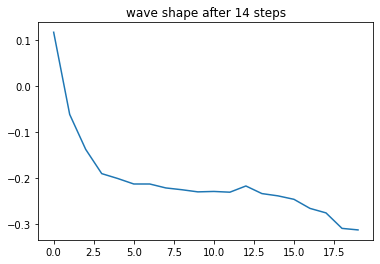

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_14/model_weights.tf
token ce loss:1.3543512150952253
time mae loss:0.7965165310884312
train loss:2.1508677461836565


 33%|███▎      | 15/46 [04:35<09:19, 18.04s/it]

Training Step: 15
event_types: [0, 0, 1, 1, 0, 2, 3, 1, 0, 3, 1, 2, 0, 0, 2, 3, 1, 2, 2, 3]
mad_score: 0.68935
fid_score: 10635.600818331894
rule_score: 0.2845


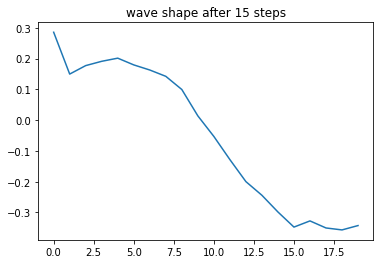

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_15/model_weights.tf
token ce loss:1.3496023694264543
time mae loss:0.7795473201093209
train loss:2.129149689535775


 35%|███▍      | 16/46 [04:54<09:10, 18.34s/it]

Training Step: 16
event_types: [1, 1, 1, 3, 1, 2, 0, 1, 2, 1, 2, 3, 0, 3, 2, 2, 3, 1, 1, 2]
mad_score: 0.680875
fid_score: 10638.125354352938
rule_score: 0.31075


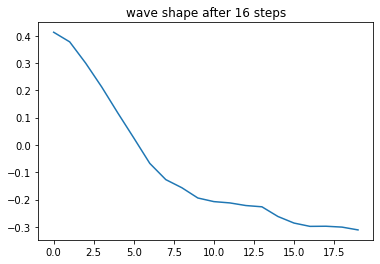

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_16/model_weights.tf
token ce loss:1.35214563125133
time mae loss:0.7874892381830836
train loss:2.1396348694344134


 37%|███▋      | 17/46 [05:14<08:58, 18.55s/it]

Training Step: 17
event_types: [0, 0, 1, 3, 1, 3, 1, 2, 2, 2, 0, 0, 0, 2, 0, 3, 1, 1, 2, 3]
mad_score: 0.675825
fid_score: 10639.41925722337
rule_score: 0.309


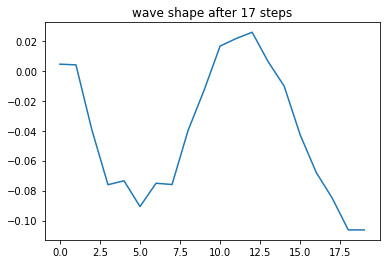

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_17/model_weights.tf
token ce loss:1.346667790582563
time mae loss:0.7835133474968171
train loss:2.1301811380793803


 39%|███▉      | 18/46 [05:32<08:42, 18.68s/it]

Training Step: 18
event_types: [2, 1, 3, 0, 0, 1, 1, 2, 2, 2, 1, 3, 0, 0, 1, 0, 2, 3, 0, 2]
mad_score: 0.675425
fid_score: 10632.25404263683
rule_score: 0.3055


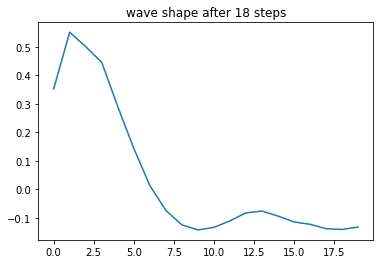

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_18/model_weights.tf
token ce loss:1.3462366869329863
time mae loss:0.7786884027407738
train loss:2.12492508967376


 41%|████▏     | 19/46 [05:51<08:25, 18.73s/it]

Training Step: 19
event_types: [1, 0, 3, 1, 2, 2, 3, 1, 0, 0, 2, 1, 1, 2, 3, 0, 1, 2, 1, 0]
mad_score: 0.6669
fid_score: 10623.548783898888
rule_score: 0.3105


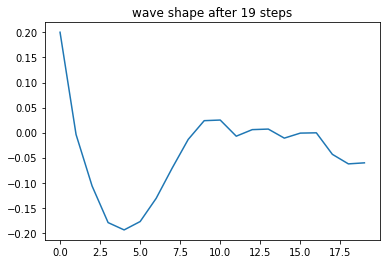

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_19/model_weights.tf
token ce loss:1.3477990748174495
time mae loss:0.7894667445537373
train loss:2.137265819371187


 43%|████▎     | 20/46 [06:10<08:09, 18.84s/it]

Training Step: 20
event_types: [1, 1, 2, 2, 1, 3, 0, 3, 1, 1, 1, 3, 2, 1, 0, 2, 2, 2, 1, 0]
mad_score: 0.663425
fid_score: 10626.626147138735
rule_score: 0.33125


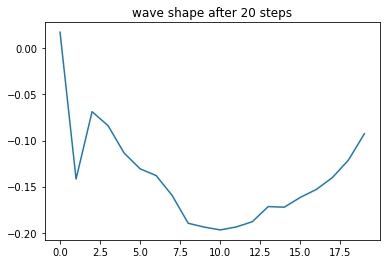

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_20/model_weights.tf
token ce loss:1.344553312766894
time mae loss:0.7868288347982141
train loss:2.131382147565108


 46%|████▌     | 21/46 [06:29<07:50, 18.84s/it]

Training Step: 21
event_types: [2, 2, 0, 3, 3, 1, 3, 2, 3, 2, 1, 0, 2, 1, 2, 1, 2, 2, 2, 1]
mad_score: 0.6618
fid_score: 10638.530463423052
rule_score: 0.31925


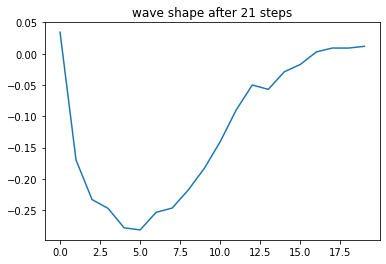

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_21/model_weights.tf
token ce loss:1.3448267497587887
time mae loss:0.7847846503768221
train loss:2.1296114001356106


 48%|████▊     | 22/46 [06:48<07:30, 18.77s/it]

Training Step: 22
event_types: [2, 2, 1, 2, 3, 3, 0, 3, 2, 0, 0, 0, 2, 3, 2, 1, 3, 2, 2, 1]
mad_score: 0.653675
fid_score: 10634.46454239684
rule_score: 0.33275


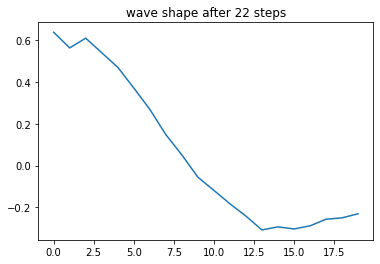

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_22/model_weights.tf
token ce loss:1.3461385250836553
time mae loss:0.7791540110151904
train loss:2.1252925360988457


 50%|█████     | 23/46 [07:05<07:01, 18.32s/it]

Training Step: 23
event_types: [0, 3, 2, 1, 1, 1, 0, 1, 1, 1, 3, 0, 2, 3, 2, 0, 3, 0, 2, 3]
mad_score: 0.65115
fid_score: 10636.082051869049
rule_score: 0.353


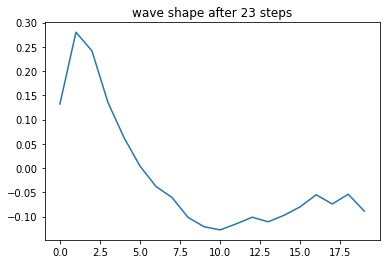

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_23/model_weights.tf
token ce loss:1.3468935560514426
time mae loss:0.7823533411384884
train loss:2.129246897189931


 52%|█████▏    | 24/46 [07:24<06:47, 18.54s/it]

Training Step: 24
event_types: [3, 3, 3, 1, 3, 0, 3, 0, 0, 2, 3, 1, 1, 3, 2, 0, 0, 3, 2, 2]
mad_score: 0.6485875
fid_score: 10631.813268196527
rule_score: 0.35775


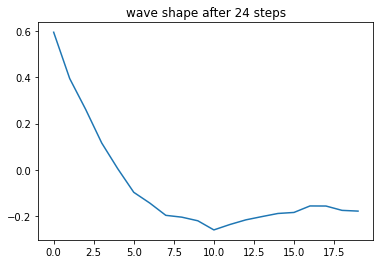

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_24/model_weights.tf
token ce loss:1.3383085588691173
time mae loss:0.7825867452598089
train loss:2.120895304128926


 54%|█████▍    | 25/46 [07:43<06:33, 18.72s/it]

Training Step: 25
event_types: [2, 3, 1, 0, 2, 1, 0, 2, 2, 3, 0, 2, 2, 2, 1, 3, 2, 2, 2, 2]
mad_score: 0.64465
fid_score: 10634.500749917497
rule_score: 0.35275


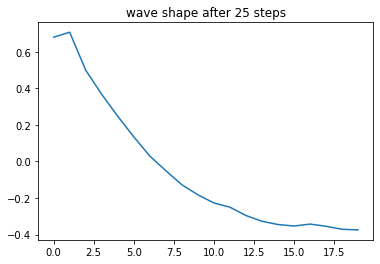

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_25/model_weights.tf
token ce loss:1.3432214497501604
time mae loss:0.7858308629313665
train loss:2.129052312681527


 57%|█████▋    | 26/46 [08:02<06:16, 18.85s/it]

Training Step: 26
event_types: [3, 3, 1, 3, 2, 0, 2, 2, 1, 2, 1, 2, 0, 0, 2, 0, 1, 2, 2, 0]
mad_score: 0.6415875
fid_score: 10642.911247987196
rule_score: 0.359


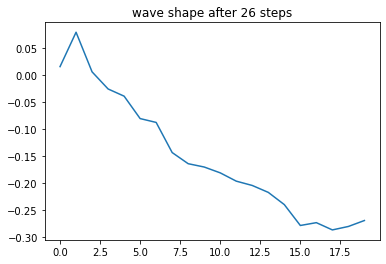

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_26/model_weights.tf
token ce loss:1.3452163193651947
time mae loss:0.7865509314752123
train loss:2.131767250840407


 59%|█████▊    | 27/46 [08:21<05:58, 18.86s/it]

Training Step: 27
event_types: [2, 1, 0, 0, 2, 2, 1, 0, 0, 1, 2, 2, 2, 0, 2, 1, 2, 1, 3, 3]
mad_score: 0.6405875
fid_score: 10634.532570717454
rule_score: 0.36275


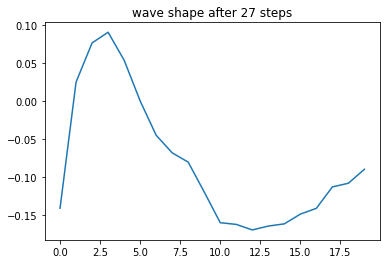

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_27/model_weights.tf
token ce loss:1.3382868139538413
time mae loss:0.7763192376470734
train loss:2.114606051600915


 61%|██████    | 28/46 [08:40<05:39, 18.88s/it]

Training Step: 28
event_types: [3, 3, 0, 1, 0, 0, 0, 3, 1, 2, 2, 2, 3, 2, 3, 2, 0, 2, 1, 3]
mad_score: 0.6398125
fid_score: 10621.633883252354
rule_score: 0.37225


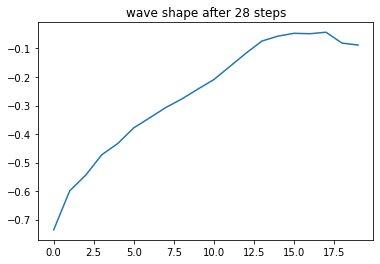

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_28/model_weights.tf
token ce loss:1.3355635095575833
time mae loss:0.7799344665547231
train loss:2.1154979761123065


 63%|██████▎   | 29/46 [08:59<05:22, 18.97s/it]

Training Step: 29
event_types: [3, 3, 0, 3, 3, 2, 1, 2, 3, 0, 1, 1, 1, 2, 0, 2, 2, 2, 2, 0]
mad_score: 0.6385375
fid_score: 10604.85792891391
rule_score: 0.37


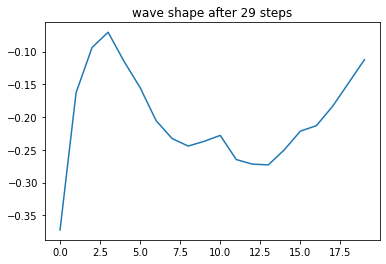

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_29/model_weights.tf
token ce loss:1.3410158979250355
time mae loss:0.7847456156299563
train loss:2.1257615135549917


 65%|██████▌   | 30/46 [09:18<04:59, 18.73s/it]

Training Step: 30
event_types: [2, 3, 2, 1, 1, 0, 1, 0, 2, 0, 2, 2, 2, 1, 0, 2, 1, 1, 1, 2]
mad_score: 0.635875
fid_score: 10594.929754219098
rule_score: 0.36975


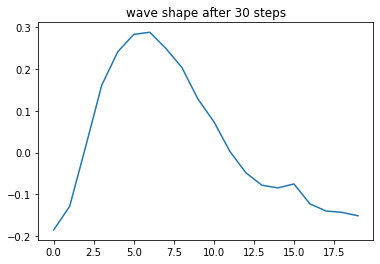

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_30/model_weights.tf
token ce loss:1.3407888946093602
time mae loss:0.7925199761993846
train loss:2.1333088708087447


 67%|██████▋   | 31/46 [09:35<04:35, 18.34s/it]

Training Step: 31
event_types: [0, 0, 0, 0, 3, 2, 2, 2, 2, 3, 1, 3, 0, 2, 2, 2, 0, 2, 1, 0]
mad_score: 0.635425
fid_score: 10564.490133340298
rule_score: 0.36425


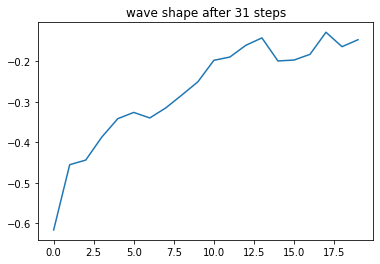

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_31/model_weights.tf
token ce loss:1.338816902829116
time mae loss:0.7833266054573848
train loss:2.122143508286501


 70%|██████▉   | 32/46 [09:54<04:19, 18.52s/it]

Training Step: 32
event_types: [0, 3, 3, 2, 1, 1, 1, 2, 3, 3, 1, 2, 0, 3, 2, 2, 2, 1, 2, 3]
mad_score: 0.63425
fid_score: 10560.344797687883
rule_score: 0.3765


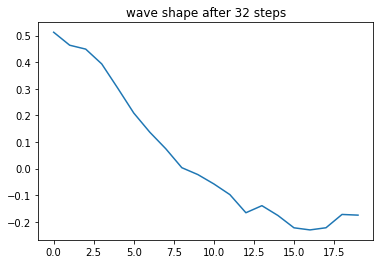

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_32/model_weights.tf
token ce loss:1.3443956945284719
time mae loss:0.7849758009118375
train loss:2.129371495440309


 72%|███████▏  | 33/46 [10:13<04:02, 18.68s/it]

Training Step: 33
event_types: [2, 0, 3, 3, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 2, 1, 2]
mad_score: 0.6332875
fid_score: 10535.410815417
rule_score: 0.367


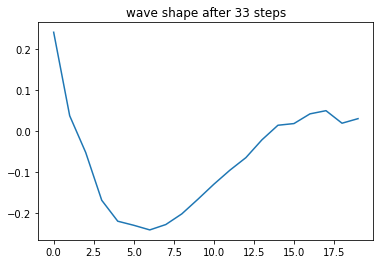

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_33/model_weights.tf
token ce loss:1.3384783605780297
time mae loss:0.7827273388590529
train loss:2.1212056994370827


 74%|███████▍  | 34/46 [10:32<03:45, 18.78s/it]

Training Step: 34
event_types: [2, 2, 2, 3, 3, 2, 0, 3, 1, 3, 2, 2, 2, 0, 2, 2, 2, 3, 1, 1]
mad_score: 0.6395375
fid_score: 10528.947621675243
rule_score: 0.3645


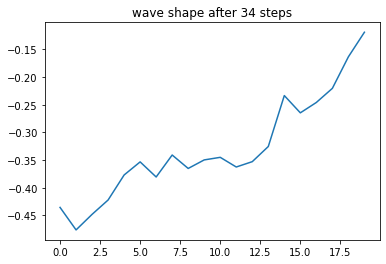

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_34/model_weights.tf
token ce loss:1.3378007277335946
time mae loss:0.7756015271649087
train loss:2.1134022548985034


 76%|███████▌  | 35/46 [10:51<03:27, 18.91s/it]

Training Step: 35
event_types: [2, 1, 1, 3, 1, 3, 1, 1, 1, 2, 2, 1, 0, 1, 2, 0, 1, 2, 1, 1]
mad_score: 0.6359625
fid_score: 10525.169873010338
rule_score: 0.36675


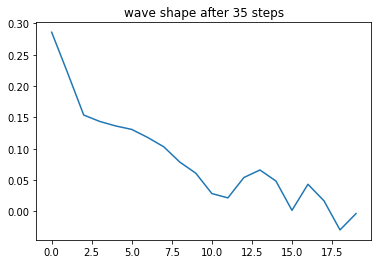

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_35/model_weights.tf
token ce loss:1.3401430485113834
time mae loss:0.7838945885578489
train loss:2.1240376370692324


 78%|███████▊  | 36/46 [11:10<03:09, 18.96s/it]

Training Step: 36
event_types: [1, 3, 0, 2, 1, 3, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 1, 0, 2, 0]
mad_score: 0.6381
fid_score: 10497.78267081939
rule_score: 0.37725


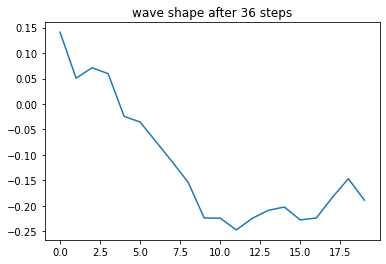

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_36/model_weights.tf
token ce loss:1.33691705600344
time mae loss:0.7787043603021977
train loss:2.115621416305638


 80%|████████  | 37/46 [11:30<02:51, 19.03s/it]

Training Step: 37
event_types: [1, 0, 2, 2, 1, 2, 1, 3, 1, 1, 1, 3, 1, 1, 2, 2, 1, 1, 1, 2]
mad_score: 0.6378125
fid_score: 10501.247587092263
rule_score: 0.3665


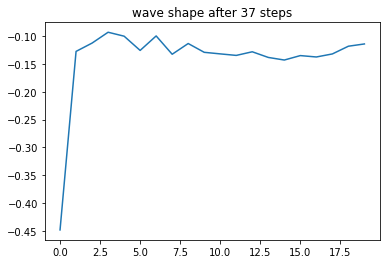

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_37/model_weights.tf
token ce loss:1.3433966733216678
time mae loss:0.7926572505326126
train loss:2.1360539238542806


 83%|████████▎ | 38/46 [11:48<02:30, 18.76s/it]

Training Step: 38
event_types: [2, 0, 1, 1, 0, 2, 0, 3, 1, 2, 2, 2, 1, 3, 2, 0, 3, 1, 1, 0]
mad_score: 0.6381
fid_score: 10494.576723803582
rule_score: 0.35725


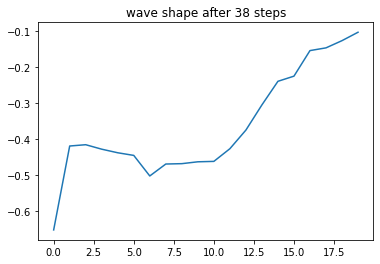

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_38/model_weights.tf
token ce loss:1.3389029354824782
time mae loss:0.7827073188720253
train loss:2.1216102543545032


 85%|████████▍ | 39/46 [12:05<02:08, 18.38s/it]

Training Step: 39
event_types: [0, 1, 1, 3, 0, 3, 2, 1, 3, 2, 0, 2, 2, 3, 1, 1, 2, 3, 0, 0]
mad_score: 0.63595
fid_score: 10483.677893388158
rule_score: 0.386


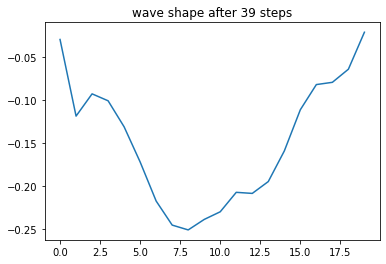

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_39/model_weights.tf
token ce loss:1.3341766358169682
time mae loss:0.7783642264884181
train loss:2.1125408623053863


 87%|████████▋ | 40/46 [12:24<01:51, 18.58s/it]

Training Step: 40
event_types: [2, 0, 2, 2, 3, 3, 1, 2, 2, 1, 0, 3, 1, 2, 1, 1, 1, 2, 2, 2]
mad_score: 0.6363875
fid_score: 10489.141995282567
rule_score: 0.3765


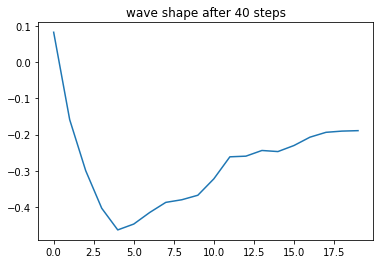

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_40/model_weights.tf
token ce loss:1.3367269707989795
time mae loss:0.7851759209374017
train loss:2.121902891736381


 89%|████████▉ | 41/46 [12:43<01:33, 18.71s/it]

Training Step: 41
event_types: [2, 0, 0, 1, 2, 3, 3, 3, 3, 2, 3, 2, 0, 2, 1, 3, 1, 0, 1, 0]
mad_score: 0.6363375
fid_score: 10486.050287900716
rule_score: 0.3865


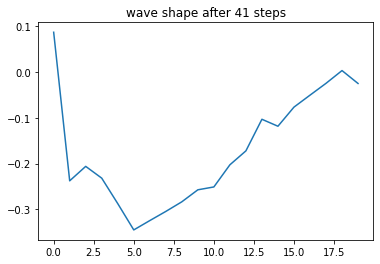

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_41/model_weights.tf
token ce loss:1.332087007863362
time mae loss:0.7767034359286736
train loss:2.1087904437920355


 91%|█████████▏| 42/46 [13:03<01:15, 18.90s/it]

Training Step: 42
event_types: [2, 2, 1, 3, 0, 2, 1, 2, 1, 3, 1, 2, 2, 3, 1, 2, 2, 0, 1, 0]
mad_score: 0.6395875
fid_score: 10480.178290723721
rule_score: 0.385


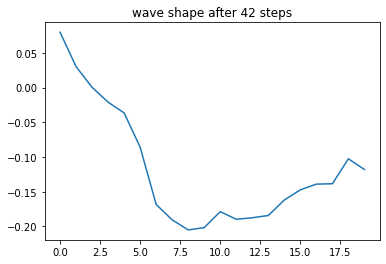

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_42/model_weights.tf
token ce loss:1.3396889356888892
time mae loss:0.779677179359892
train loss:2.1193661150487815


 93%|█████████▎| 43/46 [13:22<00:56, 18.96s/it]

Training Step: 43
event_types: [1, 3, 1, 2, 1, 0, 1, 2, 0, 0, 2, 2, 2, 2, 2, 0, 1, 2, 1, 1]
mad_score: 0.6365875
fid_score: 10499.463391187028
rule_score: 0.38


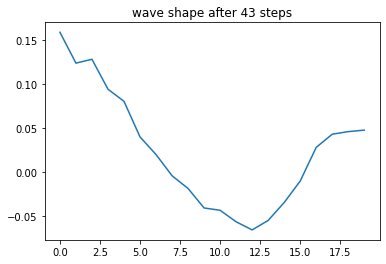

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_43/model_weights.tf
token ce loss:1.3342306340894112
time mae loss:0.7785973093630565
train loss:2.1128279434524675


 96%|█████████▌| 44/46 [13:41<00:38, 19.03s/it]

Training Step: 44
event_types: [1, 3, 1, 2, 0, 2, 1, 1, 3, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 3]
mad_score: 0.63655
fid_score: 10507.194855482578
rule_score: 0.3855


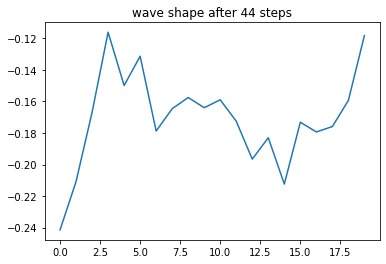

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_44/model_weights.tf
token ce loss:1.3361724152271037
time mae loss:0.7736943552107854
train loss:2.1098667704378893


 98%|█████████▊| 45/46 [14:00<00:19, 19.04s/it]

Training Step: 45
event_types: [0, 3, 2, 1, 3, 3, 3, 3, 1, 1, 2, 2, 3, 2, 0, 0, 2, 1, 2, 3]
mad_score: 0.6381
fid_score: 10497.927312906655
rule_score: 0.362


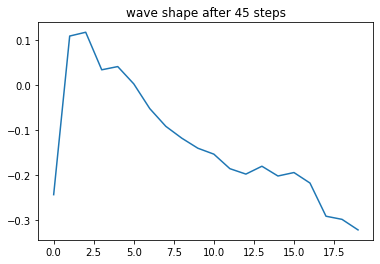

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-23-30-10/G_45/model_weights.tf
token ce loss:1.3385108630331601
time mae loss:0.7936496832557384
train loss:2.1321605462888984


 98%|█████████▊| 45/46 [14:18<00:19, 19.07s/it]


KeyboardInterrupt: 

In [37]:
for feature_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    print('Training Step:', step)    
    
    _mad_score, _fid_score, _rule_score = track_training(step, pretrained_generator, pretrain_model_save_path, verbose=True, plot=True, save_D=False)
    pretrain_history['mad'].append(_mad_score)
    pretrain_history['fid'].append(_fid_score)
    pretrain_history['oracle'].append(_rule_score)
    
    gen_loss, token_loss, time_loss = pretrain_generator(event_type_batch, time_delta_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)
    pretrain_history['gen_loss'].append(gen_loss.numpy())
    pretrain_history['token_loss'].append(token_loss.numpy())
    pretrain_history['time_loss'].append(time_loss.numpy())
    
    step += 1

### show G pretrain states

In [69]:
df_pretrain_stats = pd.DataFrame(pretrain_history)
df_pretrain_stats.index = pd.Index(range(step))
df_pretrain_stats

,mad,fid,oracle,gen_loss,token_loss,time_loss
0,0.736850,10045.275916,0.14775,2.166709,1.380927,0.785781
1,0.729750,10084.258619,0.16750,2.167428,1.372481,0.794948
2,0.718712,10095.712783,0.18075,2.140723,1.368511,0.772212
3,0.714337,10110.036368,0.19500,2.152293,1.364495,0.787797
4,0.703363,10139.808421,0.21425,2.144622,1.358667,0.785955
5,0.697762,10177.566576,0.22575,2.154945,1.355937,0.799008
6,0.686863,10194.710799,0.25325,2.137681,1.350730,0.786951
7,0.678450,10210.293356,0.25700,2.142256,1.347519,0.794738
8,0.665675,10242.736737,0.27475,2.116836,1.344066,0.772770
9,0.661725,10249.863244,0.29875,2.136128,1.346759,0.789369


In [71]:
df_pretrain_stats.to_csv(os.path.join(pretrain_model_save_path, 'pretrain_stats.csv'), header=True, index=True)

In [72]:
pretrain_model_save_path

'/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-09-37-30'

### pre-train D and C

In [141]:
# take G pretrained for a few steps as the source of sequences
pretrained_generator_cutoff = build_G_gs(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

curoff_G_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-09-37-30/G_45/model_weights.tf'
pretrained_generator_cutoff.build(input_shape=((BATCH_SIZE, T, 1)))
pretrained_generator_cutoff.load_weights(curoff_G_save_path)

get_generation_metrics(pretrained_generator_cutoff)

{'mad': 0.6443375,
 'fid': 10455.545866977993,
 'oracle': 0.34125,
 'smad': 0.6443375}

In [142]:
N_fake_D = N_real_D = N_total_G 

# generate fake data by G to pre-train D
fake_pos_event_type_seqs, fake_pos_timestamp_seqs= generate_sequences_gumbel(N_fake_D, pretrained_generator_cutoff, BATCH_SIZE, T, temperature=0.5, use_tlstm=False)

# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]
real_pos_timestamp_seqs = pos_timestamp_seqs[0:N_real_D, :, :]

In [143]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = tf.concat([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_ts = tf.concat([fake_pos_timestamp_seqs, real_pos_timestamp_seqs], axis=0)
pretrain_D_labels = tf.concat([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset((pretrain_D_et, pretrain_D_ts),
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [144]:
pretrain_disc_loss_history = []

pretrained_discriminator = build_D(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   hidden_dim=HIDDEN_DIM,    
                                   dropout_rate=0.25)

In [145]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
_TOTAL_STEPS = 10

for feature_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, time_delta_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_loss_history.append(disc_token_loss.numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

Training Step: 1
total discriminator loss:0.768696530670469


 10%|█         | 1/10 [00:00<00:03,  2.81it/s]

Training Step: 2
total discriminator loss:0.6980603390468115


 20%|██        | 2/10 [00:00<00:02,  2.94it/s]

Training Step: 3
total discriminator loss:0.6917717856863321


 30%|███       | 3/10 [00:01<00:02,  2.99it/s]

Training Step: 4
total discriminator loss:0.7131639013980207


 40%|████      | 4/10 [00:01<00:01,  3.01it/s]

Training Step: 5
total discriminator loss:0.6392601809416896


 50%|█████     | 5/10 [00:01<00:01,  3.02it/s]

Training Step: 6
total discriminator loss:0.6397011926588374


 60%|██████    | 6/10 [00:02<00:01,  3.02it/s]

Training Step: 7
total discriminator loss:0.6192545936218075


 70%|███████   | 7/10 [00:02<00:00,  3.03it/s]

Training Step: 8
total discriminator loss:0.6025069979250293


 80%|████████  | 8/10 [00:02<00:00,  3.03it/s]

Training Step: 9
total discriminator loss:0.5929154724305881


 90%|█████████ | 9/10 [00:02<00:00,  3.03it/s]

Training Step: 10
total discriminator loss:0.549638746040231


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


In [146]:
pretrained_D_save_path = os.path.join(pretrain_model_save_path, 'D', 'model_weights.tf')
pretrained_discriminator.save_weights(pretrained_D_save_path)
print('Pretrained D saved to:', pretrained_D_save_path)

Pretrained D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-09-37-30/D/model_weights.tf


## Monte-Carlo with Critic  Traning

In [147]:
def train_generator_gumbel(generator, discriminator, batch_size, T, verbose=False,                   
                    optimizer=Adam(lr=0.001), temperature=0.5, use_tlstm=False):
    
    with tf.GradientTape() as tape:                        

        G_sample_et, G_sample_ts = generate_sequences_gumbel(batch_size, generator, batch_size, T, temperature, use_tlstm)
        D_fake = discriminator([G_sample_et, G_sample_ts])

        generator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(D_fake), D_fake))
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss


def train_discriminator_gumbel(real_data_batch_et, real_data_batch_ts, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001), label_smoothing=False, label_flipping=False):

    # data prep
    real_labels = tf.ones((batch_size//2, 1))        
    fake_labels = tf.zeros((batch_size//2, 1))    
    
    real_data_batch_et, real_data_batch_ts = real_data_batch_et[:batch_size//2, :, :], real_data_batch_ts[:batch_size//2, :, :]    
    fake_data_batch_et, fake_data_batch_ts = generate_sequences_gumbel(batch_size//2, generator, batch_size, T)
    
    if label_smoothing:
        fake_labels = fake_labels + tf.random.normal(fake_labels.shape, mean=0, stddev=0.3)
        fake_labels = tf.clip_by_value(fake_labels, clip_value_min=0., clip_value_max=0.3)

        real_labels = real_labels + tf.random.normal(real_labels.shape, mean=0, stddev=0.3)
        real_labels = tf.clip_by_value(real_labels, clip_value_min=0.7, clip_value_max=1.0)

    if label_flipping:
        if tf.random.uniform((1,)) < 0.05:
            fake_labels, real_labels = real_labels, fake_labels
    
    total_data_et = tf.concat([fake_data_batch_et, real_data_batch_et], axis=0)
    total_data_ts = tf.concat([fake_data_batch_ts, real_data_batch_ts], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)        
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator([total_data_et, total_data_ts])

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))

        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [148]:
G = build_G_gs(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(curoff_G_save_path)
print('Loaded G from:', curoff_G_save_path)

D = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(pretrained_D_save_path)
print('Loaded D from:', pretrained_D_save_path)

Loaded G from: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-09-37-30/G_45/model_weights.tf
Loaded D from: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/pretrain/2021-04-02-09-37-30/D/model_weights.tf


In [149]:
train_history = defaultdict(list)

now_str = datetime.strftime(datetime.now(), format='%Y-%m-%d-%H-%M-%S')
train_model_save_path = os.path.join(model_save_dir, 'train', now_str)
print(train_model_save_path)

/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12


In [150]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 100
train_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

In [151]:
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)
print(_TOTAL_STEPS)

step = 0

G_optimizer = Adam(learning_rate=1e-4)
D_optimizer = Adam(learning_rate=1e-4)

_G_STEPS = 1
_D_STEPS = 1

1562


  0%|          | 0/1562 [00:00<?, ?it/s]

Training Step: 0
event_types: [3, 2, 0, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 1, 3, 1, 2, 0, 2, 2]
mad_score: 0.6428625
fid_score: 10469.43980213982
rule_score: 0.354


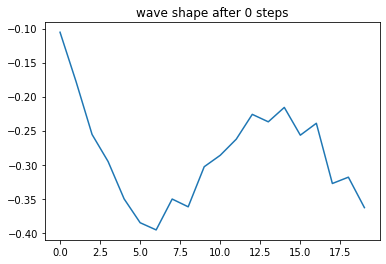

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_0/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_0/model_weights.tf
generator loss:0.9947504753802898
-----------------------


  0%|          | 1/1562 [00:10<4:20:59, 10.03s/it]

total discriminator loss:0.5952014165138114
average true return:0.49071583250989737
-----------------------
Training Step: 1
generator loss:1.0359478092197973
-----------------------


  0%|          | 2/1562 [00:11<2:13:56,  5.15s/it]

total discriminator loss:0.6093891377527962
average true return:0.48082000580646644
-----------------------
Training Step: 2
generator loss:0.9785836569247683
-----------------------


  0%|          | 3/1562 [00:13<1:33:24,  3.59s/it]

total discriminator loss:0.5984520175862502
average true return:0.5034744439868756
-----------------------
Training Step: 3
generator loss:0.9043868754449543
-----------------------


  0%|          | 4/1562 [00:15<1:14:21,  2.86s/it]

total discriminator loss:0.6129660675385324
average true return:0.5022218458586615
-----------------------
Training Step: 4
generator loss:0.9054520036526095
-----------------------


  0%|          | 5/1562 [00:17<1:04:55,  2.50s/it]

total discriminator loss:0.6566596573169176
average true return:0.5329150436502432
-----------------------
Training Step: 5
event_types: [0, 2, 1, 3, 3, 3, 3, 2, 1, 3, 2, 1, 2, 0, 0, 3, 2, 1, 2, 2]
mad_score: 0.633275
fid_score: 10155.445515313408
rule_score: 0.354


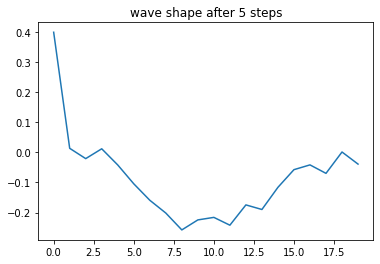

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_5/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_5/model_weights.tf
generator loss:0.8875045774268864
-----------------------


  0%|          | 6/1562 [00:27<2:11:17,  5.06s/it]

total discriminator loss:0.6304106223749457
average true return:0.5069739434381544
-----------------------
Training Step: 6
generator loss:0.8747367513142972
-----------------------


  0%|          | 7/1562 [00:28<1:43:10,  3.98s/it]

total discriminator loss:0.623113607730734
average true return:0.5131267907325179
-----------------------
Training Step: 7
generator loss:0.8213459738947395
-----------------------


  1%|          | 8/1562 [00:30<1:24:40,  3.27s/it]

total discriminator loss:0.6365486459556542
average true return:0.5017151928485081
-----------------------
Training Step: 8
generator loss:0.8626326998858358
-----------------------


  1%|          | 9/1562 [00:32<1:12:18,  2.79s/it]

total discriminator loss:0.6557414173173142
average true return:0.5367755989633942
-----------------------
Training Step: 9
generator loss:0.8618250933087046
-----------------------


  1%|          | 10/1562 [00:34<1:03:53,  2.47s/it]

total discriminator loss:0.6769327961374282
average true return:0.4927703517647394
-----------------------
Training Step: 10
event_types: [3, 0, 0, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 1, 1, 3, 2, 0, 0, 2]
mad_score: 0.622875
fid_score: 10578.7115353103
rule_score: 0.3505


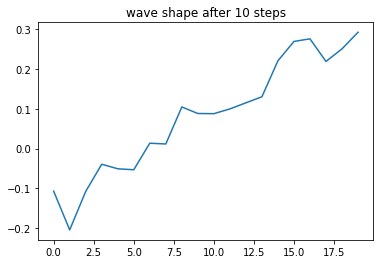

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_10/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_10/model_weights.tf
generator loss:0.8686682191989432
-----------------------


  1%|          | 11/1562 [00:44<2:04:02,  4.80s/it]

total discriminator loss:0.790654755294574
average true return:0.516520408188406
-----------------------
Training Step: 11
generator loss:0.8714165520771928
-----------------------


  1%|          | 12/1562 [00:45<1:40:00,  3.87s/it]

total discriminator loss:0.679540616761668
average true return:0.5182715386669632
-----------------------
Training Step: 12
generator loss:0.808654804441659
-----------------------


  1%|          | 13/1562 [00:47<1:23:22,  3.23s/it]

total discriminator loss:0.7003369531304628
average true return:0.5088394175984317
-----------------------
Training Step: 13
generator loss:0.8214541342018786
-----------------------


  1%|          | 14/1562 [00:49<1:11:45,  2.78s/it]

total discriminator loss:0.7147910920074372
average true return:0.4829918892302937
-----------------------
Training Step: 14
generator loss:0.8072510891457809
-----------------------


  1%|          | 15/1562 [00:51<1:03:42,  2.47s/it]

total discriminator loss:0.7084979411335557
average true return:0.5029633796041268
-----------------------
Training Step: 15
event_types: [1, 3, 3, 0, 1, 1, 0, 2, 1, 3, 2, 2, 2, 3, 2, 3, 0, 0, 2, 1]
mad_score: 0.6080625
fid_score: 11725.119791379995
rule_score: 0.3535


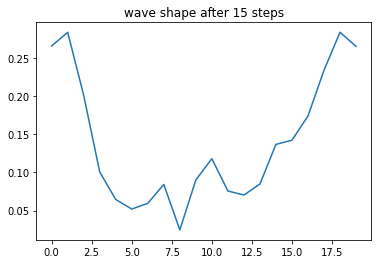

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_15/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_15/model_weights.tf
generator loss:0.7808237928920551
-----------------------


  1%|          | 16/1562 [01:01<2:02:17,  4.75s/it]

total discriminator loss:0.7114254700093614
average true return:0.4884900803303184
-----------------------
Training Step: 16
generator loss:0.7453775286023137
-----------------------


  1%|          | 17/1562 [01:02<1:38:58,  3.84s/it]

total discriminator loss:0.7053985957251339
average true return:0.4933390403834138
-----------------------
Training Step: 17
generator loss:0.7376978723608324
-----------------------


  1%|          | 18/1562 [01:04<1:22:41,  3.21s/it]

total discriminator loss:0.7237192864479456
average true return:0.518224141030369
-----------------------
Training Step: 18
generator loss:0.7603547435099164
-----------------------


  1%|          | 19/1562 [01:06<1:11:18,  2.77s/it]

total discriminator loss:0.719855216476784
average true return:0.49900543469481895
-----------------------
Training Step: 19
generator loss:0.7310923510474703
-----------------------


  1%|▏         | 20/1562 [01:08<1:03:21,  2.46s/it]

total discriminator loss:0.7382979863139418
average true return:0.5117060795177382
-----------------------
Training Step: 20
event_types: [2, 0, 0, 2, 3, 0, 3, 2, 3, 2, 1, 3, 3, 2, 0, 2, 2, 2, 2, 2]
mad_score: 0.601975
fid_score: 13648.31050554206
rule_score: 0.33125


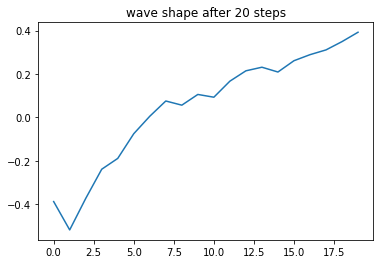

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_20/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_20/model_weights.tf
generator loss:0.7295908548812187
-----------------------


  1%|▏         | 21/1562 [01:18<2:02:41,  4.78s/it]

total discriminator loss:0.747637943245232
average true return:0.5145127034734034
-----------------------
Training Step: 21
generator loss:0.7033058319990824
-----------------------


  1%|▏         | 22/1562 [01:20<1:39:27,  3.88s/it]

total discriminator loss:0.7531652311718484
average true return:0.5091895976356362
-----------------------
Training Step: 22
generator loss:0.7316847086163308
-----------------------


  1%|▏         | 23/1562 [01:21<1:23:22,  3.25s/it]

total discriminator loss:0.7246898580890855
average true return:0.5159456468233017
-----------------------
Training Step: 23
generator loss:0.715504662179127
-----------------------


  2%|▏         | 24/1562 [01:23<1:12:08,  2.81s/it]

total discriminator loss:0.7277210263225615
average true return:0.49916879562818495
-----------------------
Training Step: 24
generator loss:0.7381582224733128
-----------------------


  2%|▏         | 25/1562 [01:25<1:04:15,  2.51s/it]

total discriminator loss:0.7367824874012467
average true return:0.5017004608291677
-----------------------
Training Step: 25
event_types: [3, 0, 2, 2, 3, 3, 2, 1, 2, 2, 3, 2, 3, 2, 3, 3, 2, 2, 1, 2]
mad_score: 0.5884
fid_score: 16329.659044945165
rule_score: 0.35475


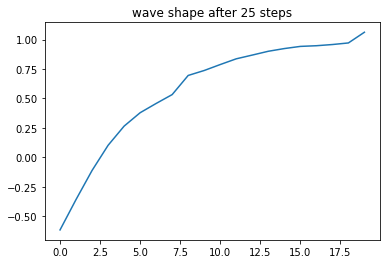

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_25/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_25/model_weights.tf
generator loss:0.7245786999411916
-----------------------


  2%|▏         | 26/1562 [01:35<2:02:36,  4.79s/it]

total discriminator loss:0.7253509126148432
average true return:0.5101960199618507
-----------------------
Training Step: 26
generator loss:0.7068986923479069
-----------------------


  2%|▏         | 27/1562 [01:37<1:39:10,  3.88s/it]

total discriminator loss:0.7358887062355618
average true return:0.5096784951051291
-----------------------
Training Step: 27
generator loss:0.7464165456644668
-----------------------


  2%|▏         | 28/1562 [01:39<1:22:44,  3.24s/it]

total discriminator loss:0.7323725155295915
average true return:0.5077886735678458
-----------------------
Training Step: 28
generator loss:0.7206906679817413
-----------------------


  2%|▏         | 29/1562 [01:40<1:11:19,  2.79s/it]

total discriminator loss:0.7137671886001109
average true return:0.5049890349118844
-----------------------
Training Step: 29
generator loss:0.7291223618662859
-----------------------


  2%|▏         | 30/1562 [01:42<1:03:23,  2.48s/it]

total discriminator loss:0.6990022810480523
average true return:0.5160893439260572
-----------------------
Training Step: 30
event_types: [1, 0, 3, 1, 1, 0, 0, 3, 2, 3, 1, 0, 1, 2, 2, 0, 2, 0, 2, 2]
mad_score: 0.5749375
fid_score: 19847.061366068156
rule_score: 0.354


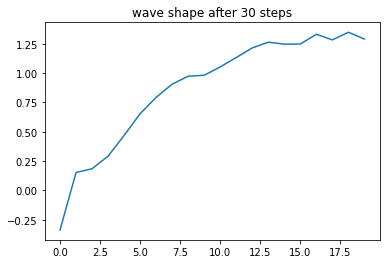

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_30/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_30/model_weights.tf
generator loss:0.7351618504784482
-----------------------


  2%|▏         | 31/1562 [01:52<2:02:06,  4.79s/it]

total discriminator loss:0.6831589484906372
average true return:0.5100092131104978
-----------------------
Training Step: 31
generator loss:0.7129731180521324
-----------------------


  2%|▏         | 32/1562 [01:54<1:39:45,  3.91s/it]

total discriminator loss:0.6882362863152702
average true return:0.5174256893013709
-----------------------
Training Step: 32
generator loss:0.7460481293500356
-----------------------


  2%|▏         | 33/1562 [01:56<1:23:18,  3.27s/it]

total discriminator loss:0.6863162977349021
average true return:0.5217184619108537
-----------------------
Training Step: 33
generator loss:0.7468177820362436
-----------------------


  2%|▏         | 34/1562 [01:58<1:11:41,  2.82s/it]

total discriminator loss:0.6679522402354842
average true return:0.5234924159508737
-----------------------
Training Step: 34
generator loss:0.8015715700320756
-----------------------


  2%|▏         | 35/1562 [01:59<1:03:36,  2.50s/it]

total discriminator loss:0.6387194288987523
average true return:0.530082161693061
-----------------------
Training Step: 35
event_types: [1, 1, 2, 2, 0, 2, 0, 3, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 2, 0]
mad_score: 0.5592375
fid_score: 23568.8522167265
rule_score: 0.36525


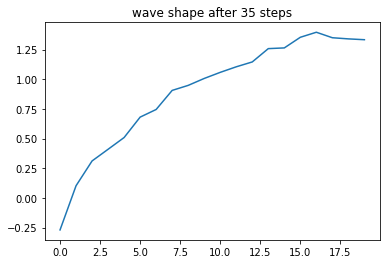

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_35/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_35/model_weights.tf
generator loss:0.7679172081572108
-----------------------


  2%|▏         | 36/1562 [02:10<2:01:50,  4.79s/it]

total discriminator loss:0.6310185640825816
average true return:0.5113723819345901
-----------------------
Training Step: 36
generator loss:0.8048015812120428
-----------------------


  2%|▏         | 37/1562 [02:11<1:38:32,  3.88s/it]

total discriminator loss:0.621588873765146
average true return:0.5125736164478782
-----------------------
Training Step: 37
generator loss:0.810366861719498
-----------------------


  2%|▏         | 38/1562 [02:13<1:22:19,  3.24s/it]

total discriminator loss:0.6189817967681847
average true return:0.5162741640446175
-----------------------
Training Step: 38
generator loss:0.8685856357913226
-----------------------


  2%|▏         | 39/1562 [02:15<1:10:56,  2.80s/it]

total discriminator loss:0.5830473839094323
average true return:0.5054817905602221
-----------------------
Training Step: 39
generator loss:0.8744163871417225
-----------------------


  3%|▎         | 40/1562 [02:17<1:02:57,  2.48s/it]

total discriminator loss:0.5843060936323127
average true return:0.5163789177793306
-----------------------
Training Step: 40
event_types: [1, 1, 2, 2, 1, 2, 0, 1, 3, 2, 2, 0, 2, 1, 2, 2, 2, 2, 3, 2]
mad_score: 0.5398625
fid_score: 27042.197580031432
rule_score: 0.3785


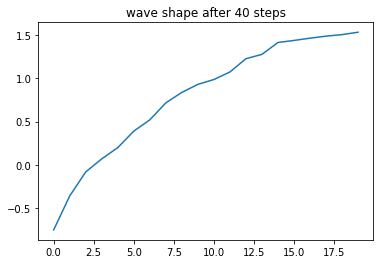

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_40/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_40/model_weights.tf
generator loss:0.9185633942229889
-----------------------


  3%|▎         | 41/1562 [02:27<2:00:32,  4.76s/it]

total discriminator loss:0.5734997656267633
average true return:0.5056884775045417
-----------------------
Training Step: 41
generator loss:0.9511609109201147
-----------------------


  3%|▎         | 42/1562 [02:28<1:37:37,  3.85s/it]

total discriminator loss:0.5646793808700906
average true return:0.5033013141650844
-----------------------
Training Step: 42
generator loss:0.953194319586808
-----------------------


  3%|▎         | 43/1562 [02:30<1:21:35,  3.22s/it]

total discriminator loss:0.5498215480733394
average true return:0.4966690333485951
-----------------------
Training Step: 43
generator loss:1.006664250374568
-----------------------


  3%|▎         | 44/1562 [02:32<1:10:24,  2.78s/it]

total discriminator loss:0.5420316291199163
average true return:0.4986773955978029
-----------------------
Training Step: 44
generator loss:1.0362543369570785
-----------------------


  3%|▎         | 45/1562 [02:34<1:02:31,  2.47s/it]

total discriminator loss:0.5244154636314862
average true return:0.4879385544675743
-----------------------
Training Step: 45
event_types: [2, 2, 1, 0, 3, 0, 2, 2, 1, 2, 3, 0, 1, 2, 2, 2, 2, 2, 1, 0]
mad_score: 0.5176625
fid_score: 29062.83033747659
rule_score: 0.4265


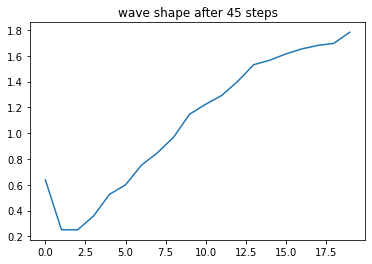

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_45/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_45/model_weights.tf
generator loss:1.0615939646161068
-----------------------


  3%|▎         | 46/1562 [02:44<2:00:16,  4.76s/it]

total discriminator loss:0.5168531114764177
average true return:0.48609694036011736
-----------------------
Training Step: 46
generator loss:1.0868545868993802
-----------------------


  3%|▎         | 47/1562 [02:46<1:37:28,  3.86s/it]

total discriminator loss:0.5127288725152297
average true return:0.4884341089342201
-----------------------
Training Step: 47
generator loss:1.11124305359884
-----------------------


  3%|▎         | 48/1562 [02:47<1:21:30,  3.23s/it]

total discriminator loss:0.5021004778521018
average true return:0.4820358763213336
-----------------------
Training Step: 48
generator loss:1.163051405077263
-----------------------


  3%|▎         | 49/1562 [02:49<1:10:17,  2.79s/it]

total discriminator loss:0.4861947886730061
average true return:0.478974732246382
-----------------------
Training Step: 49
generator loss:1.1863907306290642
-----------------------


  3%|▎         | 50/1562 [02:51<1:02:25,  2.48s/it]

total discriminator loss:0.47932716691093175
average true return:0.4776369451711764
-----------------------
Training Step: 50
event_types: [0, 1, 3, 2, 3, 2, 1, 1, 1, 1, 2, 3, 2, 3, 1, 2, 3, 0, 0, 1]
mad_score: 0.493975
fid_score: 28147.645682128234
rule_score: 0.453


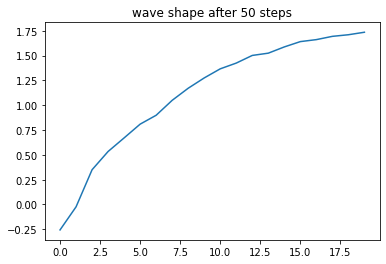

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_50/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_50/model_weights.tf
generator loss:1.221693138398102
-----------------------


  3%|▎         | 51/1562 [03:01<2:00:33,  4.79s/it]

total discriminator loss:0.47737012850175975
average true return:0.474916300831455
-----------------------
Training Step: 51
generator loss:1.2260767042116187
-----------------------


  3%|▎         | 52/1562 [03:03<1:37:33,  3.88s/it]

total discriminator loss:0.4595410223901504
average true return:0.4843113148660184
-----------------------
Training Step: 52
generator loss:1.23928176697124
-----------------------


  3%|▎         | 53/1562 [03:05<1:21:26,  3.24s/it]

total discriminator loss:0.45336303653964216
average true return:0.48426386681157585
-----------------------
Training Step: 53
generator loss:1.2428145999433517
-----------------------


  3%|▎         | 54/1562 [03:06<1:10:10,  2.79s/it]

total discriminator loss:0.4485747479123763
average true return:0.4865278261148354
-----------------------
Training Step: 54
generator loss:1.2657288297355866
-----------------------


  4%|▎         | 55/1562 [03:08<1:02:15,  2.48s/it]

total discriminator loss:0.4550144307226055
average true return:0.48135637304428724
-----------------------
Training Step: 55
event_types: [2, 3, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 3, 0, 2, 3]
mad_score: 0.4742125
fid_score: 24759.161372141985
rule_score: 0.493


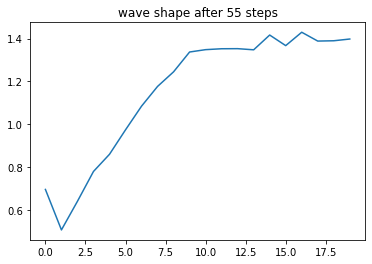

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_55/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_55/model_weights.tf
generator loss:1.2796945184800386
-----------------------


  4%|▎         | 56/1562 [03:18<1:59:23,  4.76s/it]

total discriminator loss:0.4535128104470252
average true return:0.4980768199850259
-----------------------
Training Step: 56
generator loss:1.3154137242583746
-----------------------


  4%|▎         | 57/1562 [03:20<1:36:40,  3.85s/it]

total discriminator loss:0.4463633632905295
average true return:0.49331844669789227
-----------------------
Training Step: 57
generator loss:1.298763752148996
-----------------------


  4%|▎         | 58/1562 [03:22<1:20:49,  3.22s/it]

total discriminator loss:0.4397859460650567
average true return:0.49474097303938225
-----------------------
Training Step: 58
generator loss:1.325214698203776
-----------------------


  4%|▍         | 59/1562 [03:23<1:09:45,  2.78s/it]

total discriminator loss:0.4415982436223015
average true return:0.4999664956016945
-----------------------
Training Step: 59
generator loss:1.296198654751719
-----------------------


  4%|▍         | 60/1562 [03:25<1:01:58,  2.48s/it]

total discriminator loss:0.4484961287188032
average true return:0.5068921532989217
-----------------------
Training Step: 60
event_types: [1, 2, 0, 1, 2, 0, 0, 2, 2, 2, 2, 0, 0, 1, 2, 1, 2, 2, 2, 2]
mad_score: 0.46025
fid_score: 19872.183687493853
rule_score: 0.53675


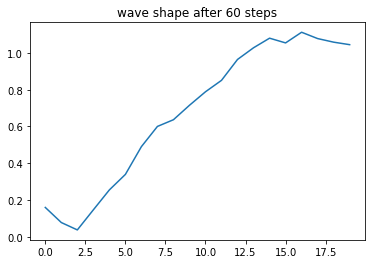

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_60/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_60/model_weights.tf
generator loss:1.2609052747869116
-----------------------


  4%|▍         | 61/1562 [03:35<1:58:50,  4.75s/it]

total discriminator loss:0.4450464197933123
average true return:0.510565944080134
-----------------------
Training Step: 61
generator loss:1.3229054899147914
-----------------------


  4%|▍         | 62/1562 [03:37<1:36:12,  3.85s/it]

total discriminator loss:0.43375920349956887
average true return:0.5100846817503035
-----------------------
Training Step: 62
generator loss:1.30426647199479
-----------------------


  4%|▍         | 63/1562 [03:39<1:20:24,  3.22s/it]

total discriminator loss:0.4548813944846098
average true return:0.4981372951708881
-----------------------
Training Step: 63
generator loss:1.3059961400413025
-----------------------


  4%|▍         | 64/1562 [03:40<1:09:21,  2.78s/it]

total discriminator loss:0.4558438505637529
average true return:0.5073922183158883
-----------------------
Training Step: 64
generator loss:1.3087462960306473
-----------------------


  4%|▍         | 65/1562 [03:42<1:01:36,  2.47s/it]

total discriminator loss:0.4452631904282992
average true return:0.5111991249992832
-----------------------
Training Step: 65
event_types: [0, 1, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 0, 1]
mad_score: 0.4523875
fid_score: 15298.150487671552
rule_score: 0.57975


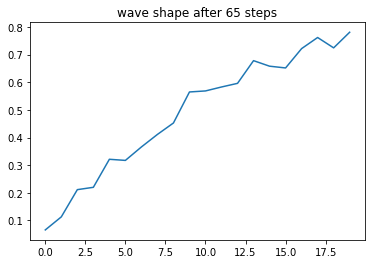

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_65/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_65/model_weights.tf
generator loss:1.3148955949798617
-----------------------


  4%|▍         | 66/1562 [03:52<1:59:09,  4.78s/it]

total discriminator loss:0.4646356658073365
average true return:0.5126219314371936
-----------------------
Training Step: 66
generator loss:1.3286950239789477
-----------------------


  4%|▍         | 67/1562 [03:54<1:36:23,  3.87s/it]

total discriminator loss:0.47333270388469123
average true return:0.5016588624475569
-----------------------
Training Step: 67
generator loss:1.300293342021874
-----------------------


  4%|▍         | 68/1562 [03:56<1:20:33,  3.24s/it]

total discriminator loss:0.46989206335808653
average true return:0.49976930376927864
-----------------------
Training Step: 68
generator loss:1.2812611124380167
-----------------------


  4%|▍         | 69/1562 [03:58<1:09:26,  2.79s/it]

total discriminator loss:0.4676718284220096
average true return:0.4970056329672627
-----------------------
Training Step: 69
generator loss:1.2471498836109804
-----------------------


  4%|▍         | 70/1562 [03:59<1:01:52,  2.49s/it]

total discriminator loss:1.1182781134147948
average true return:0.5015847428171315
-----------------------
Training Step: 70
event_types: [1, 2, 3, 2, 3, 2, 1, 3, 2, 1, 2, 2, 1, 2, 3, 1, 2, 2, 2, 1]
mad_score: 0.4505
fid_score: 11926.618959937801
rule_score: 0.57625


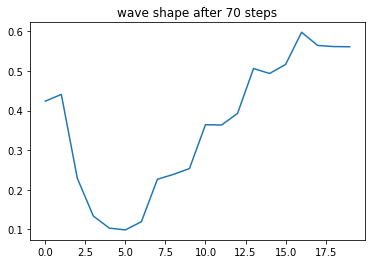

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_70/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_70/model_weights.tf
generator loss:1.1703417831846772
-----------------------


  5%|▍         | 71/1562 [04:09<1:58:56,  4.79s/it]

total discriminator loss:0.49523117013329915
average true return:0.5048595440949517
-----------------------
Training Step: 71
generator loss:1.1062494745303417
-----------------------


  5%|▍         | 72/1562 [04:11<1:36:15,  3.88s/it]

total discriminator loss:0.5409599612315403
average true return:0.5358548570535552
-----------------------
Training Step: 72
generator loss:1.0912314969041332
-----------------------


  5%|▍         | 73/1562 [04:13<1:20:21,  3.24s/it]

total discriminator loss:0.5333113626681008
average true return:0.5399739220486474
-----------------------
Training Step: 73
generator loss:1.0365649340626972
-----------------------


  5%|▍         | 74/1562 [04:15<1:09:13,  2.79s/it]

total discriminator loss:0.5540994217197619
average true return:0.5215195576182279
-----------------------
Training Step: 74
generator loss:0.9834564107995659
-----------------------


  5%|▍         | 75/1562 [04:16<1:01:25,  2.48s/it]

total discriminator loss:0.5846423018127271
average true return:0.5308598544973075
-----------------------
Training Step: 75
event_types: [0, 3, 0, 1, 1, 2, 0, 1, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1, 2, 2]
mad_score: 0.452775
fid_score: 10228.79335590918
rule_score: 0.6025


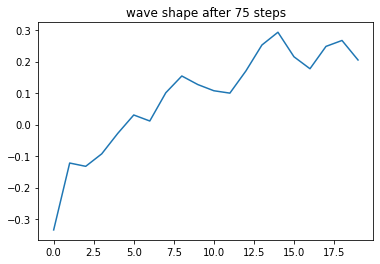

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_75/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_75/model_weights.tf
generator loss:0.9226372668228373
-----------------------


  5%|▍         | 76/1562 [04:27<1:58:01,  4.77s/it]

total discriminator loss:0.5583335229533363
average true return:0.5477246808401155
-----------------------
Training Step: 76
generator loss:0.906786196116041
-----------------------


  5%|▍         | 77/1562 [04:28<1:35:32,  3.86s/it]

total discriminator loss:0.5664528521879818
average true return:0.526140212561641
-----------------------
Training Step: 77
generator loss:0.9223226849269341
-----------------------


  5%|▍         | 78/1562 [04:30<1:19:46,  3.23s/it]

total discriminator loss:0.6134895390883524
average true return:0.5482884778433877
-----------------------
Training Step: 78
generator loss:0.8578015957765222
-----------------------


  5%|▌         | 79/1562 [04:32<1:08:45,  2.78s/it]

total discriminator loss:0.6248796281786506
average true return:0.5583766675965569
-----------------------
Training Step: 79
generator loss:0.8505435043412156
-----------------------


  5%|▌         | 80/1562 [04:34<1:01:04,  2.47s/it]

total discriminator loss:0.643549435954582
average true return:0.546647381666292
-----------------------
Training Step: 80
event_types: [2, 1, 2, 2, 0, 1, 1, 2, 1, 3, 1, 2, 3, 2, 1, 2, 2, 2, 1, 0]
mad_score: 0.4564375
fid_score: 10193.911639713144
rule_score: 0.60125


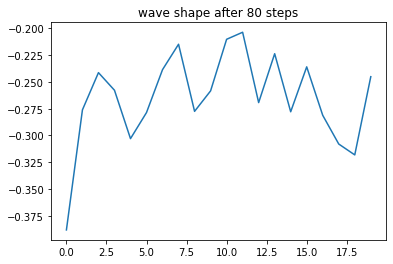

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_80/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_80/model_weights.tf
generator loss:0.8608052390396879
-----------------------


  5%|▌         | 81/1562 [04:44<1:58:46,  4.81s/it]

total discriminator loss:0.6722423532839715
average true return:0.5192976948440284
-----------------------
Training Step: 81
generator loss:0.8163309930794094
-----------------------


  5%|▌         | 82/1562 [04:46<1:36:02,  3.89s/it]

total discriminator loss:0.6718343641458022
average true return:0.5445185065852935
-----------------------
Training Step: 82
generator loss:0.7948444842452712
-----------------------


  5%|▌         | 83/1562 [04:47<1:20:07,  3.25s/it]

total discriminator loss:0.6716775323073819
average true return:0.5388203260041871
-----------------------
Training Step: 83
generator loss:0.7993483823239418
-----------------------


  5%|▌         | 84/1562 [04:49<1:08:54,  2.80s/it]

total discriminator loss:0.7474255002119952
average true return:0.5262753542372394
-----------------------
Training Step: 84
generator loss:0.819350321110676
-----------------------


  5%|▌         | 85/1562 [04:51<1:01:06,  2.48s/it]

total discriminator loss:0.7151811826642287
average true return:0.5132340780384664
-----------------------
Training Step: 85
event_types: [0, 2, 3, 2, 2, 2, 0, 1, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 0, 1]
mad_score: 0.4657625
fid_score: 11678.127395434822
rule_score: 0.583


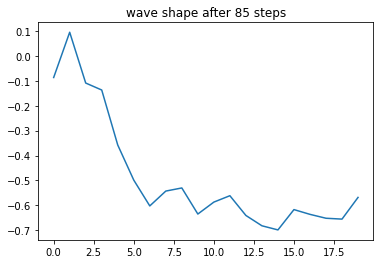

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_85/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_85/model_weights.tf
generator loss:0.7552265140347633
-----------------------


  6%|▌         | 86/1562 [05:01<1:57:08,  4.76s/it]

total discriminator loss:0.7123110502777854
average true return:0.5104093394203159
-----------------------
Training Step: 86
generator loss:0.7420850596982941
-----------------------


  6%|▌         | 87/1562 [05:03<1:34:54,  3.86s/it]

total discriminator loss:0.7233380321997949
average true return:0.5204488021400971
-----------------------
Training Step: 87
generator loss:0.7270863803665781
-----------------------


  6%|▌         | 88/1562 [05:04<1:19:15,  3.23s/it]

total discriminator loss:0.7265980685726562
average true return:0.5332756039589077
-----------------------
Training Step: 88
generator loss:0.7233480139344266
-----------------------


  6%|▌         | 89/1562 [05:06<1:08:18,  2.78s/it]

total discriminator loss:0.7705908131874464
average true return:0.5085286477781815
-----------------------
Training Step: 89
generator loss:0.7136297936950542
-----------------------


  6%|▌         | 90/1562 [05:08<1:00:40,  2.47s/it]

total discriminator loss:0.768953672493746
average true return:0.5239234969709472
-----------------------
Training Step: 90
event_types: [2, 0, 0, 2, 3, 1, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2]
mad_score: 0.480475
fid_score: 14516.006505928175
rule_score: 0.0685


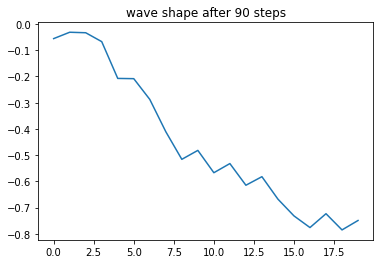

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_90/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_90/model_weights.tf
generator loss:0.7077226561220216
-----------------------


  6%|▌         | 91/1562 [05:18<1:55:23,  4.71s/it]

total discriminator loss:0.7276404500928552
average true return:0.5297835848163825
-----------------------
Training Step: 91
generator loss:0.7017293529251832
-----------------------


  6%|▌         | 92/1562 [05:20<1:33:34,  3.82s/it]

total discriminator loss:0.7155715478080039
average true return:0.5236913146790008
-----------------------
Training Step: 92
generator loss:0.7095040467221422
-----------------------


  6%|▌         | 93/1562 [05:21<1:18:15,  3.20s/it]

total discriminator loss:0.7374412112102314
average true return:0.5281357721867967
-----------------------
Training Step: 93
generator loss:0.7116456229785442
-----------------------


  6%|▌         | 94/1562 [05:23<1:07:38,  2.76s/it]

total discriminator loss:0.7187244103033124
average true return:0.5369799108604388
-----------------------
Training Step: 94
generator loss:0.7163573318713439
-----------------------


  6%|▌         | 95/1562 [05:25<1:00:08,  2.46s/it]

total discriminator loss:0.7029756588262129
average true return:0.5300767898135036
-----------------------
Training Step: 95
event_types: [3, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2, 0, 3, 2, 2, 3, 2, 2, 2, 3]
mad_score: 0.510925
fid_score: 18466.79117787426
rule_score: 0.00425


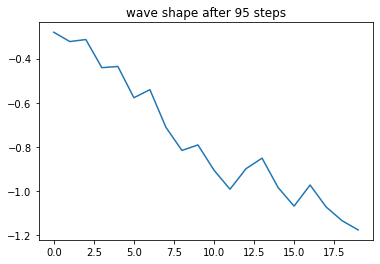

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_95/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_95/model_weights.tf
generator loss:0.7196889760414288
-----------------------


  6%|▌         | 96/1562 [05:35<1:54:58,  4.71s/it]

total discriminator loss:0.6956431338941238
average true return:0.5309220265552113
-----------------------
Training Step: 96
generator loss:0.7377523822709067
-----------------------


  6%|▌         | 97/1562 [05:37<1:33:13,  3.82s/it]

total discriminator loss:0.6811537095270006
average true return:0.5366860866867802
-----------------------
Training Step: 97
generator loss:0.7569202581658484
-----------------------


  6%|▋         | 98/1562 [05:38<1:17:59,  3.20s/it]

total discriminator loss:0.6644796438485957
average true return:0.5356945884253034
-----------------------
Training Step: 98
generator loss:0.7638624982977392
-----------------------


  6%|▋         | 99/1562 [05:40<1:07:24,  2.76s/it]

total discriminator loss:0.6496290186897999
average true return:0.5295320206435359
-----------------------
Training Step: 99
generator loss:0.7890789648288474
-----------------------


  6%|▋         | 100/1562 [05:42<1:00:00,  2.46s/it]

total discriminator loss:0.6444874615328079
average true return:0.5088673792775706
-----------------------
Training Step: 100
event_types: [2, 0, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 0, 2, 1, 2, 1]
mad_score: 0.55045
fid_score: 22582.721182026842
rule_score: 0.00225


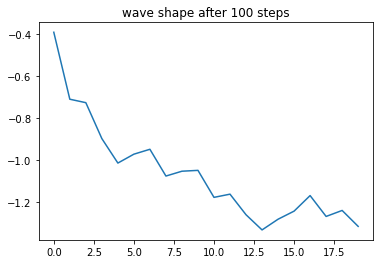

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_100/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_100/model_weights.tf
generator loss:0.833438797957438
-----------------------


  6%|▋         | 101/1562 [05:52<1:54:02,  4.68s/it]

total discriminator loss:0.6126165577950953
average true return:0.5136645467493511
-----------------------
Training Step: 101
generator loss:0.8537653436336149
-----------------------


  7%|▋         | 102/1562 [05:53<1:32:31,  3.80s/it]

total discriminator loss:0.5933316684148904
average true return:0.5017290684205172
-----------------------
Training Step: 102
generator loss:0.9041502167153102
-----------------------


  7%|▋         | 103/1562 [05:55<1:17:30,  3.19s/it]

total discriminator loss:0.5786619846000534
average true return:0.49849145431371544
-----------------------
Training Step: 103
generator loss:0.9466081386387104
-----------------------


  7%|▋         | 104/1562 [05:57<1:06:57,  2.76s/it]

total discriminator loss:0.5545970325445077
average true return:0.4958270166867462
-----------------------
Training Step: 104
generator loss:1.0000789924867128
-----------------------


  7%|▋         | 105/1562 [05:59<59:35,  2.45s/it]  

total discriminator loss:0.551742836440587
average true return:0.5017061472131802
-----------------------
Training Step: 105
event_types: [1, 3, 0, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 0, 2, 2, 1, 2, 3]
mad_score: 0.6058
fid_score: 25800.240183124537
rule_score: 0.00175


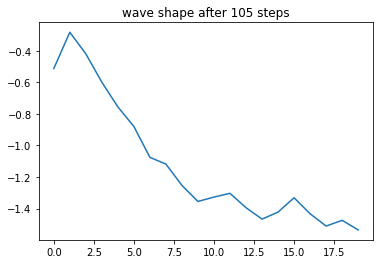

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_105/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_105/model_weights.tf
generator loss:1.0021973438028822
-----------------------


  7%|▋         | 106/1562 [06:09<1:53:38,  4.68s/it]

total discriminator loss:0.5333127316988686
average true return:0.49128630566657683
-----------------------
Training Step: 106
generator loss:1.0586737096138723
-----------------------


  7%|▋         | 107/1562 [06:10<1:32:14,  3.80s/it]

total discriminator loss:0.5328071854312477
average true return:0.48664853792418317
-----------------------
Training Step: 107
generator loss:1.0931957176795601
-----------------------


  7%|▋         | 108/1562 [06:12<1:17:13,  3.19s/it]

total discriminator loss:0.5114429005472952
average true return:0.4954403737883173
-----------------------
Training Step: 108
generator loss:1.1185014197151668
-----------------------


  7%|▋         | 109/1562 [06:14<1:06:45,  2.76s/it]

total discriminator loss:0.4837720044063327
average true return:0.4976183959851997
-----------------------
Training Step: 109
generator loss:1.13784747179372
-----------------------


  7%|▋         | 110/1562 [06:16<59:24,  2.46s/it]  

total discriminator loss:0.47154335963390154
average true return:0.49986680145002854
-----------------------
Training Step: 110
event_types: [0, 0, 1, 2, 2, 1, 1, 1, 0, 2, 1, 3, 2, 2, 1, 2, 1, 0, 1, 1]
mad_score: 0.659225
fid_score: 27709.708040133453
rule_score: 0.00375


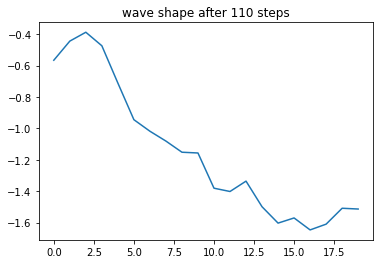

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_110/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_110/model_weights.tf
generator loss:1.1844076924467397
-----------------------


  7%|▋         | 111/1562 [06:26<1:53:57,  4.71s/it]

total discriminator loss:1.058471812604906
average true return:0.49647939620382375
-----------------------
Training Step: 111
generator loss:1.1771395427414886
-----------------------


  7%|▋         | 112/1562 [06:27<1:32:26,  3.83s/it]

total discriminator loss:0.45424611703349294
average true return:0.49857475960368025
-----------------------
Training Step: 112
generator loss:1.1857964519051485
-----------------------


  7%|▋         | 113/1562 [06:29<1:17:25,  3.21s/it]

total discriminator loss:1.1317532099154612
average true return:0.5069948106990789
-----------------------
Training Step: 113
generator loss:1.1805574781189714
-----------------------


  7%|▋         | 114/1562 [06:31<1:07:07,  2.78s/it]

total discriminator loss:0.4568268456474074
average true return:0.5060967365443275
-----------------------
Training Step: 114
generator loss:1.1882110873017753
-----------------------


  7%|▋         | 115/1562 [06:33<59:58,  2.49s/it]  

total discriminator loss:0.45681314867554995
average true return:0.5053597598450883
-----------------------
Training Step: 115
event_types: [0, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 3, 2, 1, 3, 1, 1, 1, 2]
mad_score: 0.7131875
fid_score: 27412.018743302215
rule_score: 0.00225


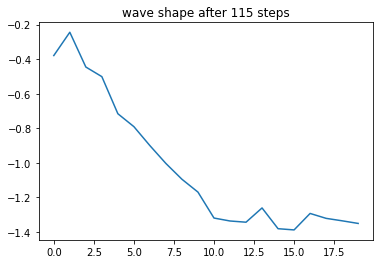

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_115/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_115/model_weights.tf
generator loss:1.1680595393225666
-----------------------


  7%|▋         | 116/1562 [06:43<1:54:24,  4.75s/it]

total discriminator loss:0.4523107940167739
average true return:0.5123836427997612
-----------------------
Training Step: 116
generator loss:1.1758324370970166
-----------------------


  7%|▋         | 117/1562 [06:44<1:32:40,  3.85s/it]

total discriminator loss:0.4448143496880589
average true return:0.5197491301365429
-----------------------
Training Step: 117
generator loss:1.1942625540293286
-----------------------


  8%|▊         | 118/1562 [06:46<1:17:28,  3.22s/it]

total discriminator loss:0.45823646129875484
average true return:0.5063952620336877
-----------------------
Training Step: 118
generator loss:1.2050109532883124
-----------------------


  8%|▊         | 119/1562 [06:48<1:06:52,  2.78s/it]

total discriminator loss:0.4771270053602793
average true return:0.509761306305238
-----------------------
Training Step: 119
generator loss:1.2021411812902145
-----------------------


  8%|▊         | 120/1562 [06:50<59:23,  2.47s/it]  

total discriminator loss:0.4422586557725353
average true return:0.516572615279672
-----------------------
Training Step: 120
event_types: [1, 3, 2, 0, 1, 2, 0, 0, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1]
mad_score: 0.751875
fid_score: 25255.626497970683
rule_score: 0.00275


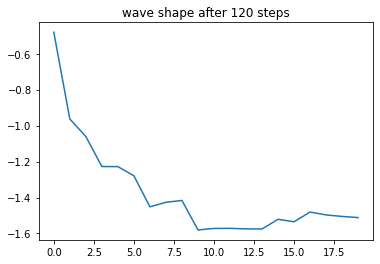

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_120/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_120/model_weights.tf
generator loss:1.2386022757940416
-----------------------


  8%|▊         | 121/1562 [07:00<1:52:35,  4.69s/it]

total discriminator loss:0.45178954084736384
average true return:0.5168401968068244
-----------------------
Training Step: 121
generator loss:1.2160745568873506
-----------------------


  8%|▊         | 122/1562 [07:01<1:31:23,  3.81s/it]

total discriminator loss:0.4438541489539789
average true return:0.5164234216834354
-----------------------
Training Step: 122
generator loss:1.241841009011225
-----------------------


  8%|▊         | 123/1562 [07:03<1:16:34,  3.19s/it]

total discriminator loss:0.412581840927696
average true return:0.5213025820064263
-----------------------
Training Step: 123
generator loss:1.268293501212052
-----------------------


  8%|▊         | 124/1562 [07:05<1:06:10,  2.76s/it]

total discriminator loss:0.42246837525211467
average true return:0.5195878620347877
-----------------------
Training Step: 124
generator loss:1.2799267646296768
-----------------------


  8%|▊         | 125/1562 [07:07<58:51,  2.46s/it]  

total discriminator loss:0.44447590193401226
average true return:0.5136793848423591
-----------------------
Training Step: 125
event_types: [0, 2, 0, 0, 1, 0, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0]
mad_score: 0.7799875
fid_score: 22054.684012427562
rule_score: 0.00225


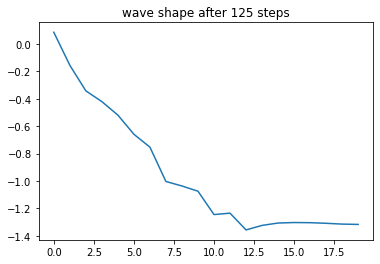

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_125/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_125/model_weights.tf
generator loss:1.2882072083097555
-----------------------


  8%|▊         | 126/1562 [07:16<1:52:35,  4.70s/it]

total discriminator loss:0.43586908880519215
average true return:0.5154477068893314
-----------------------
Training Step: 126
generator loss:1.2960682335364695
-----------------------


  8%|▊         | 127/1562 [07:18<1:31:19,  3.82s/it]

total discriminator loss:0.41238524051866576
average true return:0.5179755904595822
-----------------------
Training Step: 127
generator loss:1.311356356469525
-----------------------


  8%|▊         | 128/1562 [07:20<1:16:27,  3.20s/it]

total discriminator loss:0.4213613402332747
average true return:0.5109189395724029
-----------------------
Training Step: 128
generator loss:1.3750691731330982
-----------------------


  8%|▊         | 129/1562 [07:22<1:06:01,  2.76s/it]

total discriminator loss:0.420035153069945
average true return:0.5137109298252482
-----------------------
Training Step: 129
generator loss:1.3834865733744994
-----------------------


  8%|▊         | 130/1562 [07:23<58:43,  2.46s/it]  

total discriminator loss:0.42311336637126584
average true return:0.500357436517235
-----------------------
Training Step: 130
event_types: [1, 2, 0, 2, 2, 1, 1, 3, 3, 1, 2, 0, 1, 1, 3, 1, 1, 0, 0, 0]
mad_score: 0.795175
fid_score: 17969.927446701175
rule_score: 0.005


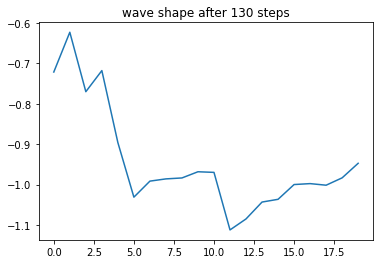

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_130/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_130/model_weights.tf
generator loss:1.3800727749729202
-----------------------


  8%|▊         | 131/1562 [07:33<1:51:38,  4.68s/it]

total discriminator loss:0.4210688684958238
average true return:0.5032920607261964
-----------------------
Training Step: 131
generator loss:1.4265997542018791
-----------------------


  8%|▊         | 132/1562 [07:35<1:30:37,  3.80s/it]

total discriminator loss:0.444462910610927
average true return:0.4986101500727902
-----------------------
Training Step: 132
generator loss:1.477783434987469
-----------------------


  9%|▊         | 133/1562 [07:37<1:15:55,  3.19s/it]

total discriminator loss:0.43490430968358496
average true return:0.48677919461631447
-----------------------
Training Step: 133
generator loss:1.4341950229767009
-----------------------


  9%|▊         | 134/1562 [07:39<1:05:36,  2.76s/it]

total discriminator loss:0.44031743221908176
average true return:0.5121708755256156
-----------------------
Training Step: 134
generator loss:1.4129718028657394
-----------------------


  9%|▊         | 135/1562 [07:40<58:22,  2.45s/it]  

total discriminator loss:0.41726270548694816
average true return:0.49346199909373367
-----------------------
Training Step: 135
event_types: [1, 2, 1, 3, 1, 3, 1, 3, 2, 3, 1, 0, 1, 1, 2, 2, 1, 3, 0, 1]
mad_score: 0.803425
fid_score: 14469.41758089856
rule_score: 0.07925


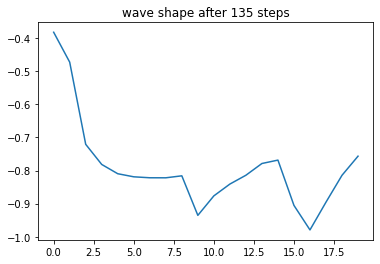

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_135/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_135/model_weights.tf
generator loss:1.4539118582944928
-----------------------


  9%|▊         | 136/1562 [07:50<1:51:36,  4.70s/it]

total discriminator loss:0.4806051897048369
average true return:0.5021154697682897
-----------------------
Training Step: 136
generator loss:1.4174631160095417
-----------------------


  9%|▉         | 137/1562 [07:52<1:30:29,  3.81s/it]

total discriminator loss:0.4317104863324864
average true return:0.5139277487306357
-----------------------
Training Step: 137
generator loss:1.361308929689034
-----------------------


  9%|▉         | 138/1562 [07:54<1:15:46,  3.19s/it]

total discriminator loss:0.45987936043225053
average true return:0.5006658744176322
-----------------------
Training Step: 138
generator loss:1.3440098541329468
-----------------------


  9%|▉         | 139/1562 [07:56<1:05:24,  2.76s/it]

total discriminator loss:0.4109459045944159
average true return:0.5105327614728506
-----------------------
Training Step: 139
generator loss:1.382936015579686
-----------------------


  9%|▉         | 140/1562 [07:57<58:11,  2.46s/it]  

total discriminator loss:0.4307989307297996
average true return:0.5062538030393346
-----------------------
Training Step: 140
event_types: [3, 3, 2, 1, 0, 1, 2, 1, 1, 1, 1, 0, 2, 1, 2, 1, 3, 1, 0, 0]
mad_score: 0.80165
fid_score: 11792.550924466705
rule_score: 0.31725


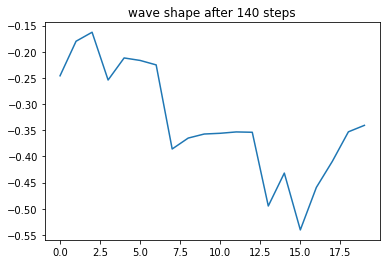

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_140/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_140/model_weights.tf
generator loss:1.3637542261835598
-----------------------


  9%|▉         | 141/1562 [08:07<1:52:34,  4.75s/it]

total discriminator loss:0.45840051189878583
average true return:0.5009914859191125
-----------------------
Training Step: 141
generator loss:1.3346155587402837
-----------------------


  9%|▉         | 142/1562 [08:09<1:31:13,  3.85s/it]

total discriminator loss:0.4619204624130706
average true return:0.5045756277003313
-----------------------
Training Step: 142
generator loss:1.3526658954696402
-----------------------


  9%|▉         | 143/1562 [08:11<1:17:08,  3.26s/it]

total discriminator loss:0.4481611975385696
average true return:0.5253381657902361
-----------------------
Training Step: 143
generator loss:1.3639472648112054
-----------------------


  9%|▉         | 144/1562 [08:13<1:06:37,  2.82s/it]

total discriminator loss:0.5153017087602338
average true return:0.5020675196294366
-----------------------
Training Step: 144
generator loss:1.3617033232722764
-----------------------


  9%|▉         | 145/1562 [08:15<59:04,  2.50s/it]  

total discriminator loss:0.4992090548103931
average true return:0.4891175681156853
-----------------------
Training Step: 145
event_types: [3, 2, 0, 3, 0, 1, 1, 3, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0, 1, 0]
mad_score: 0.7946125
fid_score: 10140.870299435957
rule_score: 0.3185


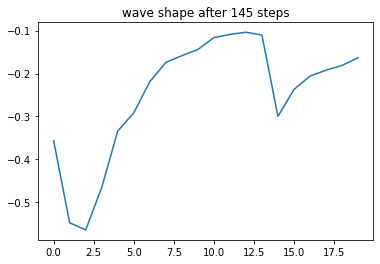

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_145/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_145/model_weights.tf
generator loss:1.3588499197708495
-----------------------


  9%|▉         | 146/1562 [08:25<1:52:22,  4.76s/it]

total discriminator loss:0.48180179656024036
average true return:0.4869911662276255
-----------------------
Training Step: 146
generator loss:1.3793371089150355
-----------------------


  9%|▉         | 147/1562 [08:26<1:30:59,  3.86s/it]

total discriminator loss:0.5569955199207307
average true return:0.46172043300398846
-----------------------
Training Step: 147
generator loss:1.333369963097149
-----------------------


  9%|▉         | 148/1562 [08:28<1:16:00,  3.22s/it]

total discriminator loss:0.4953399220562866
average true return:0.493663319877769
-----------------------
Training Step: 148
generator loss:1.3391671512756587
-----------------------


 10%|▉         | 149/1562 [08:30<1:05:29,  2.78s/it]

total discriminator loss:0.5179285297767995
average true return:0.483503302518986
-----------------------
Training Step: 149
generator loss:1.320215166668393
-----------------------


 10%|▉         | 150/1562 [08:32<58:09,  2.47s/it]  

total discriminator loss:0.5416080059861462
average true return:0.46958609187425515
-----------------------
Training Step: 150
event_types: [2, 2, 3, 3, 2, 2, 1, 3, 1, 0, 3, 0, 1, 1, 3, 0, 3, 3, 2, 1]
mad_score: 0.7875
fid_score: 9463.539256544978
rule_score: 0.31475


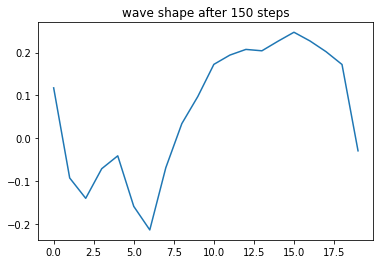

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_150/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_150/model_weights.tf
generator loss:1.3030920616703476
-----------------------


 10%|▉         | 151/1562 [08:42<1:51:36,  4.75s/it]

total discriminator loss:0.5595329827347797
average true return:0.4748280330349607
-----------------------
Training Step: 151
generator loss:1.209829062754924
-----------------------


 10%|▉         | 152/1562 [08:43<1:30:25,  3.85s/it]

total discriminator loss:0.5449435686368396
average true return:0.5055869905236152
-----------------------
Training Step: 152
generator loss:1.1894728678411384
-----------------------


 10%|▉         | 153/1562 [08:45<1:15:31,  3.22s/it]

total discriminator loss:0.582088578482538
average true return:0.48257672741234425
-----------------------
Training Step: 153
generator loss:1.1297176204320656
-----------------------


 10%|▉         | 154/1562 [08:47<1:05:08,  2.78s/it]

total discriminator loss:0.549688246762373
average true return:0.5319044973220632
-----------------------
Training Step: 154
generator loss:1.1407295445700192
-----------------------


 10%|▉         | 155/1562 [08:49<57:52,  2.47s/it]  

total discriminator loss:0.5585189435442635
average true return:0.5341894300643861
-----------------------
Training Step: 155
event_types: [3, 3, 3, 2, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1]
mad_score: 0.7752375
fid_score: 9581.347643697889
rule_score: 0.29975


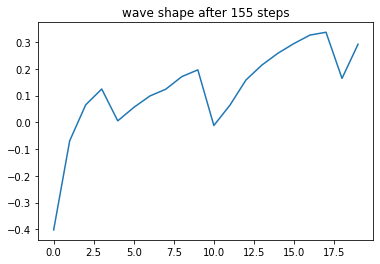

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_155/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_155/model_weights.tf
generator loss:1.1021656561320774
-----------------------


 10%|▉         | 156/1562 [08:59<1:51:45,  4.77s/it]

total discriminator loss:0.5653672546744865
average true return:0.5206142663227185
-----------------------
Training Step: 156
generator loss:1.1617573200691382
-----------------------


 10%|█         | 157/1562 [09:01<1:30:28,  3.86s/it]

total discriminator loss:0.5454147428806025
average true return:0.5156787269020692
-----------------------
Training Step: 157
generator loss:1.1132730623194835
-----------------------


 10%|█         | 158/1562 [09:02<1:15:34,  3.23s/it]

total discriminator loss:0.5475799028962662
average true return:0.4918176919043082
-----------------------
Training Step: 158
generator loss:1.184846959655122
-----------------------


 10%|█         | 159/1562 [09:04<1:05:18,  2.79s/it]

total discriminator loss:0.5831822323289911
average true return:0.4974896985889349
-----------------------
Training Step: 159
generator loss:1.1569749699920582
-----------------------


 10%|█         | 160/1562 [09:06<58:08,  2.49s/it]  

total discriminator loss:0.5560544814158719
average true return:0.4929228856780562
-----------------------
Training Step: 160
event_types: [0, 3, 2, 0, 1, 1, 3, 3, 3, 3, 0, 1, 1, 3, 1, 1, 1, 2, 1, 2]
mad_score: 0.7599375
fid_score: 10279.211856925342
rule_score: 0.30125


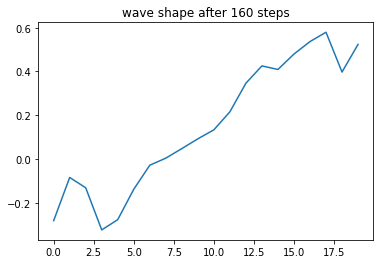

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_160/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_160/model_weights.tf
generator loss:1.172462643587953
-----------------------


 10%|█         | 161/1562 [09:16<1:51:23,  4.77s/it]

total discriminator loss:0.5964712227727575
average true return:0.47146935492198117
-----------------------
Training Step: 161
generator loss:1.1639783382244264
-----------------------


 10%|█         | 162/1562 [09:18<1:30:07,  3.86s/it]

total discriminator loss:0.5525918955176339
average true return:0.4851785246498962
-----------------------
Training Step: 162
generator loss:1.1346687590626026
-----------------------


 10%|█         | 163/1562 [09:19<1:15:14,  3.23s/it]

total discriminator loss:0.5592397865973966
average true return:0.5002746833576561
-----------------------
Training Step: 163
generator loss:1.117553445316486
-----------------------


 10%|█         | 164/1562 [09:21<1:04:49,  2.78s/it]

total discriminator loss:0.5593494665912441
average true return:0.5129583939040527
-----------------------
Training Step: 164
generator loss:1.1021017832818667
-----------------------


 11%|█         | 165/1562 [09:23<57:37,  2.48s/it]  

total discriminator loss:0.5718657109555985
average true return:0.4879360970252772
-----------------------
Training Step: 165
event_types: [1, 1, 3, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 1, 0, 0, 1, 1, 3, 1]
mad_score: 0.7442125
fid_score: 11432.100658956138
rule_score: 0.32225


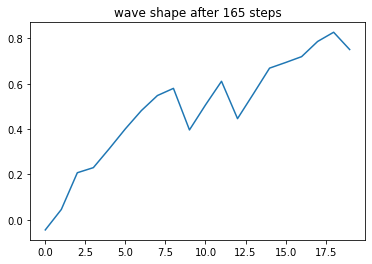

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_165/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_165/model_weights.tf
generator loss:1.116478704668967
-----------------------


 11%|█         | 166/1562 [09:33<1:50:20,  4.74s/it]

total discriminator loss:0.568341160283391
average true return:0.5307707554478049
-----------------------
Training Step: 166
generator loss:1.0919024574423726
-----------------------


 11%|█         | 167/1562 [09:35<1:29:28,  3.85s/it]

total discriminator loss:0.5681632840079429
average true return:0.5400366045932814
-----------------------
Training Step: 167
generator loss:1.0070028087303875
-----------------------


 11%|█         | 168/1562 [09:36<1:14:46,  3.22s/it]

total discriminator loss:0.5230291749078959
average true return:0.5250878568082997
-----------------------
Training Step: 168
generator loss:1.0754805184060023
-----------------------


 11%|█         | 169/1562 [09:38<1:04:25,  2.77s/it]

total discriminator loss:0.5291972524658681
average true return:0.5633501449106438
-----------------------
Training Step: 169
generator loss:1.0456935813515633
-----------------------


 11%|█         | 170/1562 [09:40<57:11,  2.47s/it]  

total discriminator loss:0.5217386414349909
average true return:0.5381490955873723
-----------------------
Training Step: 170
event_types: [2, 1, 3, 2, 1, 3, 2, 2, 0, 1, 0, 0, 1, 1, 2, 3, 1, 2, 2, 1]
mad_score: 0.7299625
fid_score: 12845.484398175331
rule_score: 0.33375


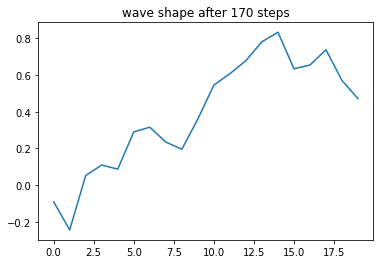

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_170/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_170/model_weights.tf
generator loss:1.1902394868613904
-----------------------


 11%|█         | 171/1562 [09:50<1:50:50,  4.78s/it]

total discriminator loss:0.5282511786580577
average true return:0.5288213915638769
-----------------------
Training Step: 171
generator loss:1.192549045788113
-----------------------


 11%|█         | 172/1562 [09:52<1:29:43,  3.87s/it]

total discriminator loss:0.5081956750947755
average true return:0.5182638593744741
-----------------------
Training Step: 172
generator loss:1.210970661707878
-----------------------


 11%|█         | 173/1562 [09:54<1:14:57,  3.24s/it]

total discriminator loss:0.49702572543244694
average true return:0.5101204401951367
-----------------------
Training Step: 173
generator loss:1.239076452674181
-----------------------


 11%|█         | 174/1562 [09:55<1:04:33,  2.79s/it]

total discriminator loss:0.49068125793742406
average true return:0.5151605299574905
-----------------------
Training Step: 174
generator loss:1.2564125211587078
-----------------------


 11%|█         | 175/1562 [09:57<57:13,  2.48s/it]  

total discriminator loss:0.47237744192469505
average true return:0.5203240157375297
-----------------------
Training Step: 175
event_types: [2, 2, 2, 2, 3, 1, 3, 1, 2, 3, 2, 1, 0, 1, 1, 0, 3, 2, 2, 0]
mad_score: 0.7051125
fid_score: 14243.826500870704
rule_score: 0.3565


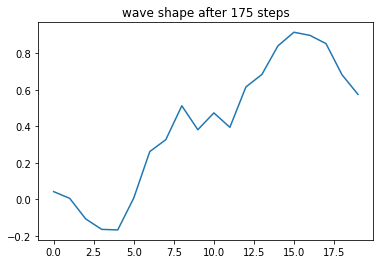

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_175/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_175/model_weights.tf
generator loss:1.3198479365724554
-----------------------


 11%|█▏        | 176/1562 [10:07<1:49:42,  4.75s/it]

total discriminator loss:1.2219908694855666
average true return:0.5008341119682321
-----------------------
Training Step: 176
generator loss:1.4180270964050092
-----------------------


 11%|█▏        | 177/1562 [10:09<1:28:50,  3.85s/it]

total discriminator loss:0.4400188955983742
average true return:0.5088969942057567
-----------------------
Training Step: 177
generator loss:1.401170388505969
-----------------------


 11%|█▏        | 178/1562 [10:11<1:14:18,  3.22s/it]

total discriminator loss:0.44182451315162713
average true return:0.49677900546458265
-----------------------
Training Step: 178
generator loss:1.4428853426997719
-----------------------


 11%|█▏        | 179/1562 [10:12<1:04:02,  2.78s/it]

total discriminator loss:0.44237985276372316
average true return:0.4658630804232523
-----------------------
Training Step: 179
generator loss:1.4920527623675277
-----------------------


 12%|█▏        | 180/1562 [10:14<56:54,  2.47s/it]  

total discriminator loss:0.4434514386466313
average true return:0.4910442988241718
-----------------------
Training Step: 180
event_types: [1, 1, 1, 1, 0, 0, 0, 1, 0, 2, 1, 2, 1, 2, 3, 2, 2, 3, 1, 3]
mad_score: 0.68095
fid_score: 15409.982596300011
rule_score: 0.38275


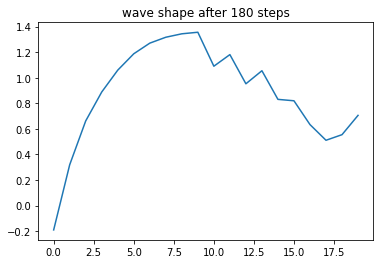

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_180/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_180/model_weights.tf
generator loss:1.4843828219632669
-----------------------


 12%|█▏        | 181/1562 [10:24<1:49:14,  4.75s/it]

total discriminator loss:0.44077089473439013
average true return:0.4795750637497435
-----------------------
Training Step: 181
generator loss:1.5496336151530024
-----------------------


 12%|█▏        | 182/1562 [10:26<1:28:25,  3.84s/it]

total discriminator loss:0.4546065318639264
average true return:0.49524398438905504
-----------------------
Training Step: 182
generator loss:1.4746938336669457
-----------------------


 12%|█▏        | 183/1562 [10:28<1:13:54,  3.22s/it]

total discriminator loss:0.42424061840049765
average true return:0.5045846155758154
-----------------------
Training Step: 183
generator loss:1.4162824216669239
-----------------------


 12%|█▏        | 184/1562 [10:29<1:03:45,  2.78s/it]

total discriminator loss:0.42445532159721283
average true return:0.5157181873583444
-----------------------
Training Step: 184
generator loss:1.5111946961896148
-----------------------


 12%|█▏        | 185/1562 [10:31<56:35,  2.47s/it]  

total discriminator loss:1.3578602269611721
average true return:0.5228354491434756
-----------------------
Training Step: 185
event_types: [0, 2, 1, 1, 1, 2, 0, 1, 3, 2, 1, 2, 2, 2, 0, 0, 0, 1, 3, 0]
mad_score: 0.656025
fid_score: 16207.432161004537
rule_score: 0.42675


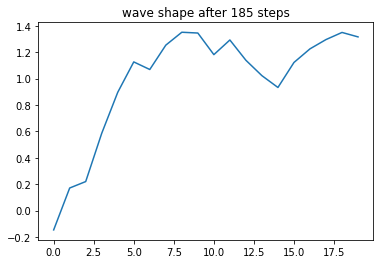

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_185/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_185/model_weights.tf
generator loss:1.4354029129233867
-----------------------


 12%|█▏        | 186/1562 [10:41<1:49:44,  4.78s/it]

total discriminator loss:0.4061715721216723
average true return:0.5145684423614362
-----------------------
Training Step: 186
generator loss:1.5118895861181048
-----------------------


 12%|█▏        | 187/1562 [10:43<1:28:51,  3.88s/it]

total discriminator loss:0.37782683183400245
average true return:0.5045491666583048
-----------------------
Training Step: 187
generator loss:1.493777503195212
-----------------------


 12%|█▏        | 188/1562 [10:45<1:14:13,  3.24s/it]

total discriminator loss:0.410950298610502
average true return:0.5040659859593459
-----------------------
Training Step: 188
generator loss:1.4514304740325699
-----------------------


 12%|█▏        | 189/1562 [10:47<1:03:56,  2.79s/it]

total discriminator loss:0.40811783719971606
average true return:0.5129081576026571
-----------------------
Training Step: 189
generator loss:1.5244315854877786
-----------------------


 12%|█▏        | 190/1562 [10:48<56:43,  2.48s/it]  

total discriminator loss:0.393051031622961
average true return:0.5147117148792079
-----------------------
Training Step: 190
event_types: [2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 3, 2, 1, 0, 2, 0, 1, 0, 1, 2]
mad_score: 0.6321875
fid_score: 16353.999546319086
rule_score: 0.4315


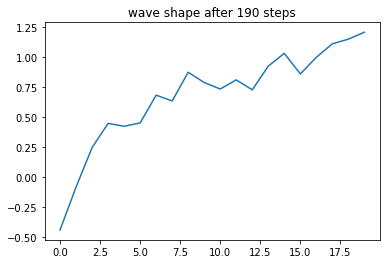

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_190/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_190/model_weights.tf
generator loss:1.575106435132895
-----------------------


 12%|█▏        | 191/1562 [10:59<1:48:47,  4.76s/it]

total discriminator loss:0.38483668272826543
average true return:0.5056750081610817
-----------------------
Training Step: 191
generator loss:1.5676152039639406
-----------------------


 12%|█▏        | 192/1562 [11:00<1:28:07,  3.86s/it]

total discriminator loss:0.40375047539133946
average true return:0.4878136172197234
-----------------------
Training Step: 192
generator loss:1.6134756981594454
-----------------------


 12%|█▏        | 193/1562 [11:02<1:13:40,  3.23s/it]

total discriminator loss:1.3415375897827024
average true return:0.48191623602903033
-----------------------
Training Step: 193
generator loss:1.59834287595971
-----------------------


 12%|█▏        | 194/1562 [11:04<1:03:31,  2.79s/it]

total discriminator loss:1.4221643976994782
average true return:0.47645651618949303
-----------------------
Training Step: 194
generator loss:1.6403159680147708
-----------------------


 12%|█▏        | 195/1562 [11:06<56:23,  2.47s/it]  

total discriminator loss:0.4087641295768047
average true return:0.46094349331669954
-----------------------
Training Step: 195
event_types: [3, 1, 2, 2, 2, 2, 1, 2, 3, 1, 1, 0, 3, 2, 1, 2, 0, 0, 0, 0]
mad_score: 0.6089375
fid_score: 16072.817891314939
rule_score: 0.46725


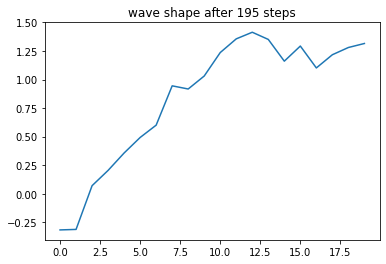

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_195/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_195/model_weights.tf
generator loss:1.6246657829054783
-----------------------


 13%|█▎        | 196/1562 [11:16<1:48:05,  4.75s/it]

total discriminator loss:0.4234336729190167
average true return:0.4497443805076513
-----------------------
Training Step: 196
generator loss:1.5971863608802443
-----------------------


 13%|█▎        | 197/1562 [11:17<1:27:33,  3.85s/it]

total discriminator loss:0.4090738230223949
average true return:0.46676755970345607
-----------------------
Training Step: 197
generator loss:1.5376956991447734
-----------------------


 13%|█▎        | 198/1562 [11:19<1:13:11,  3.22s/it]

total discriminator loss:0.4072653674503215
average true return:0.48307948886283497
-----------------------
Training Step: 198
generator loss:1.4794930668292965
-----------------------


 13%|█▎        | 199/1562 [11:21<1:03:05,  2.78s/it]

total discriminator loss:0.41865951820575265
average true return:0.48935402253069926
-----------------------
Training Step: 199
generator loss:1.4897361410487973
-----------------------


 13%|█▎        | 200/1562 [11:23<56:04,  2.47s/it]  

total discriminator loss:0.3936208797016083
average true return:0.5024252786005965
-----------------------
Training Step: 200
event_types: [2, 2, 0, 2, 2, 0, 2, 2, 2, 3, 1, 3, 2, 1, 0, 1, 3, 2, 2, 0]
mad_score: 0.5916875
fid_score: 15445.05766471125
rule_score: 0.49175


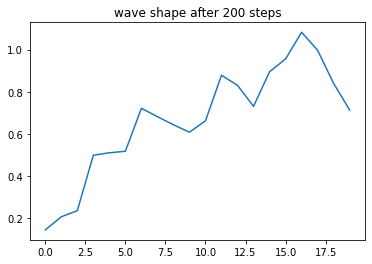

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_200/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_200/model_weights.tf
generator loss:1.4576053821456143
-----------------------


 13%|█▎        | 201/1562 [11:33<1:48:32,  4.79s/it]

total discriminator loss:0.38460727764381303
average true return:0.51350397341578
-----------------------
Training Step: 201
generator loss:1.3570764945982043
-----------------------


 13%|█▎        | 202/1562 [11:35<1:27:51,  3.88s/it]

total discriminator loss:0.41168146897832214
average true return:0.5298289114616995
-----------------------
Training Step: 202
generator loss:1.3548131046678344
-----------------------


 13%|█▎        | 203/1562 [11:36<1:13:21,  3.24s/it]

total discriminator loss:0.41151020529377097
average true return:0.5452438862801434
-----------------------
Training Step: 203
generator loss:1.3706038905994449
-----------------------


 13%|█▎        | 204/1562 [11:38<1:03:14,  2.79s/it]

total discriminator loss:0.3995626769766928
average true return:0.5317037509995685
-----------------------
Training Step: 204
generator loss:1.4103295238146458
-----------------------


 13%|█▎        | 205/1562 [11:40<56:16,  2.49s/it]  

total discriminator loss:0.41862723857034423
average true return:0.5289152361952467
-----------------------
Training Step: 205
event_types: [3, 0, 0, 1, 1, 0, 0, 1, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 3]
mad_score: 0.5742375
fid_score: 14706.291249098736
rule_score: 0.5045


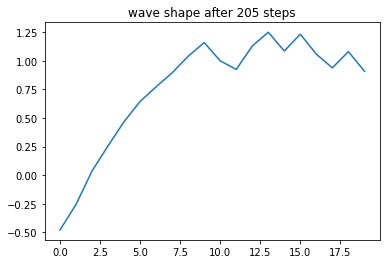

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_205/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_205/model_weights.tf
generator loss:1.4411650463923429
-----------------------


 13%|█▎        | 206/1562 [11:50<1:49:14,  4.83s/it]

total discriminator loss:0.3979321665120737
average true return:0.5230321282113342
-----------------------
Training Step: 206
generator loss:1.4663626512925498
-----------------------


 13%|█▎        | 207/1562 [11:52<1:28:16,  3.91s/it]

total discriminator loss:0.39284385225163837
average true return:0.5075851493665104
-----------------------
Training Step: 207
generator loss:1.5061452863323836
-----------------------


 13%|█▎        | 208/1562 [11:54<1:13:38,  3.26s/it]

total discriminator loss:0.37035261905295547
average true return:0.5046768903293299
-----------------------
Training Step: 208
generator loss:1.5109103591449775
-----------------------


 13%|█▎        | 209/1562 [11:55<1:03:22,  2.81s/it]

total discriminator loss:0.38751065551674513
average true return:0.4934599767095229
-----------------------
Training Step: 209
generator loss:1.5539192655379397
-----------------------


 13%|█▎        | 210/1562 [11:57<56:08,  2.49s/it]  

total discriminator loss:0.3843767750417464
average true return:0.494401113226108
-----------------------
Training Step: 210
event_types: [1, 0, 2, 0, 2, 2, 0, 2, 2, 0, 1, 3, 2, 0, 2, 0, 2, 3, 3, 2]
mad_score: 0.559975
fid_score: 13685.41075723328
rule_score: 0.52


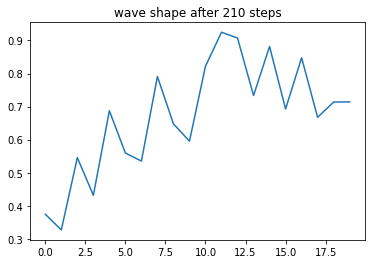

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_210/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_210/model_weights.tf
generator loss:1.5741000014149948
-----------------------


 14%|█▎        | 211/1562 [12:07<1:47:14,  4.76s/it]

total discriminator loss:0.4059379569881699
average true return:0.4923790379957792
-----------------------
Training Step: 211
generator loss:1.5502166394833594
-----------------------


 14%|█▎        | 212/1562 [12:09<1:26:49,  3.86s/it]

total discriminator loss:0.3838711397027224
average true return:0.49352913233494766
-----------------------
Training Step: 212
generator loss:1.5623005297715142
-----------------------


 14%|█▎        | 213/1562 [12:11<1:12:39,  3.23s/it]

total discriminator loss:0.353697241770688
average true return:0.5057514924509212
-----------------------
Training Step: 213
generator loss:1.547180623890586
-----------------------


 14%|█▎        | 214/1562 [12:13<1:02:58,  2.80s/it]

total discriminator loss:0.3670926320507605
average true return:0.515037960298092
-----------------------
Training Step: 214
generator loss:1.5741279038516431
-----------------------


 14%|█▍        | 215/1562 [12:14<55:50,  2.49s/it]  

total discriminator loss:0.38911938793143086
average true return:0.5024685257628326
-----------------------
Training Step: 215
event_types: [2, 2, 2, 2, 2, 0, 3, 0, 1, 2, 2, 2, 3, 1, 0, 1, 0, 0, 2, 0]
mad_score: 0.5494
fid_score: 12631.164230086582
rule_score: 0.51375


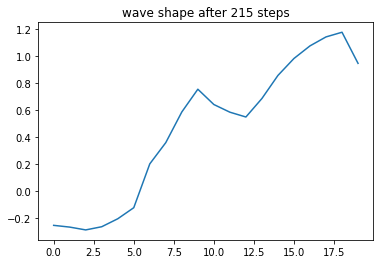

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_215/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_215/model_weights.tf
generator loss:1.591174934868064
-----------------------


 14%|█▍        | 216/1562 [12:24<1:47:24,  4.79s/it]

total discriminator loss:0.4000468235831057
average true return:0.5056643946697921
-----------------------
Training Step: 216
generator loss:1.6310698335553115
-----------------------


 14%|█▍        | 217/1562 [12:26<1:26:53,  3.88s/it]

total discriminator loss:0.36512683017805636
average true return:0.5071117966171858
-----------------------
Training Step: 217
generator loss:1.5764834918107804
-----------------------


 14%|█▍        | 218/1562 [12:28<1:12:36,  3.24s/it]

total discriminator loss:0.3731962585917324
average true return:0.4979528133853115
-----------------------
Training Step: 218
generator loss:1.6194091986425405
-----------------------


 14%|█▍        | 219/1562 [12:30<1:03:35,  2.84s/it]

total discriminator loss:0.38333548506827547
average true return:0.49925393296620135
-----------------------
Training Step: 219
generator loss:1.7054222743416787
-----------------------


 14%|█▍        | 220/1562 [12:32<56:15,  2.52s/it]  

total discriminator loss:1.5502211604836638
average true return:0.5038134822589084
-----------------------
Training Step: 220
event_types: [0, 1, 1, 1, 0, 2, 2, 2, 1, 2, 0, 3, 2, 2, 2, 1, 1, 2, 2, 2]
mad_score: 0.5428125
fid_score: 11542.15504139023
rule_score: 0.5395


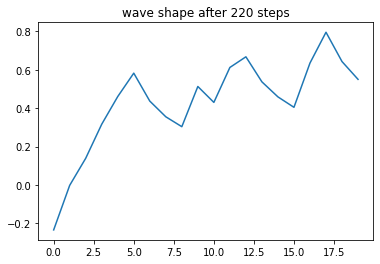

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_220/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_220/model_weights.tf
generator loss:1.6339720965221778
-----------------------


 14%|█▍        | 221/1562 [12:42<1:47:23,  4.80s/it]

total discriminator loss:0.397611107136044
average true return:0.4951921663958625
-----------------------
Training Step: 221
generator loss:1.6792697807138086
-----------------------


 14%|█▍        | 222/1562 [12:44<1:26:57,  3.89s/it]

total discriminator loss:0.3644725247512811
average true return:0.4897161222701002
-----------------------
Training Step: 222
generator loss:1.7084037633398927
-----------------------


 14%|█▍        | 223/1562 [12:45<1:12:32,  3.25s/it]

total discriminator loss:0.37392671192744054
average true return:0.483455974437097
-----------------------
Training Step: 223
generator loss:1.6820799605180063
-----------------------


 14%|█▍        | 224/1562 [12:47<1:02:31,  2.80s/it]

total discriminator loss:0.36910863108366937
average true return:0.48282378657228797
-----------------------
Training Step: 224
generator loss:1.67748950951723
-----------------------


 14%|█▍        | 225/1562 [12:49<55:25,  2.49s/it]  

total discriminator loss:0.37938067037175016
average true return:0.5082986371836831
-----------------------
Training Step: 225
event_types: [1, 1, 0, 3, 2, 3, 2, 0, 2, 3, 0, 2, 2, 2, 3, 1, 3, 2, 1, 1]
mad_score: 0.5435875
fid_score: 10610.636959799214
rule_score: 0.51875


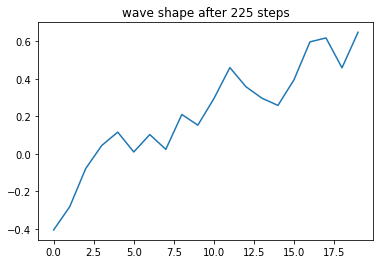

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_225/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_225/model_weights.tf
generator loss:1.629389385740054
-----------------------


 14%|█▍        | 226/1562 [12:59<1:45:45,  4.75s/it]

total discriminator loss:0.3652608036018674
average true return:0.5004285764364221
-----------------------
Training Step: 226
generator loss:1.5745074857765597
-----------------------


 15%|█▍        | 227/1562 [13:01<1:25:37,  3.85s/it]

total discriminator loss:0.3659156083553321
average true return:0.5103351209082835
-----------------------
Training Step: 227
generator loss:1.6030762565034218
-----------------------


 15%|█▍        | 228/1562 [13:02<1:11:32,  3.22s/it]

total discriminator loss:0.3631095430422772
average true return:0.49913417479980415
-----------------------
Training Step: 228
generator loss:1.5852479428362196
-----------------------


 15%|█▍        | 229/1562 [13:04<1:01:43,  2.78s/it]

total discriminator loss:0.38290244298517706
average true return:0.5251908223438405
-----------------------
Training Step: 229
generator loss:1.621493234408058
-----------------------


 15%|█▍        | 230/1562 [13:06<54:47,  2.47s/it]  

total discriminator loss:0.36280126600665835
average true return:0.505796257461193
-----------------------
Training Step: 230
event_types: [1, 3, 3, 2, 2, 2, 1, 0, 0, 3, 0, 1, 2, 0, 2, 2, 3, 2, 3, 2]
mad_score: 0.541375
fid_score: 9810.672763721497
rule_score: 0.546


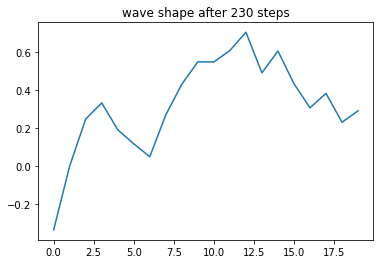

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_230/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_230/model_weights.tf
generator loss:1.6327636804720038
-----------------------


 15%|█▍        | 231/1562 [13:16<1:45:55,  4.77s/it]

total discriminator loss:0.38730189223075384
average true return:0.5123721621779138
-----------------------
Training Step: 231
generator loss:1.679647262778648
-----------------------


 15%|█▍        | 232/1562 [13:18<1:25:45,  3.87s/it]

total discriminator loss:0.37114292370770474
average true return:0.4926127975234151
-----------------------
Training Step: 232
generator loss:1.7193194110028704
-----------------------


 15%|█▍        | 233/1562 [13:19<1:11:36,  3.23s/it]

total discriminator loss:0.3837723244953314
average true return:0.4879743303178172
-----------------------
Training Step: 233
generator loss:1.7046160649747826
-----------------------


 15%|█▍        | 234/1562 [13:21<1:01:40,  2.79s/it]

total discriminator loss:0.37165153186103306
average true return:0.48948636094873044
-----------------------
Training Step: 234
generator loss:1.7063235758306883
-----------------------


 15%|█▌        | 235/1562 [13:23<54:43,  2.47s/it]  

total discriminator loss:0.3836767341674181
average true return:0.5041857298148089
-----------------------
Training Step: 235
event_types: [1, 0, 2, 0, 2, 3, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 3, 0, 3]
mad_score: 0.5427875
fid_score: 9111.529828517883
rule_score: 0.55875


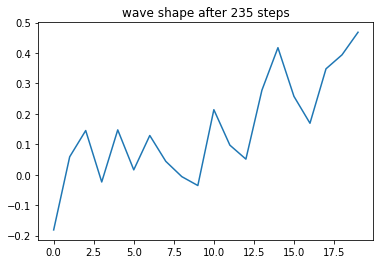

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_235/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_235/model_weights.tf
generator loss:1.6801212683601514
-----------------------


 15%|█▌        | 236/1562 [13:33<1:45:04,  4.75s/it]

total discriminator loss:0.36304994748576747
average true return:0.5096956080254579
-----------------------
Training Step: 236
generator loss:1.6891972584251875
-----------------------


 15%|█▌        | 237/1562 [13:35<1:25:06,  3.85s/it]

total discriminator loss:0.3821368176142394
average true return:0.49651458722598846
-----------------------
Training Step: 237
generator loss:1.6483923655005808
-----------------------


 15%|█▌        | 238/1562 [13:37<1:11:04,  3.22s/it]

total discriminator loss:0.38135149289717324
average true return:0.5092989552645497
-----------------------
Training Step: 238
generator loss:1.637387332352757
-----------------------


 15%|█▌        | 239/1562 [13:38<1:01:17,  2.78s/it]

total discriminator loss:0.38094526720241295
average true return:0.5056269441196497
-----------------------
Training Step: 239
generator loss:1.6298686709585264
-----------------------


 15%|█▌        | 240/1562 [13:40<54:22,  2.47s/it]  

total discriminator loss:0.3489387407832598
average true return:0.5100075724214934
-----------------------
Training Step: 240
event_types: [2, 0, 2, 1, 1, 2, 0, 2, 1, 2, 2, 3, 2, 2, 2, 3, 0, 0, 2, 1]
mad_score: 0.554575
fid_score: 8700.08743783542
rule_score: 0.5165


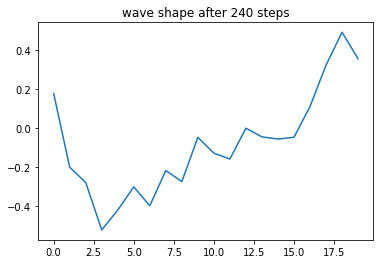

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_240/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_240/model_weights.tf
generator loss:1.673537843842524
-----------------------


 15%|█▌        | 241/1562 [13:50<1:44:26,  4.74s/it]

total discriminator loss:0.3480867137484921
average true return:0.5095563887804194
-----------------------
Training Step: 241
generator loss:1.710840458716134
-----------------------


 15%|█▌        | 242/1562 [13:52<1:24:35,  3.84s/it]

total discriminator loss:0.3428540952250947
average true return:0.5138562232093435
-----------------------
Training Step: 242
generator loss:1.6945787390416016
-----------------------


 16%|█▌        | 243/1562 [13:54<1:10:46,  3.22s/it]

total discriminator loss:0.33880128026953044
average true return:0.5104696526396338
-----------------------
Training Step: 243
generator loss:1.7802870333364136
-----------------------


 16%|█▌        | 244/1562 [13:55<1:00:59,  2.78s/it]

total discriminator loss:0.3685600786348301
average true return:0.5035162739528297
-----------------------
Training Step: 244
generator loss:1.7941081486686288
-----------------------


 16%|█▌        | 245/1562 [13:57<54:11,  2.47s/it]  

total discriminator loss:0.3503188444463103
average true return:0.49461947974155396
-----------------------
Training Step: 245
event_types: [0, 2, 2, 2, 1, 3, 2, 2, 2, 0, 1, 2, 1, 0, 3, 2, 3, 3, 0, 2]
mad_score: 0.5571
fid_score: 8481.508137957493
rule_score: 0.51275


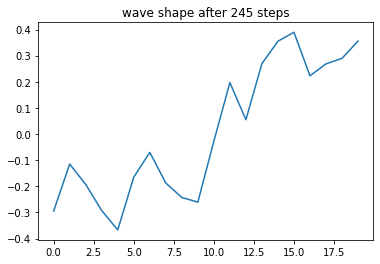

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_245/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_245/model_weights.tf
generator loss:1.780552284447784
-----------------------


 16%|█▌        | 246/1562 [14:07<1:44:47,  4.78s/it]

total discriminator loss:0.3575609529133444
average true return:0.4927274127882785
-----------------------
Training Step: 246
generator loss:1.817653659489015
-----------------------


 16%|█▌        | 247/1562 [14:09<1:24:55,  3.87s/it]

total discriminator loss:0.36062640915080674
average true return:0.4960075228621744
-----------------------
Training Step: 247
generator loss:1.8082711161626572
-----------------------


 16%|█▌        | 248/1562 [14:11<1:11:04,  3.25s/it]

total discriminator loss:0.358375365783891
average true return:0.4953229486055418
-----------------------
Training Step: 248
generator loss:1.777680130139636
-----------------------


 16%|█▌        | 249/1562 [14:13<1:01:24,  2.81s/it]

total discriminator loss:0.3614454294898884
average true return:0.5068677306765395
-----------------------
Training Step: 249
generator loss:1.7653639700964345
-----------------------


 16%|█▌        | 250/1562 [14:14<54:29,  2.49s/it]  

total discriminator loss:0.33897339707103824
average true return:0.5075646877896118
-----------------------
Training Step: 250
event_types: [1, 3, 2, 2, 0, 2, 1, 2, 3, 3, 3, 3, 2, 1, 3, 0, 0, 2, 2, 2]
mad_score: 0.5676875
fid_score: 8400.060872610095
rule_score: 0.501


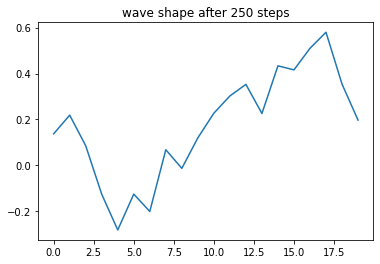

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_250/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_250/model_weights.tf
generator loss:1.757452911400865
-----------------------


 16%|█▌        | 251/1562 [14:24<1:43:57,  4.76s/it]

total discriminator loss:0.3703916246758069
average true return:0.5126493713714693
-----------------------
Training Step: 251
generator loss:1.7603629499594675
-----------------------


 16%|█▌        | 252/1562 [14:26<1:25:09,  3.90s/it]

total discriminator loss:0.34356267955871916
average true return:0.5145301178121922
-----------------------
Training Step: 252
generator loss:1.816384951136371
-----------------------


 16%|█▌        | 253/1562 [14:28<1:10:58,  3.25s/it]

total discriminator loss:0.38288808047322587
average true return:0.5166131554607512
-----------------------
Training Step: 253
generator loss:1.878171103278937
-----------------------


 16%|█▋        | 254/1562 [14:30<1:01:04,  2.80s/it]

total discriminator loss:0.33864305971899866
average true return:0.5100959862788971
-----------------------
Training Step: 254
generator loss:1.9359010948720101
-----------------------


 16%|█▋        | 255/1562 [14:31<54:10,  2.49s/it]  

total discriminator loss:0.3293325318741219
average true return:0.48564997399304144
-----------------------
Training Step: 255
event_types: [1, 2, 1, 1, 2, 3, 0, 2, 3, 2, 2, 3, 2, 2, 0, 0, 2, 3, 0, 3]
mad_score: 0.5794
fid_score: 8487.06169316574
rule_score: 0.4515


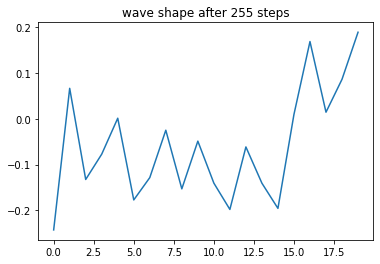

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_255/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_255/model_weights.tf
generator loss:1.9538821810403975
-----------------------


 16%|█▋        | 256/1562 [14:42<1:43:18,  4.75s/it]

total discriminator loss:0.3433239963261571
average true return:0.49239366452859684
-----------------------
Training Step: 256
generator loss:1.960635864289546
-----------------------


 16%|█▋        | 257/1562 [14:43<1:23:42,  3.85s/it]

total discriminator loss:0.34625421464930584
average true return:0.48147176156652705
-----------------------
Training Step: 257
generator loss:1.8948564002073494
-----------------------


 17%|█▋        | 258/1562 [14:45<1:10:00,  3.22s/it]

total discriminator loss:0.3314427299512108
average true return:0.4848132565160239
-----------------------
Training Step: 258
generator loss:1.827703324061475
-----------------------


 17%|█▋        | 259/1562 [14:47<1:00:26,  2.78s/it]

total discriminator loss:0.29977469831682774
average true return:0.508305634776224
-----------------------
Training Step: 259
generator loss:1.7754416586982487
-----------------------


 17%|█▋        | 260/1562 [14:49<53:38,  2.47s/it]  

total discriminator loss:0.3479682011525258
average true return:0.5175744405207474
-----------------------
Training Step: 260
event_types: [2, 2, 3, 3, 3, 2, 2, 2, 1, 3, 2, 1, 3, 2, 0, 2, 1, 1, 2, 1]
mad_score: 0.59485
fid_score: 8694.893959990915
rule_score: 0.42075


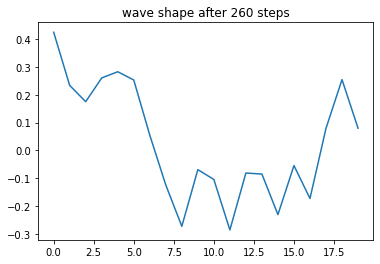

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_260/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_260/model_weights.tf
generator loss:1.7627090527810507
-----------------------


 17%|█▋        | 261/1562 [14:59<1:43:39,  4.78s/it]

total discriminator loss:0.33574712908089105
average true return:0.5220899767176285
-----------------------
Training Step: 261
generator loss:1.8245776436908654
-----------------------
total discriminator loss:0.36824406898550466
average true return:0.5089761519653118
-----------------------


 17%|█▋        | 262/1562 [15:01<1:25:52,  3.96s/it]

Training Step: 262
generator loss:1.880184269080198
-----------------------
total discriminator loss:0.37184297488947504
average true return:0.5079043101143244
-----------------------


 17%|█▋        | 263/1562 [15:03<1:16:23,  3.53s/it]

Training Step: 263
generator loss:1.9526093574473957
-----------------------
total discriminator loss:0.3260916990920425
average true return:0.5029731109703705
-----------------------


 17%|█▋        | 264/1562 [15:06<1:09:34,  3.22s/it]

Training Step: 264
generator loss:2.0380582755420993
-----------------------
total discriminator loss:0.3239350443421873
average true return:0.49020347473385617
-----------------------


 17%|█▋        | 265/1562 [15:08<1:04:52,  3.00s/it]

Training Step: 265
event_types: [3, 0, 2, 2, 1, 2, 0, 2, 2, 1, 3, 2, 2, 2, 3, 3, 2, 1, 1, 2]
mad_score: 0.6098875
fid_score: 8879.167067919127
rule_score: 0.35125


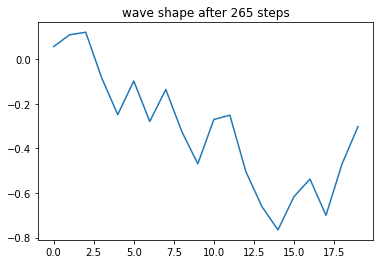

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_265/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_265/model_weights.tf
generator loss:2.0735099661001213
-----------------------
total discriminator loss:0.3359770966471937
average true return:0.47489606027254005
-----------------------


 17%|█▋        | 266/1562 [15:21<2:07:39,  5.91s/it]

Training Step: 266
generator loss:2.019207249869554
-----------------------
total discriminator loss:0.35444157780822005
average true return:0.48728180058042325
-----------------------


 17%|█▋        | 267/1562 [15:23<1:45:22,  4.88s/it]

Training Step: 267
generator loss:2.059097418562021
-----------------------
total discriminator loss:0.3496825995756805
average true return:0.4920182344089561
-----------------------


 17%|█▋        | 268/1562 [15:26<1:29:54,  4.17s/it]

Training Step: 268
generator loss:1.998624393827484
-----------------------


 17%|█▋        | 269/1562 [15:28<1:16:56,  3.57s/it]

total discriminator loss:0.3394561521911139
average true return:0.49940650274851256
-----------------------
Training Step: 269
generator loss:2.023234759199704
-----------------------


 17%|█▋        | 270/1562 [15:30<1:07:27,  3.13s/it]

total discriminator loss:0.3178225237356691
average true return:0.5077668604013688
-----------------------
Training Step: 270
event_types: [2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 3, 0, 1, 0, 2, 3, 3, 2]
mad_score: 0.6254875
fid_score: 9188.040942326386
rule_score: 0.3165


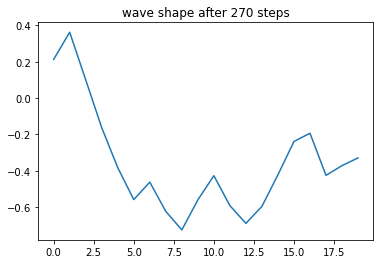

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_270/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_270/model_weights.tf
generator loss:1.944959633112994
-----------------------


 17%|█▋        | 271/1562 [15:41<1:56:00,  5.39s/it]

total discriminator loss:0.35391145578985206
average true return:0.5058189050734397
-----------------------
Training Step: 271
generator loss:2.029881604441683
-----------------------


 17%|█▋        | 272/1562 [15:43<1:32:22,  4.30s/it]

total discriminator loss:0.33021995024287376
average true return:0.5008533481000967
-----------------------
Training Step: 272
generator loss:2.040255201512217
-----------------------


 17%|█▋        | 273/1562 [15:44<1:15:55,  3.53s/it]

total discriminator loss:0.3281716850962027
average true return:0.496629070460201
-----------------------
Training Step: 273
generator loss:2.1061912592912226
-----------------------


 18%|█▊        | 274/1562 [15:46<1:04:24,  3.00s/it]

total discriminator loss:0.31690063151110337
average true return:0.48550019607939265
-----------------------
Training Step: 274
generator loss:2.132894679130744
-----------------------


 18%|█▊        | 275/1562 [15:48<56:20,  2.63s/it]  

total discriminator loss:0.3310806226767926
average true return:0.48608133286423494
-----------------------
Training Step: 275
event_types: [2, 1, 1, 1, 1, 1, 0, 0, 2, 2, 2, 1, 0, 0, 3, 2, 2, 1, 2, 2]
mad_score: 0.6388125
fid_score: 9380.047110125135
rule_score: 0.2695


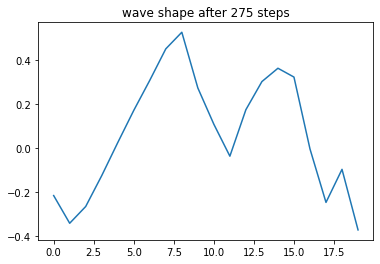

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_275/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_275/model_weights.tf
generator loss:2.152574348138309
-----------------------


 18%|█▊        | 276/1562 [15:58<1:44:13,  4.86s/it]

total discriminator loss:0.32291135027190365
average true return:0.4900959606381794
-----------------------
Training Step: 276
generator loss:2.157367571255117
-----------------------


 18%|█▊        | 277/1562 [16:00<1:24:08,  3.93s/it]

total discriminator loss:0.3309208351538951
average true return:0.4979192967698695
-----------------------
Training Step: 277
generator loss:2.1620663370623876
-----------------------


 18%|█▊        | 278/1562 [16:01<1:10:06,  3.28s/it]

total discriminator loss:0.3193267801091413
average true return:0.49576646445547246
-----------------------
Training Step: 278
generator loss:2.1053086496877462
-----------------------


 18%|█▊        | 279/1562 [16:03<1:00:17,  2.82s/it]

total discriminator loss:0.3280553820881075
average true return:0.5043184409040942
-----------------------
Training Step: 279
generator loss:2.1358505747732703
-----------------------


 18%|█▊        | 280/1562 [16:05<53:25,  2.50s/it]  

total discriminator loss:0.3374793108766396
average true return:0.500337315880862
-----------------------
Training Step: 280
event_types: [0, 0, 0, 1, 3, 1, 2, 2, 2, 1, 1, 2, 0, 3, 0, 1, 2, 2, 0, 1]
mad_score: 0.6557875
fid_score: 9761.237160624958
rule_score: 0.21975


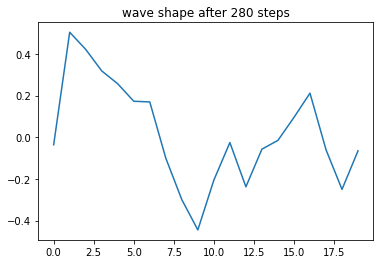

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_280/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_280/model_weights.tf
generator loss:2.1582069657076826
-----------------------


 18%|█▊        | 281/1562 [16:15<1:41:06,  4.74s/it]

total discriminator loss:0.3217869513026538
average true return:0.49591749112635125
-----------------------
Training Step: 281
generator loss:2.1404191151169893
-----------------------


 18%|█▊        | 282/1562 [16:17<1:21:54,  3.84s/it]

total discriminator loss:0.32235061775221263
average true return:0.4953054770146231
-----------------------
Training Step: 282
generator loss:2.2330504451734585
-----------------------


 18%|█▊        | 283/1562 [16:18<1:08:30,  3.21s/it]

total discriminator loss:0.36523510340226717
average true return:0.48870859726673177
-----------------------
Training Step: 283
generator loss:2.1672427711615025
-----------------------


 18%|█▊        | 284/1562 [16:20<59:45,  2.81s/it]  

total discriminator loss:0.3369859998209639
average true return:0.48707422341218104
-----------------------
Training Step: 284
generator loss:2.1707470078321345
-----------------------
total discriminator loss:0.349631595516827
average true return:0.4908712161208237
-----------------------


 18%|█▊        | 285/1562 [16:23<57:39,  2.71s/it]

Training Step: 285
event_types: [3, 1, 2, 2, 3, 2, 1, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 3, 2, 1]
mad_score: 0.6701625
fid_score: 10092.498171700916
rule_score: 0.196


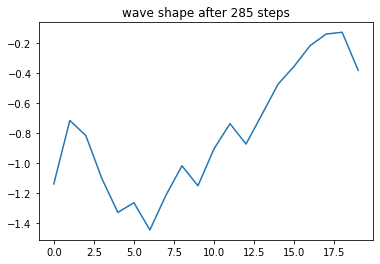

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_285/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_285/model_weights.tf
generator loss:2.199575174368401
-----------------------
total discriminator loss:0.33208178401604116
average true return:0.4970393724327365
-----------------------


 18%|█▊        | 286/1562 [16:35<2:01:13,  5.70s/it]

Training Step: 286
generator loss:2.147613625062924
-----------------------


 18%|█▊        | 287/1562 [16:37<1:36:43,  4.55s/it]

total discriminator loss:0.3263093660004365
average true return:0.49848049463707517
-----------------------
Training Step: 287
generator loss:2.1421663877076265
-----------------------


 18%|█▊        | 288/1562 [16:39<1:19:18,  3.74s/it]

total discriminator loss:0.319792334507717
average true return:0.5009235827981424
-----------------------
Training Step: 288
generator loss:2.1176461820726606
-----------------------


 19%|█▊        | 289/1562 [16:41<1:06:41,  3.14s/it]

total discriminator loss:0.30612351733068266
average true return:0.5094270624684025
-----------------------
Training Step: 289
generator loss:2.1062189969458114
-----------------------


 19%|█▊        | 290/1562 [16:43<57:47,  2.73s/it]  

total discriminator loss:0.32153176003419415
average true return:0.5034884799303816
-----------------------
Training Step: 290
event_types: [3, 1, 0, 1, 2, 0, 1, 0, 0, 2, 1, 3, 2, 0, 2, 2, 3, 2, 0, 1]
mad_score: 0.6865875
fid_score: 10561.18414852067
rule_score: 0.17275


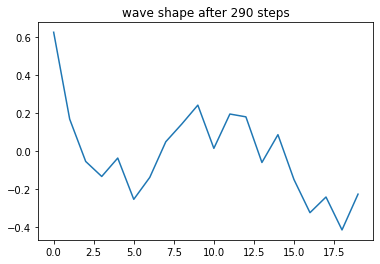

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_290/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_290/model_weights.tf
generator loss:2.1591707091032037
-----------------------


 19%|█▊        | 291/1562 [16:53<1:45:25,  4.98s/it]

total discriminator loss:0.3501303416544798
average true return:0.5028616889789798
-----------------------
Training Step: 291
generator loss:2.199685153954056
-----------------------


 19%|█▊        | 292/1562 [16:55<1:25:11,  4.02s/it]

total discriminator loss:0.34508195370534356
average true return:0.5131344193799325
-----------------------
Training Step: 292
generator loss:2.1832158093464673
-----------------------


 19%|█▉        | 293/1562 [16:57<1:11:00,  3.36s/it]

total discriminator loss:0.33059236606211556
average true return:0.49458755486297007
-----------------------
Training Step: 293
generator loss:2.209184518109372
-----------------------


 19%|█▉        | 294/1562 [16:58<1:01:03,  2.89s/it]

total discriminator loss:0.30897773423459696
average true return:0.4856488060252865
-----------------------
Training Step: 294
generator loss:2.1930554183482194
-----------------------


 19%|█▉        | 295/1562 [17:00<53:59,  2.56s/it]  

total discriminator loss:0.3109471985705472
average true return:0.49260839325639505
-----------------------
Training Step: 295
event_types: [0, 1, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 2, 0, 2, 1, 0, 3, 3, 0]
mad_score: 0.704475
fid_score: 10983.705798808729
rule_score: 0.1355


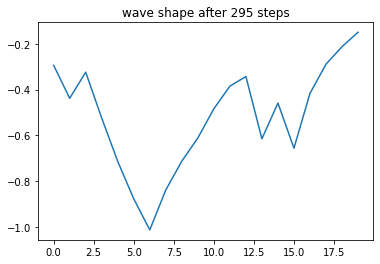

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_295/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_295/model_weights.tf
generator loss:2.126441080270828
-----------------------


 19%|█▉        | 296/1562 [17:10<1:40:28,  4.76s/it]

total discriminator loss:2.0021224156189334
average true return:0.49882429635992054
-----------------------
Training Step: 296
generator loss:2.1129583392415503
-----------------------


 19%|█▉        | 297/1562 [17:12<1:21:21,  3.86s/it]

total discriminator loss:0.34351181956408317
average true return:0.49471379806077037
-----------------------
Training Step: 297
generator loss:1.9851274825733514
-----------------------


 19%|█▉        | 298/1562 [17:13<1:07:59,  3.23s/it]

total discriminator loss:0.33233836726344224
average true return:0.5153052690339098
-----------------------
Training Step: 298
generator loss:1.927120579168438
-----------------------


 19%|█▉        | 299/1562 [17:15<58:37,  2.78s/it]  

total discriminator loss:0.3434410406385904
average true return:0.5258246060668689
-----------------------
Training Step: 299
generator loss:1.9409006096263681
-----------------------


 19%|█▉        | 300/1562 [17:17<52:01,  2.47s/it]

total discriminator loss:0.34350004658822775
average true return:0.5126594489767133
-----------------------
Training Step: 300
event_types: [3, 3, 2, 1, 1, 2, 2, 1, 0, 3, 3, 3, 0, 0, 0, 0, 2, 2, 0, 2]
mad_score: 0.7188625
fid_score: 11843.989862634287
rule_score: 0.11075


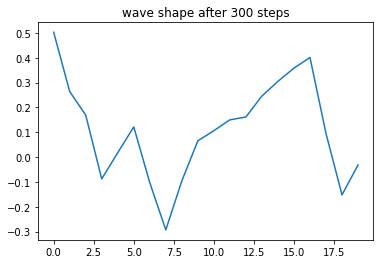

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_300/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_300/model_weights.tf
generator loss:2.012460231017938
-----------------------


 19%|█▉        | 301/1562 [17:27<1:39:00,  4.71s/it]

total discriminator loss:0.3703651645946541
average true return:0.5176119508067353
-----------------------
Training Step: 301
generator loss:2.0448442430959957
-----------------------


 19%|█▉        | 302/1562 [17:29<1:20:19,  3.83s/it]

total discriminator loss:0.3469931186101241
average true return:0.5019801292456463
-----------------------
Training Step: 302
generator loss:2.1227792458032892
-----------------------


 19%|█▉        | 303/1562 [17:30<1:07:12,  3.20s/it]

total discriminator loss:0.34479119374739786
average true return:0.4955965070785259
-----------------------
Training Step: 303
generator loss:2.1789809376487863
-----------------------


 19%|█▉        | 304/1562 [17:32<58:02,  2.77s/it]  

total discriminator loss:0.38428305343091174
average true return:0.4734732313768028
-----------------------
Training Step: 304
generator loss:2.171458934839495
-----------------------


 20%|█▉        | 305/1562 [17:34<51:40,  2.47s/it]

total discriminator loss:0.3365463471802769
average true return:0.4854063241310772
-----------------------
Training Step: 305
event_types: [2, 1, 2, 0, 2, 2, 3, 0, 3, 1, 1, 0, 1, 0, 0, 1, 3, 0, 3, 1]
mad_score: 0.733
fid_score: 12750.407591061483
rule_score: 0.091


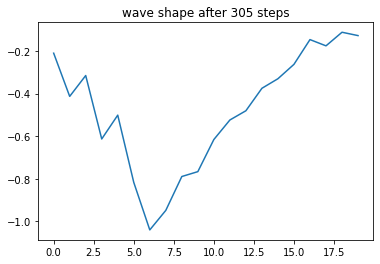

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_305/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_305/model_weights.tf
generator loss:2.1406657642884097
-----------------------


 20%|█▉        | 306/1562 [17:44<1:38:41,  4.71s/it]

total discriminator loss:0.3741292802376079
average true return:0.4878837711998828
-----------------------
Training Step: 306
generator loss:2.003143560594292
-----------------------


 20%|█▉        | 307/1562 [17:46<1:20:02,  3.83s/it]

total discriminator loss:0.3377998754056965
average true return:0.5054912468847982
-----------------------
Training Step: 307
generator loss:1.9998958905543334
-----------------------


 20%|█▉        | 308/1562 [17:47<1:07:03,  3.21s/it]

total discriminator loss:0.3415747720933866
average true return:0.5173008013835082
-----------------------
Training Step: 308
generator loss:1.8854710927453007
-----------------------


 20%|█▉        | 309/1562 [17:49<57:50,  2.77s/it]  

total discriminator loss:0.3407748036169299
average true return:0.5320689970432597
-----------------------
Training Step: 309
generator loss:1.870347552994039
-----------------------


 20%|█▉        | 310/1562 [17:51<51:25,  2.46s/it]

total discriminator loss:0.3514095460256253
average true return:0.532712051562022
-----------------------
Training Step: 310
event_types: [2, 2, 0, 1, 1, 1, 2, 2, 2, 0, 3, 1, 1, 2, 2, 0, 3, 0, 1, 1]
mad_score: 0.75205
fid_score: 14678.827250638515
rule_score: 0.06175


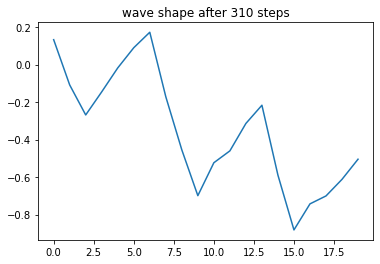

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_310/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_310/model_weights.tf
generator loss:1.992370470302081
-----------------------
total discriminator loss:0.34875556161980004
average true return:0.5153737933584173
-----------------------


 20%|█▉        | 311/1562 [18:01<1:39:19,  4.76s/it]

Training Step: 311
generator loss:2.008773127737814
-----------------------
total discriminator loss:0.356278113500844
average true return:0.505671226859962
-----------------------


 20%|█▉        | 312/1562 [18:04<1:25:02,  4.08s/it]

Training Step: 312
generator loss:2.001878353538431
-----------------------
total discriminator loss:0.3296577738174699
average true return:0.5115740496066574
-----------------------


 20%|██        | 313/1562 [18:06<1:15:13,  3.61s/it]

Training Step: 313
generator loss:2.104368147419023
-----------------------
total discriminator loss:0.3337076499409598
average true return:0.49813927579176565
-----------------------


 20%|██        | 314/1562 [18:09<1:08:03,  3.27s/it]

Training Step: 314
generator loss:2.141745682138041
-----------------------
total discriminator loss:0.31150944690640914
average true return:0.49962059728971786
-----------------------


 20%|██        | 315/1562 [18:11<1:02:09,  2.99s/it]

Training Step: 315
event_types: [1, 2, 0, 1, 1, 2, 2, 2, 1, 0, 1, 0, 1, 0, 0, 1, 2, 0, 3, 3]
mad_score: 0.7671625
fid_score: 16662.003414752242
rule_score: 0.049


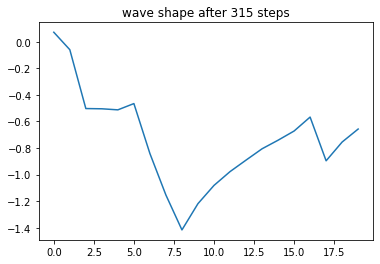

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_315/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_315/model_weights.tf
generator loss:2.1282955630037095
-----------------------


 20%|██        | 316/1562 [18:22<1:52:32,  5.42s/it]

total discriminator loss:0.3335840046588473
average true return:0.4980400915854343
-----------------------
Training Step: 316
generator loss:2.2002927927237246
-----------------------


 20%|██        | 317/1562 [18:24<1:29:35,  4.32s/it]

total discriminator loss:1.8622131907224218
average true return:0.48596529146941825
-----------------------
Training Step: 317
generator loss:2.150167825554556
-----------------------


 20%|██        | 318/1562 [18:25<1:13:36,  3.55s/it]

total discriminator loss:0.33724676211047794
average true return:0.483790723213786
-----------------------
Training Step: 318
generator loss:2.173514060083846
-----------------------


 20%|██        | 319/1562 [18:27<1:02:22,  3.01s/it]

total discriminator loss:1.8527023703076597
average true return:0.4866438903517515
-----------------------
Training Step: 319
generator loss:2.0802699824324744
-----------------------


 20%|██        | 320/1562 [18:29<54:28,  2.63s/it]  

total discriminator loss:0.33802934149313374
average true return:0.4778250860004241
-----------------------
Training Step: 320
event_types: [0, 2, 1, 1, 2, 2, 1, 2, 3, 1, 2, 1, 0, 0, 2, 1, 2, 3, 3, 0]
mad_score: 0.7791625
fid_score: 19231.98573533797
rule_score: 0.03675


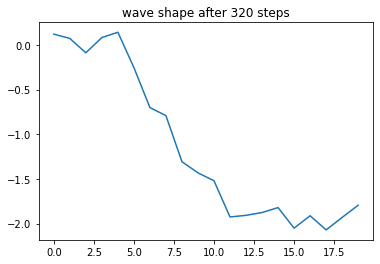

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_320/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_320/model_weights.tf
generator loss:2.0622004327219545
-----------------------


 21%|██        | 321/1562 [18:39<1:39:58,  4.83s/it]

total discriminator loss:0.3528079703215138
average true return:0.48866948302707525
-----------------------
Training Step: 321
generator loss:2.0017252074013285
-----------------------


 21%|██        | 322/1562 [18:41<1:21:22,  3.94s/it]

total discriminator loss:0.31840205695055335
average true return:0.49249112663765904
-----------------------
Training Step: 322
generator loss:1.9492698112185884
-----------------------


 21%|██        | 323/1562 [18:43<1:07:46,  3.28s/it]

total discriminator loss:0.3573773572371213
average true return:0.5027614509480287
-----------------------
Training Step: 323
generator loss:1.8271978553118318
-----------------------


 21%|██        | 324/1562 [18:44<58:18,  2.83s/it]  

total discriminator loss:0.3344341727974953
average true return:0.5109805331487236
-----------------------
Training Step: 324
generator loss:1.7952579974021132
-----------------------


 21%|██        | 325/1562 [18:46<51:38,  2.50s/it]

total discriminator loss:0.357740836802953
average true return:0.5232415916773456
-----------------------
Training Step: 325
event_types: [0, 1, 3, 3, 0, 2, 2, 1, 3, 2, 0, 3, 1, 1, 0, 0, 0, 0, 1, 0]
mad_score: 0.7934625
fid_score: 23848.481897836562
rule_score: 0.0235


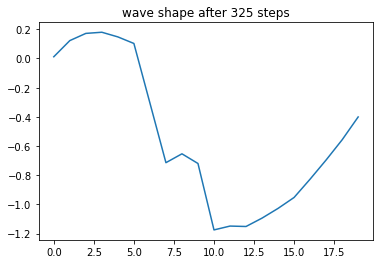

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_325/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_325/model_weights.tf
generator loss:1.7876656643885052
-----------------------


 21%|██        | 326/1562 [18:56<1:37:48,  4.75s/it]

total discriminator loss:0.34820863224910736
average true return:0.5229553570418864
-----------------------
Training Step: 326
generator loss:1.7297622181771386
-----------------------


 21%|██        | 327/1562 [18:58<1:19:16,  3.85s/it]

total discriminator loss:0.3696507154894997
average true return:0.5185157581272366
-----------------------
Training Step: 327
generator loss:1.7702321791154199
-----------------------


 21%|██        | 328/1562 [19:00<1:06:16,  3.22s/it]

total discriminator loss:0.3644579015203316
average true return:0.5157085183511382
-----------------------
Training Step: 328
generator loss:1.8174016992285287
-----------------------


 21%|██        | 329/1562 [19:01<57:07,  2.78s/it]  

total discriminator loss:0.3647217457332034
average true return:0.5090415869211476
-----------------------
Training Step: 329
generator loss:1.8436728374350775
-----------------------


 21%|██        | 330/1562 [19:03<51:10,  2.49s/it]

total discriminator loss:0.3516094756681085
average true return:0.5078237630715858
-----------------------
Training Step: 330
event_types: [2, 1, 3, 1, 2, 1, 1, 0, 0, 1, 2, 1, 0, 1, 0, 0, 0, 3, 0, 1]
mad_score: 0.809825
fid_score: 31596.125905754387
rule_score: 0.01925


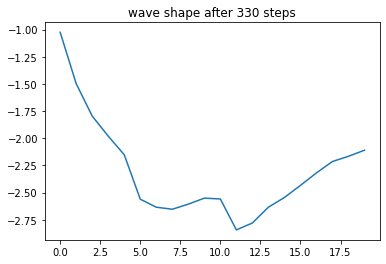

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_330/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_330/model_weights.tf
generator loss:1.824936583184567
-----------------------


 21%|██        | 331/1562 [19:16<1:56:41,  5.69s/it]

total discriminator loss:0.3437623002884644
average true return:0.4939002088140075
-----------------------
Training Step: 331
generator loss:1.7778463391888346
-----------------------
total discriminator loss:0.3640377715334412
average true return:0.49745710902308166
-----------------------


 21%|██▏       | 332/1562 [19:18<1:34:56,  4.63s/it]

Training Step: 332
generator loss:1.7921910196490851
-----------------------


 21%|██▏       | 333/1562 [19:20<1:17:56,  3.81s/it]

total discriminator loss:0.3431963608842502
average true return:0.5071082752529865
-----------------------
Training Step: 333
generator loss:1.8061020466350013
-----------------------


 21%|██▏       | 334/1562 [19:22<1:05:16,  3.19s/it]

total discriminator loss:0.35892881979967645
average true return:0.511035941507253
-----------------------
Training Step: 334
generator loss:1.7460540310128554
-----------------------


 21%|██▏       | 335/1562 [19:24<56:29,  2.76s/it]  

total discriminator loss:0.34762516140881616
average true return:0.51336321571535
-----------------------
Training Step: 335
event_types: [2, 0, 0, 2, 2, 3, 1, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 3]
mad_score: 0.8259125
fid_score: 46933.940549811916
rule_score: 0.0125


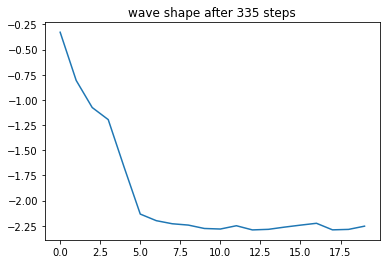

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_335/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_335/model_weights.tf
generator loss:1.745744418335609
-----------------------


 22%|██▏       | 336/1562 [19:34<1:42:55,  5.04s/it]

total discriminator loss:0.34978203259909213
average true return:0.5230421691736532
-----------------------
Training Step: 336
generator loss:1.7179821757060805
-----------------------


 22%|██▏       | 337/1562 [19:36<1:22:53,  4.06s/it]

total discriminator loss:0.37475386855694554
average true return:0.5238059258369461
-----------------------
Training Step: 337
generator loss:1.6901433819681144
-----------------------


 22%|██▏       | 338/1562 [19:38<1:08:42,  3.37s/it]

total discriminator loss:0.3397349250116391
average true return:0.5272356387442143
-----------------------
Training Step: 338
generator loss:1.7292817829095561
-----------------------


 22%|██▏       | 339/1562 [19:39<58:47,  2.88s/it]  

total discriminator loss:0.36127325982926695
average true return:0.525617975458146
-----------------------
Training Step: 339
generator loss:1.7286146806584126
-----------------------


 22%|██▏       | 340/1562 [19:41<51:51,  2.55s/it]

total discriminator loss:0.34431907011453206
average true return:0.5224771919368736
-----------------------
Training Step: 340
event_types: [2, 3, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 3, 3]
mad_score: 0.839575
fid_score: 72029.7713020821
rule_score: 0.00625


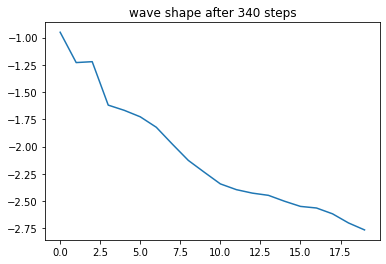

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_340/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_340/model_weights.tf
generator loss:1.738144476173003
-----------------------


 22%|██▏       | 341/1562 [19:51<1:37:41,  4.80s/it]

total discriminator loss:0.3401234053114744
average true return:0.5150758231237853
-----------------------
Training Step: 341
generator loss:1.7386617514469793
-----------------------


 22%|██▏       | 342/1562 [19:53<1:19:06,  3.89s/it]

total discriminator loss:0.33640727593850606
average true return:0.5230854416835828
-----------------------
Training Step: 342
generator loss:1.8033624369424437
-----------------------


 22%|██▏       | 343/1562 [19:55<1:06:04,  3.25s/it]

total discriminator loss:0.33534902583838666
average true return:0.5176127388874122
-----------------------
Training Step: 343
generator loss:1.794475169905865
-----------------------


 22%|██▏       | 344/1562 [19:57<56:54,  2.80s/it]  

total discriminator loss:0.3608362623160309
average true return:0.5112802296204962
-----------------------
Training Step: 344
generator loss:1.7908595671560814
-----------------------


 22%|██▏       | 345/1562 [19:58<50:30,  2.49s/it]

total discriminator loss:0.318292026428505
average true return:0.5243355027284109
-----------------------
Training Step: 345
event_types: [1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 1, 3, 0]
mad_score: 0.8505125
fid_score: 113131.29582464742
rule_score: 0.00525


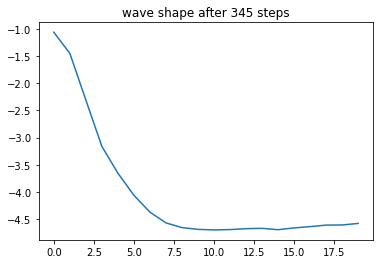

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_345/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_345/model_weights.tf
generator loss:1.7786151679182167
-----------------------


 22%|██▏       | 346/1562 [20:08<1:36:50,  4.78s/it]

total discriminator loss:0.326576618630018
average true return:0.5239095065320675
-----------------------
Training Step: 346
generator loss:1.8005339564238958
-----------------------


 22%|██▏       | 347/1562 [20:10<1:18:24,  3.87s/it]

total discriminator loss:0.34159847028770385
average true return:0.523753612694724
-----------------------
Training Step: 347
generator loss:1.754584060617809
-----------------------


 22%|██▏       | 348/1562 [20:12<1:05:28,  3.24s/it]

total discriminator loss:0.3542268406405795
average true return:0.5231973086696952
-----------------------
Training Step: 348
generator loss:1.743773827782479
-----------------------


 22%|██▏       | 349/1562 [20:14<56:26,  2.79s/it]  

total discriminator loss:0.35402172432050016
average true return:0.5282334293030349
-----------------------
Training Step: 349
generator loss:1.7524029607249965
-----------------------


 22%|██▏       | 350/1562 [20:15<50:10,  2.48s/it]

total discriminator loss:0.36104033741458225
average true return:0.5251823294936218
-----------------------
Training Step: 350
event_types: [3, 2, 3, 2, 1, 0, 2, 1, 0, 0, 0, 0, 3, 2, 1, 0, 3, 0, 0, 1]
mad_score: 0.8588875
fid_score: 176370.29764375527
rule_score: 0.00425


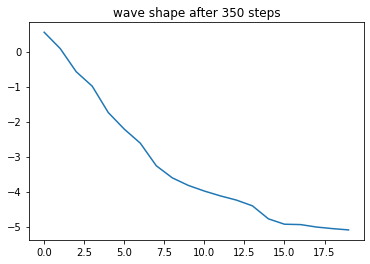

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_350/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_350/model_weights.tf
generator loss:1.7234924573771853
-----------------------


 22%|██▏       | 351/1562 [20:25<1:35:30,  4.73s/it]

total discriminator loss:0.3637383608534361
average true return:0.5271345540778569
-----------------------
Training Step: 351
generator loss:1.7475358543443977
-----------------------


 23%|██▎       | 352/1562 [20:27<1:17:26,  3.84s/it]

total discriminator loss:0.3214691784471728
average true return:0.5306599511606336
-----------------------
Training Step: 352
generator loss:1.71844014230353
-----------------------


 23%|██▎       | 353/1562 [20:29<1:04:50,  3.22s/it]

total discriminator loss:0.31237248608574436
average true return:0.5344469985317468
-----------------------
Training Step: 353
generator loss:1.7173799275982211
-----------------------


 23%|██▎       | 354/1562 [20:31<55:58,  2.78s/it]  

total discriminator loss:0.36273555437546434
average true return:0.53914924955343
-----------------------
Training Step: 354
generator loss:1.6922356730421533
-----------------------


 23%|██▎       | 355/1562 [20:32<49:45,  2.47s/it]

total discriminator loss:0.35028107072117093
average true return:0.536820406284899
-----------------------
Training Step: 355
event_types: [0, 0, 1, 3, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.86975
fid_score: 268333.094186898
rule_score: 0.00175


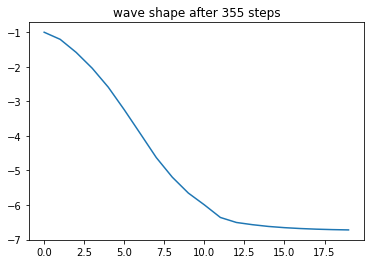

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_355/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_355/model_weights.tf
generator loss:1.7292617279468763
-----------------------


 23%|██▎       | 356/1562 [20:43<1:35:19,  4.74s/it]

total discriminator loss:0.32872370699856335
average true return:0.5413034029777724
-----------------------
Training Step: 356
generator loss:1.7224730705633151
-----------------------


 23%|██▎       | 357/1562 [20:44<1:17:18,  3.85s/it]

total discriminator loss:0.32855740578910114
average true return:0.5380415029323815
-----------------------
Training Step: 357
generator loss:1.734835890247634
-----------------------


 23%|██▎       | 358/1562 [20:46<1:04:44,  3.23s/it]

total discriminator loss:0.36433659578102073
average true return:0.5386558977621239
-----------------------
Training Step: 358
generator loss:1.7567336702478773
-----------------------


 23%|██▎       | 359/1562 [20:48<55:54,  2.79s/it]  

total discriminator loss:0.3304741144861791
average true return:0.5378252996361289
-----------------------
Training Step: 359
generator loss:1.7579454996780437
-----------------------


 23%|██▎       | 360/1562 [20:50<49:42,  2.48s/it]

total discriminator loss:0.32418731591708416
average true return:0.5325290241041942
-----------------------
Training Step: 360
event_types: [2, 2, 3, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
mad_score: 0.8718375
fid_score: 382644.68287521123
rule_score: 0.0065


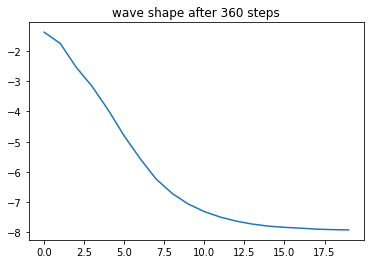

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_360/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_360/model_weights.tf
generator loss:1.7944505206168428
-----------------------


 23%|██▎       | 361/1562 [21:00<1:34:35,  4.73s/it]

total discriminator loss:0.31054122994339706
average true return:0.5353285422352334
-----------------------
Training Step: 361
generator loss:1.8167421395465388
-----------------------


 23%|██▎       | 362/1562 [21:01<1:16:42,  3.84s/it]

total discriminator loss:0.32646596626776125
average true return:0.5321457170024134
-----------------------
Training Step: 362
generator loss:1.8400795600611808
-----------------------


 23%|██▎       | 363/1562 [21:03<1:04:13,  3.21s/it]

total discriminator loss:0.3342904600386424
average true return:0.532368878595127
-----------------------
Training Step: 363
generator loss:1.882477611847179
-----------------------


 23%|██▎       | 364/1562 [21:05<55:28,  2.78s/it]  

total discriminator loss:1.8541481907882422
average true return:0.52744345216271
-----------------------
Training Step: 364
generator loss:1.8210869650278383
-----------------------
total discriminator loss:1.7905912262831738
average true return:0.5267521212445652
-----------------------


 23%|██▎       | 365/1562 [21:07<50:41,  2.54s/it]

Training Step: 365
event_types: [3, 2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.877675
fid_score: 516990.10347173
rule_score: 0.006


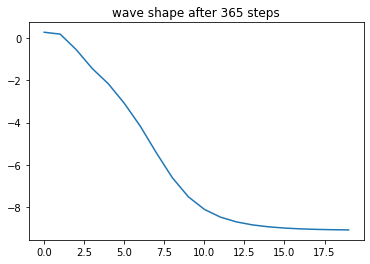

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_365/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_365/model_weights.tf
generator loss:1.7420041897306096
-----------------------
total discriminator loss:0.34744927629326006
average true return:0.5284886292356928
-----------------------


 23%|██▎       | 366/1562 [21:20<1:56:04,  5.82s/it]

Training Step: 366
generator loss:1.65624017101835
-----------------------


 23%|██▎       | 367/1562 [21:22<1:33:51,  4.71s/it]

total discriminator loss:0.37005374387643797
average true return:0.5321968506018264
-----------------------
Training Step: 367
generator loss:1.5825342633259323
-----------------------


 24%|██▎       | 368/1562 [21:24<1:16:17,  3.83s/it]

total discriminator loss:1.5981174123878814
average true return:0.5329288955129998
-----------------------
Training Step: 368
generator loss:1.523023854235317
-----------------------


 24%|██▎       | 369/1562 [21:26<1:03:52,  3.21s/it]

total discriminator loss:0.38774979069347704
average true return:0.5221500328013211
-----------------------
Training Step: 369
generator loss:1.427075718082118
-----------------------


 24%|██▎       | 370/1562 [21:28<55:11,  2.78s/it]  

total discriminator loss:0.415028249452636
average true return:0.5145992398832376
-----------------------
Training Step: 370
event_types: [0, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.8732625
fid_score: 666852.2180095549
rule_score: 0.00775


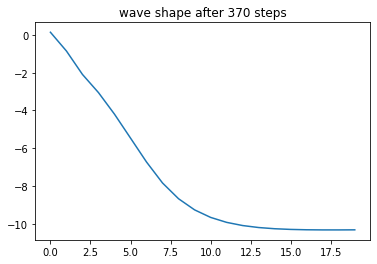

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_370/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_370/model_weights.tf
generator loss:1.3794277988528965
-----------------------


 24%|██▍       | 371/1562 [21:38<1:37:43,  4.92s/it]

total discriminator loss:0.39996037691385816
average true return:0.5132887320239623
-----------------------
Training Step: 371
generator loss:1.3161864480162007
-----------------------


 24%|██▍       | 372/1562 [21:39<1:18:48,  3.97s/it]

total discriminator loss:0.3947508533819332
average true return:0.5340767340544434
-----------------------
Training Step: 372
generator loss:1.283720835913134
-----------------------


 24%|██▍       | 373/1562 [21:41<1:05:36,  3.31s/it]

total discriminator loss:0.4028646976263145
average true return:0.5386794686719856
-----------------------
Training Step: 373
generator loss:1.2785664518806112
-----------------------


 24%|██▍       | 374/1562 [21:43<56:22,  2.85s/it]  

total discriminator loss:0.3831910752842908
average true return:0.5516288999103713
-----------------------
Training Step: 374
generator loss:1.2555815770735674
-----------------------


 24%|██▍       | 375/1562 [21:45<49:56,  2.52s/it]

total discriminator loss:0.3841808812011924
average true return:0.5566667550123142
-----------------------
Training Step: 375
event_types: [1, 0, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.8741875
fid_score: 818626.0147070636
rule_score: 0.012


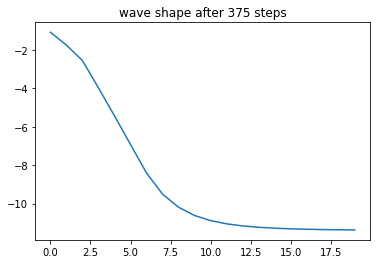

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_375/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_375/model_weights.tf
generator loss:1.234332090022483
-----------------------


 24%|██▍       | 376/1562 [21:55<1:33:55,  4.75s/it]

total discriminator loss:1.3661562422097409
average true return:0.5547429056707596
-----------------------
Training Step: 376
generator loss:1.2220001995321637
-----------------------


 24%|██▍       | 377/1562 [21:56<1:16:06,  3.85s/it]

total discriminator loss:0.39130013136883884
average true return:0.5547681665673537
-----------------------
Training Step: 377
generator loss:1.229287543185829
-----------------------


 24%|██▍       | 378/1562 [21:58<1:03:40,  3.23s/it]

total discriminator loss:0.3967946889754785
average true return:0.5521932042817841
-----------------------
Training Step: 378
generator loss:1.209855904112477
-----------------------


 24%|██▍       | 379/1562 [22:00<55:04,  2.79s/it]  

total discriminator loss:0.40723567551084294
average true return:0.5546408529088203
-----------------------
Training Step: 379
generator loss:1.198694605795792
-----------------------


 24%|██▍       | 380/1562 [22:02<49:09,  2.50s/it]

total discriminator loss:0.4144718899344132
average true return:0.5541443667347797
-----------------------
Training Step: 380
event_types: [2, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.8729
fid_score: 960186.9107744019
rule_score: 0.01425


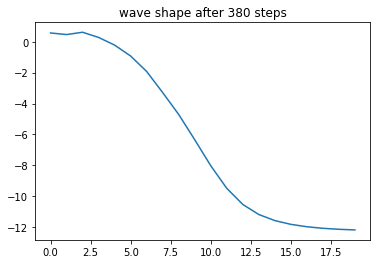

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_380/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_380/model_weights.tf
generator loss:1.2383849916979353
-----------------------


 24%|██▍       | 381/1562 [22:12<1:34:52,  4.82s/it]

total discriminator loss:0.3798506512655254
average true return:0.5462849559170114
-----------------------
Training Step: 381
generator loss:1.2498032023719063
-----------------------


 24%|██▍       | 382/1562 [22:14<1:16:48,  3.91s/it]

total discriminator loss:0.40042617807779374
average true return:0.5402376730760818
-----------------------
Training Step: 382
generator loss:1.269191008819515
-----------------------


 25%|██▍       | 383/1562 [22:16<1:04:07,  3.26s/it]

total discriminator loss:0.37654422721225234
average true return:0.5372266761153182
-----------------------
Training Step: 383
generator loss:1.2910857454405544
-----------------------


 25%|██▍       | 384/1562 [22:17<55:13,  2.81s/it]  

total discriminator loss:0.38674389763776595
average true return:0.535206161623716
-----------------------
Training Step: 384
generator loss:1.3565584252142273
-----------------------


 25%|██▍       | 385/1562 [22:19<49:00,  2.50s/it]

total discriminator loss:0.36890266650267944
average true return:0.5308398560154812
-----------------------
Training Step: 385
event_types: [1, 2, 2, 3, 3, 2, 2, 3, 0, 2, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0]
mad_score: 0.87295
fid_score: 1073697.1882534612
rule_score: 0.017


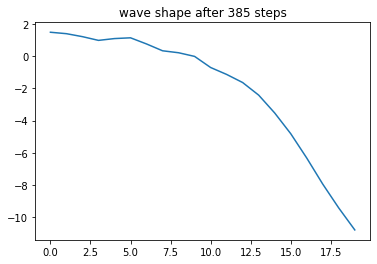

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_385/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_385/model_weights.tf
generator loss:1.3793691933679217
-----------------------
total discriminator loss:0.36812338672155986
average true return:0.5260492238202588
-----------------------


 25%|██▍       | 386/1562 [22:30<1:40:52,  5.15s/it]

Training Step: 386
generator loss:1.4214624324129734
-----------------------
total discriminator loss:0.37028541508179813
average true return:0.5233610174908239
-----------------------


 25%|██▍       | 387/1562 [22:33<1:25:12,  4.35s/it]

Training Step: 387
generator loss:1.4645360933688332
-----------------------
total discriminator loss:0.36108725520487595
average true return:0.5188792838621097
-----------------------


 25%|██▍       | 388/1562 [22:35<1:14:23,  3.80s/it]

Training Step: 388
generator loss:1.4946808659975295
-----------------------
total discriminator loss:0.37435694588083884
average true return:0.5152533653370597
-----------------------


 25%|██▍       | 389/1562 [22:38<1:07:03,  3.43s/it]

Training Step: 389
generator loss:1.5551719515820643
-----------------------
total discriminator loss:0.38387245398355707
average true return:0.5141628744516882
-----------------------


 25%|██▍       | 390/1562 [22:41<1:02:19,  3.19s/it]

Training Step: 390
event_types: [0, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.8661
fid_score: 1162696.1293419139
rule_score: 0.0185


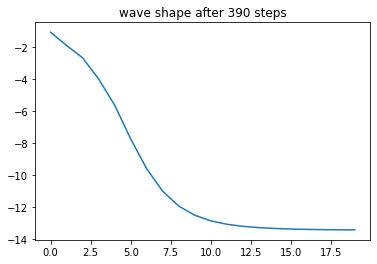

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_390/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_390/model_weights.tf
generator loss:1.5888626632207852
-----------------------
total discriminator loss:0.3724853043749342
average true return:0.5102036673252202
-----------------------


 25%|██▌       | 391/1562 [22:55<2:08:33,  6.59s/it]

Training Step: 391
generator loss:1.6320821582133953
-----------------------
total discriminator loss:0.3517087325197519
average true return:0.5068517097540854
-----------------------


 25%|██▌       | 392/1562 [22:58<1:44:30,  5.36s/it]

Training Step: 392
generator loss:1.6790719521520687
-----------------------
total discriminator loss:1.550434580151029
average true return:0.5065276825483932
-----------------------


 25%|██▌       | 393/1562 [23:00<1:27:51,  4.51s/it]

Training Step: 393
generator loss:1.682313311036179
-----------------------
total discriminator loss:0.3611655691375938
average true return:0.5038074120793381
-----------------------


 25%|██▌       | 394/1562 [23:03<1:16:06,  3.91s/it]

Training Step: 394
generator loss:1.7014191140071246
-----------------------
total discriminator loss:0.3519632613076621
average true return:0.49984391697004715
-----------------------


 25%|██▌       | 395/1562 [23:05<1:09:35,  3.58s/it]

Training Step: 395
event_types: [3, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.8712125
fid_score: 1253081.2962692776
rule_score: 0.02225


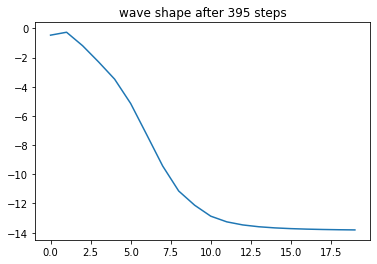

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_395/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_395/model_weights.tf
generator loss:1.710440953616709
-----------------------
total discriminator loss:0.3629295811130615
average true return:0.5032214313369905
-----------------------


 25%|██▌       | 396/1562 [23:20<2:14:59,  6.95s/it]

Training Step: 396
generator loss:1.7072674830407286
-----------------------
total discriminator loss:0.3527115216245629
average true return:0.4991078444454956
-----------------------


 25%|██▌       | 397/1562 [23:23<1:49:09,  5.62s/it]

Training Step: 397
generator loss:1.7513140445185886
-----------------------
total discriminator loss:0.3705675980637422
average true return:0.4975312932794008
-----------------------


 25%|██▌       | 398/1562 [23:25<1:30:53,  4.68s/it]

Training Step: 398
generator loss:1.775896124220384
-----------------------
total discriminator loss:0.32738420085240727
average true return:0.494688328357904
-----------------------


 26%|██▌       | 399/1562 [23:28<1:18:24,  4.05s/it]

Training Step: 399
generator loss:1.7725569836393995
-----------------------
total discriminator loss:0.34808514331131446
average true return:0.4963041894474155
-----------------------


 26%|██▌       | 400/1562 [23:30<1:09:28,  3.59s/it]

Training Step: 400
event_types: [1, 0, 1, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.87075
fid_score: 1335608.335505757
rule_score: 0.01875


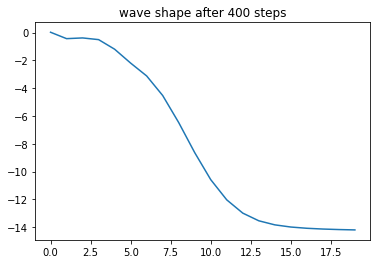

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_400/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_400/model_weights.tf
generator loss:1.7864246143990408
-----------------------
total discriminator loss:0.3460032648711433
average true return:0.4929467956924575
-----------------------


 26%|██▌       | 401/1562 [23:45<2:12:29,  6.85s/it]

Training Step: 401
generator loss:1.8072347345205584
-----------------------
total discriminator loss:0.3231823949242122
average true return:0.4931572567061799
-----------------------


 26%|██▌       | 402/1562 [23:47<1:47:20,  5.55s/it]

Training Step: 402
generator loss:1.8185038704274605
-----------------------
total discriminator loss:0.3291319191130657
average true return:0.49211549526949305
-----------------------


 26%|██▌       | 403/1562 [23:50<1:29:40,  4.64s/it]

Training Step: 403
generator loss:1.8352445088384508
-----------------------
total discriminator loss:0.3380477468533817
average true return:0.49518903208351983
-----------------------


 26%|██▌       | 404/1562 [23:52<1:17:22,  4.01s/it]

Training Step: 404
generator loss:1.8824993790643973
-----------------------
total discriminator loss:0.33459225112170876
average true return:0.4939966416358918
-----------------------


 26%|██▌       | 405/1562 [23:55<1:08:40,  3.56s/it]

Training Step: 405
event_types: [3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2]
mad_score: 0.8641
fid_score: 1374241.4254481015
rule_score: 0.02425


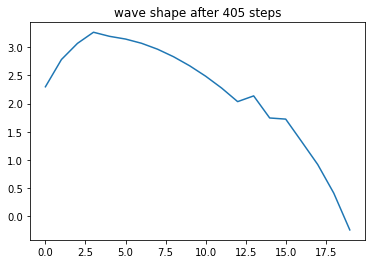

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_405/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_405/model_weights.tf
generator loss:1.8922849168258662
-----------------------
total discriminator loss:0.3355724581302416
average true return:0.4959826654426802
-----------------------


 26%|██▌       | 406/1562 [24:09<2:11:33,  6.83s/it]

Training Step: 406
generator loss:1.912383848487382
-----------------------
total discriminator loss:0.3397435560989295
average true return:0.49213728732332296
-----------------------


 26%|██▌       | 407/1562 [24:12<1:46:38,  5.54s/it]

Training Step: 407
generator loss:1.925207013594436
-----------------------
total discriminator loss:0.33458812301603835
average true return:0.48979842774872895
-----------------------


 26%|██▌       | 408/1562 [24:14<1:29:12,  4.64s/it]

Training Step: 408
generator loss:1.9460304517136557
-----------------------
total discriminator loss:0.33705159037882226
average true return:0.4904179084478348
-----------------------


 26%|██▌       | 409/1562 [24:17<1:16:50,  4.00s/it]

Training Step: 409
generator loss:1.9668471007928012
-----------------------
total discriminator loss:0.32540963691522223
average true return:0.4910494268553959
-----------------------


 26%|██▌       | 410/1562 [24:20<1:08:27,  3.57s/it]

Training Step: 410
event_types: [2, 2, 1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.8692
fid_score: 1451285.05623527
rule_score: 0.02625


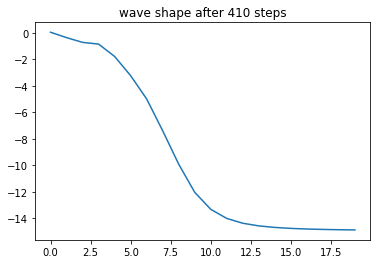

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_410/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_410/model_weights.tf
generator loss:1.984870523879342
-----------------------
total discriminator loss:0.3179001964050274
average true return:0.49391157196348373
-----------------------


 26%|██▋       | 411/1562 [24:34<2:12:41,  6.92s/it]

Training Step: 411
generator loss:1.9996426360133137
-----------------------
total discriminator loss:0.31974523677787936
average true return:0.49443162795293627
-----------------------


 26%|██▋       | 412/1562 [24:37<1:47:36,  5.61s/it]

Training Step: 412
generator loss:2.02972124161835
-----------------------
total discriminator loss:0.34895317993831354
average true return:0.4935683620884202
-----------------------


 26%|██▋       | 413/1562 [24:40<1:30:51,  4.74s/it]

Training Step: 413
generator loss:2.0319922624960087
-----------------------
total discriminator loss:0.31540786243126473
average true return:0.4943850840664664
-----------------------


 27%|██▋       | 414/1562 [24:42<1:18:04,  4.08s/it]

Training Step: 414
generator loss:2.058972113614949
-----------------------
total discriminator loss:0.3121393206802383
average true return:0.49412985562751877
-----------------------


 27%|██▋       | 415/1562 [24:45<1:09:20,  3.63s/it]

Training Step: 415
event_types: [3, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.8633875
fid_score: 1496971.24089693
rule_score: 0.02875


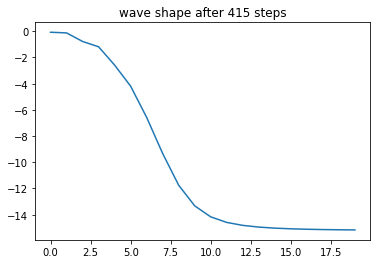

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_415/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_415/model_weights.tf
generator loss:2.060984781129343
-----------------------
total discriminator loss:0.331850774015779
average true return:0.49542626248095056
-----------------------


 27%|██▋       | 416/1562 [24:59<2:11:45,  6.90s/it]

Training Step: 416
generator loss:2.0690545453054856
-----------------------
total discriminator loss:0.32229992304514254
average true return:0.4940810409968608
-----------------------


 27%|██▋       | 417/1562 [25:02<1:46:31,  5.58s/it]

Training Step: 417
generator loss:2.099351623224293
-----------------------
total discriminator loss:0.30150160772612544
average true return:0.4946306985070845
-----------------------


 27%|██▋       | 418/1562 [25:04<1:29:06,  4.67s/it]

Training Step: 418
generator loss:2.0931692907001107
-----------------------
total discriminator loss:0.33725177422564795
average true return:0.49609524917939324
-----------------------


 27%|██▋       | 419/1562 [25:07<1:16:57,  4.04s/it]

Training Step: 419
generator loss:2.128272463334163
-----------------------
total discriminator loss:0.32584421776853967
average true return:0.4946444325522422
-----------------------


 27%|██▋       | 420/1562 [25:09<1:08:25,  3.59s/it]

Training Step: 420
event_types: [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.8674875
fid_score: 1576482.8508590108
rule_score: 0.02825


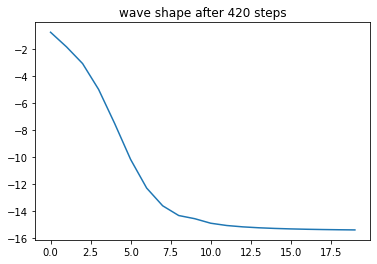

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_420/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_420/model_weights.tf
generator loss:2.1127911949874836
-----------------------
total discriminator loss:1.8995620251372973
average true return:0.49567905747966967
-----------------------


 27%|██▋       | 421/1562 [25:24<2:10:55,  6.89s/it]

Training Step: 421
generator loss:2.1168236230055166
-----------------------
total discriminator loss:0.31483534931394097
average true return:0.49605384550196935
-----------------------


 27%|██▋       | 422/1562 [25:26<1:46:09,  5.59s/it]

Training Step: 422
generator loss:2.099102189405632
-----------------------
total discriminator loss:0.3348439127167162
average true return:0.4959030449958366
-----------------------


 27%|██▋       | 423/1562 [25:29<1:28:38,  4.67s/it]

Training Step: 423
generator loss:2.0864956774640255
-----------------------
total discriminator loss:0.3347523592570131
average true return:0.4974412494197401
-----------------------


 27%|██▋       | 424/1562 [25:32<1:16:24,  4.03s/it]

Training Step: 424
generator loss:2.067213868944466
-----------------------
total discriminator loss:0.29992887046944217
average true return:0.4959544601805759
-----------------------


 27%|██▋       | 425/1562 [25:34<1:07:53,  3.58s/it]

Training Step: 425
event_types: [1, 2, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.86265
fid_score: 1620174.1325153043
rule_score: 0.027


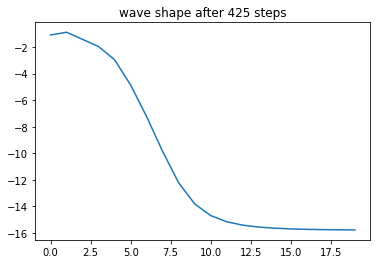

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_425/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_425/model_weights.tf
generator loss:2.0608253840093544
-----------------------
total discriminator loss:0.31354661605141176
average true return:0.49455772011838084
-----------------------


 27%|██▋       | 426/1562 [25:49<2:10:24,  6.89s/it]

Training Step: 426
generator loss:2.0733835752191108
-----------------------
total discriminator loss:0.3164870744440713
average true return:0.4969141680210418
-----------------------


 27%|██▋       | 427/1562 [25:51<1:45:35,  5.58s/it]

Training Step: 427
generator loss:2.067823638125903
-----------------------
total discriminator loss:0.32187807327439183
average true return:0.49686438303816993
-----------------------


 27%|██▋       | 428/1562 [25:54<1:28:19,  4.67s/it]

Training Step: 428
generator loss:2.0612521453838406
-----------------------
total discriminator loss:0.33191935370102404
average true return:0.4966220468926037
-----------------------


 27%|██▋       | 429/1562 [25:56<1:16:22,  4.04s/it]

Training Step: 429
generator loss:2.0678660483001465
-----------------------
total discriminator loss:0.33597037259387175
average true return:0.49729779230373805
-----------------------


 28%|██▊       | 430/1562 [25:59<1:07:59,  3.60s/it]

Training Step: 430
event_types: [2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.86055
fid_score: 1678373.0524628765
rule_score: 0.0255


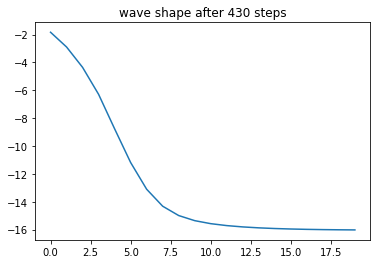

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_430/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_430/model_weights.tf
generator loss:2.0474451619903844
-----------------------
total discriminator loss:0.2916656669630059
average true return:0.49884078295586615
-----------------------


 28%|██▊       | 431/1562 [26:14<2:10:04,  6.90s/it]

Training Step: 431
generator loss:2.0616503427052164
-----------------------
total discriminator loss:0.3370540086210059
average true return:0.49992649809470185
-----------------------


 28%|██▊       | 432/1562 [26:16<1:45:15,  5.59s/it]

Training Step: 432
generator loss:2.0483523642349644
-----------------------
total discriminator loss:0.30666558814741607
average true return:0.49905336472026407
-----------------------


 28%|██▊       | 433/1562 [26:19<1:28:03,  4.68s/it]

Training Step: 433
generator loss:2.0513897926412765
-----------------------
total discriminator loss:0.2986865627973514
average true return:0.4986921911671711
-----------------------


 28%|██▊       | 434/1562 [26:21<1:16:02,  4.04s/it]

Training Step: 434
generator loss:2.060107523811629
-----------------------
total discriminator loss:0.30703683734050985
average true return:0.5002516605457991
-----------------------


 28%|██▊       | 435/1562 [26:24<1:07:38,  3.60s/it]

Training Step: 435
event_types: [2, 0, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.85855
fid_score: 1735360.4110879474
rule_score: 0.031


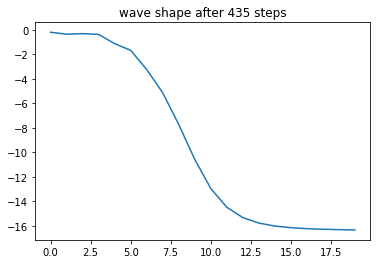

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_435/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_435/model_weights.tf
generator loss:2.054136271525574
-----------------------
total discriminator loss:0.3228634667335107
average true return:0.5014566618226539
-----------------------


 28%|██▊       | 436/1562 [26:38<2:09:29,  6.90s/it]

Training Step: 436
generator loss:2.0733076984956456
-----------------------
total discriminator loss:0.310225246780338
average true return:0.5019252219417787
-----------------------


 28%|██▊       | 437/1562 [26:41<1:45:48,  5.64s/it]

Training Step: 437
generator loss:2.057196335013204
-----------------------
total discriminator loss:0.29971415648057176
average true return:0.5005347677564274
-----------------------


 28%|██▊       | 438/1562 [26:44<1:28:18,  4.71s/it]

Training Step: 438
generator loss:2.0635447132343883
-----------------------
total discriminator loss:0.31185077503244707
average true return:0.5025889614635033
-----------------------


 28%|██▊       | 439/1562 [26:46<1:16:15,  4.07s/it]

Training Step: 439
generator loss:2.070874236271851
-----------------------
total discriminator loss:0.3147614738482897
average true return:0.5055039088920393
-----------------------


 28%|██▊       | 440/1562 [26:49<1:07:46,  3.62s/it]

Training Step: 440
event_types: [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.8538375
fid_score: 1786476.7162435404
rule_score: 0.0345


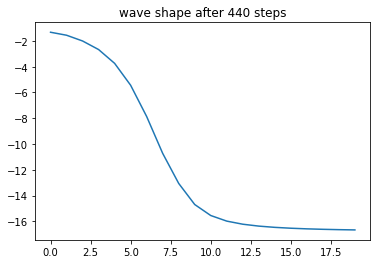

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_440/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_440/model_weights.tf
generator loss:2.072631367835503
-----------------------
total discriminator loss:0.3138468640585502
average true return:0.5036940018798016
-----------------------


 28%|██▊       | 441/1562 [27:04<2:10:07,  6.96s/it]

Training Step: 441
generator loss:2.0775261468669513
-----------------------
total discriminator loss:0.35108810729021733
average true return:0.5047718314446534
-----------------------


 28%|██▊       | 442/1562 [27:06<1:45:18,  5.64s/it]

Training Step: 442
generator loss:2.084727164229432
-----------------------
total discriminator loss:0.3123414181595048
average true return:0.5085502688676407
-----------------------


 28%|██▊       | 443/1562 [27:09<1:27:52,  4.71s/it]

Training Step: 443
generator loss:2.0731938846971234
-----------------------
total discriminator loss:0.3148162466441581
average true return:0.5043609972841319
-----------------------


 28%|██▊       | 444/1562 [27:11<1:15:51,  4.07s/it]

Training Step: 444
generator loss:2.092521473678275
-----------------------
total discriminator loss:0.29386718592462524
average true return:0.5051942928495583
-----------------------


 28%|██▊       | 445/1562 [27:14<1:07:35,  3.63s/it]

Training Step: 445
event_types: [1, 1, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.859175
fid_score: 1890857.2794431415
rule_score: 0.0295


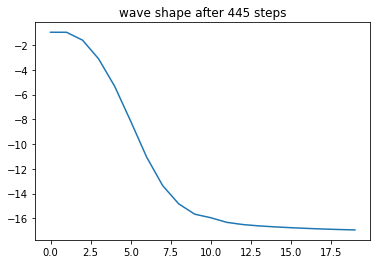

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_445/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_445/model_weights.tf
generator loss:2.1037191204827606
-----------------------
total discriminator loss:1.938911150248854
average true return:0.5053218973923865
-----------------------


 29%|██▊       | 446/1562 [27:29<2:09:27,  6.96s/it]

Training Step: 446
generator loss:2.076091574605191
-----------------------
total discriminator loss:0.316040929111028
average true return:0.5043323194322646
-----------------------


 29%|██▊       | 447/1562 [27:31<1:44:48,  5.64s/it]

Training Step: 447
generator loss:2.065551160992096
-----------------------
total discriminator loss:0.32148851710618265
average true return:0.5045075987269114
-----------------------


 29%|██▊       | 448/1562 [27:34<1:27:47,  4.73s/it]

Training Step: 448
generator loss:2.054087773108975
-----------------------
total discriminator loss:0.3072695278813644
average true return:0.5037468202049067
-----------------------


 29%|██▊       | 449/1562 [27:36<1:15:50,  4.09s/it]

Training Step: 449
generator loss:2.0496678858469135
-----------------------
total discriminator loss:0.3165707434119715
average true return:0.5029934848846376
-----------------------


 29%|██▉       | 450/1562 [27:39<1:07:17,  3.63s/it]

Training Step: 450
event_types: [1, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.8528625
fid_score: 1936324.4707795512
rule_score: 0.0365


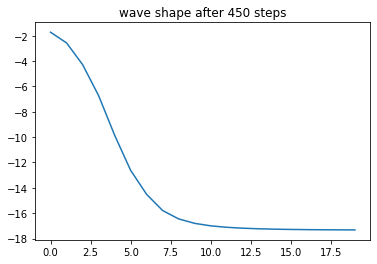

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_450/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_450/model_weights.tf
generator loss:2.039779180549868
-----------------------
total discriminator loss:0.3044178283014126
average true return:0.5041867051167498
-----------------------


 29%|██▉       | 451/1562 [27:54<2:08:54,  6.96s/it]

Training Step: 451
generator loss:2.033852885010685
-----------------------
total discriminator loss:0.33333956487625344
average true return:0.5021567915870904
-----------------------


 29%|██▉       | 452/1562 [27:56<1:44:26,  5.65s/it]

Training Step: 452
generator loss:2.0400153355513106
-----------------------
total discriminator loss:0.30347470822948636
average true return:0.5009601351239914
-----------------------


 29%|██▉       | 453/1562 [27:59<1:27:21,  4.73s/it]

Training Step: 453
generator loss:2.0288490048484182
-----------------------
total discriminator loss:0.29631171579917964
average true return:0.5033470199097035
-----------------------


 29%|██▉       | 454/1562 [28:01<1:15:23,  4.08s/it]

Training Step: 454
generator loss:2.014570217586546
-----------------------
total discriminator loss:1.8649875675302205
average true return:0.5031080160514532
-----------------------


 29%|██▉       | 455/1562 [28:04<1:07:01,  3.63s/it]

Training Step: 455
event_types: [3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 3, 1]
mad_score: 0.8499625
fid_score: 2013699.1732544138
rule_score: 0.03875


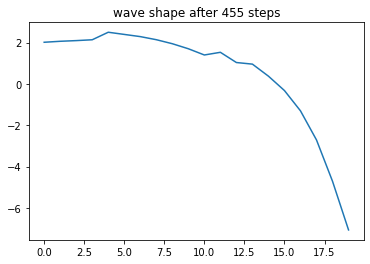

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_455/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_455/model_weights.tf
generator loss:1.9997036003320088
-----------------------
total discriminator loss:0.33596274286059136
average true return:0.5002826927761832
-----------------------


 29%|██▉       | 456/1562 [28:19<2:09:20,  7.02s/it]

Training Step: 456
generator loss:1.976374731551825
-----------------------
total discriminator loss:0.33249448420777195
average true return:0.5010457463014732
-----------------------


 29%|██▉       | 457/1562 [28:21<1:44:54,  5.70s/it]

Training Step: 457
generator loss:1.9610708155288274
-----------------------
total discriminator loss:0.31833195738976616
average true return:0.5008246576844504
-----------------------


 29%|██▉       | 458/1562 [28:24<1:27:26,  4.75s/it]

Training Step: 458
generator loss:1.9549184192446134
-----------------------
total discriminator loss:0.32647981789269426
average true return:0.5000732333857472
-----------------------


 29%|██▉       | 459/1562 [28:27<1:15:29,  4.11s/it]

Training Step: 459
generator loss:1.9539467072815826
-----------------------
total discriminator loss:0.3321276987109203
average true return:0.5007760599592517
-----------------------


 29%|██▉       | 460/1562 [28:29<1:07:06,  3.65s/it]

Training Step: 460
event_types: [1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 1, 2, 2, 2, 1, 2]
mad_score: 0.8518625
fid_score: 2096700.1510223104
rule_score: 0.03975


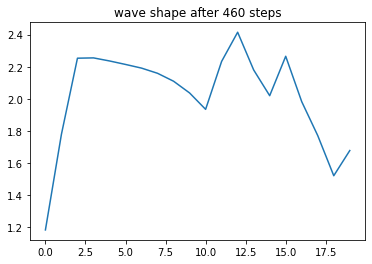

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_460/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_460/model_weights.tf
generator loss:1.9344795939744799
-----------------------
total discriminator loss:0.28654553319197346
average true return:0.5011383687509368
-----------------------


 30%|██▉       | 461/1562 [28:44<2:09:10,  7.04s/it]

Training Step: 461
generator loss:1.943516931537705
-----------------------
total discriminator loss:0.2971537306021927
average true return:0.4991011412895807
-----------------------


 30%|██▉       | 462/1562 [28:47<1:44:47,  5.72s/it]

Training Step: 462
generator loss:1.9265997026540163
-----------------------
total discriminator loss:0.30546806391064196
average true return:0.49888535071990525
-----------------------


 30%|██▉       | 463/1562 [28:49<1:27:23,  4.77s/it]

Training Step: 463
generator loss:1.91197885801081
-----------------------
total discriminator loss:0.2950932845915543
average true return:0.497976970107347
-----------------------


 30%|██▉       | 464/1562 [28:52<1:15:22,  4.12s/it]

Training Step: 464
generator loss:1.9352413646350173
-----------------------
total discriminator loss:0.3314916010809978
average true return:0.5006233843024396
-----------------------


 30%|██▉       | 465/1562 [28:54<1:06:48,  3.65s/it]

Training Step: 465
event_types: [3, 1, 2, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.8511375
fid_score: 2172519.3353897114
rule_score: 0.04075


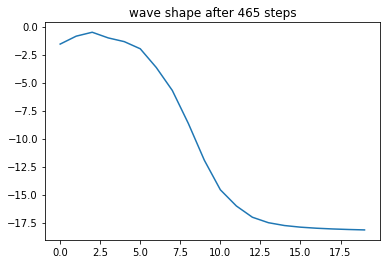

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_465/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_465/model_weights.tf
generator loss:1.9260440772127314
-----------------------
total discriminator loss:0.33274266700626687
average true return:0.5012186828291687
-----------------------


 30%|██▉       | 466/1562 [29:09<2:07:50,  7.00s/it]

Training Step: 466
generator loss:1.9268284724282867
-----------------------
total discriminator loss:1.7644387070038774
average true return:0.5047125606841496
-----------------------


 30%|██▉       | 467/1562 [29:12<1:43:37,  5.68s/it]

Training Step: 467
generator loss:1.9176759680423536
-----------------------
total discriminator loss:0.3396114380000238
average true return:0.5010600300326906
-----------------------


 30%|██▉       | 468/1562 [29:14<1:26:48,  4.76s/it]

Training Step: 468
generator loss:1.8973029364452594
-----------------------
total discriminator loss:0.32369373275414426
average true return:0.49915369814361066
-----------------------


 30%|███       | 469/1562 [29:17<1:14:41,  4.10s/it]

Training Step: 469
generator loss:1.8881149730986055
-----------------------
total discriminator loss:0.34082240892045584
average true return:0.5015763696133237
-----------------------


 30%|███       | 470/1562 [29:20<1:06:21,  3.65s/it]

Training Step: 470
event_types: [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.8391375
fid_score: 2216894.06639133
rule_score: 0.05


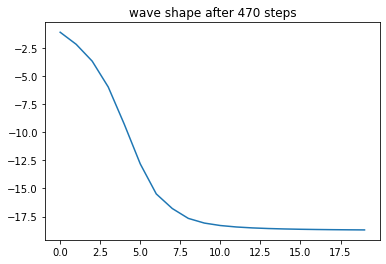

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_470/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_470/model_weights.tf
generator loss:1.8642919900081365
-----------------------
total discriminator loss:0.33888487624247254
average true return:0.5012278962444687
-----------------------


 30%|███       | 471/1562 [29:35<2:08:38,  7.08s/it]

Training Step: 471
generator loss:1.8427443689173626
-----------------------
total discriminator loss:1.7129078758035405
average true return:0.500008983786759
-----------------------


 30%|███       | 472/1562 [29:37<1:44:19,  5.74s/it]

Training Step: 472
generator loss:1.8368655437678618
-----------------------
total discriminator loss:0.3606766905494907
average true return:0.49984113733716257
-----------------------


 30%|███       | 473/1562 [29:40<1:27:11,  4.80s/it]

Training Step: 473
generator loss:1.8210401409688246
-----------------------
total discriminator loss:0.3397593858269273
average true return:0.5013143654931378
-----------------------


 30%|███       | 474/1562 [29:43<1:15:08,  4.14s/it]

Training Step: 474
generator loss:1.7905303757098494
-----------------------
total discriminator loss:1.627171295075466
average true return:0.4987655917453261
-----------------------


 30%|███       | 475/1562 [29:45<1:06:51,  3.69s/it]

Training Step: 475
event_types: [2, 1, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.834925
fid_score: 2300478.1426080232
rule_score: 0.0545


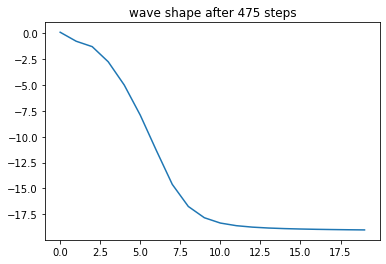

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_475/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_475/model_weights.tf
generator loss:1.7696103924527637
-----------------------
total discriminator loss:0.3582435643457447
average true return:0.4968548850012125
-----------------------


 30%|███       | 476/1562 [30:00<2:09:04,  7.13s/it]

Training Step: 476
generator loss:1.743758591262364
-----------------------
total discriminator loss:0.33575341429045247
average true return:0.4971756761816136
-----------------------


 31%|███       | 477/1562 [30:03<1:44:24,  5.77s/it]

Training Step: 477
generator loss:1.7050554781831806
-----------------------
total discriminator loss:0.3369743406763242
average true return:0.49769375137852667
-----------------------


 31%|███       | 478/1562 [30:06<1:26:58,  4.81s/it]

Training Step: 478
generator loss:1.7094093389492593
-----------------------
total discriminator loss:0.33537424660879445
average true return:0.49599751600686104
-----------------------


 31%|███       | 479/1562 [30:08<1:14:44,  4.14s/it]

Training Step: 479
generator loss:1.6871076137433891
-----------------------
total discriminator loss:0.34601568326613585
average true return:0.49510531682617087
-----------------------


 31%|███       | 480/1562 [30:11<1:06:28,  3.69s/it]

Training Step: 480
event_types: [1, 2, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
mad_score: 0.8333
fid_score: 2402094.042744716
rule_score: 0.06375


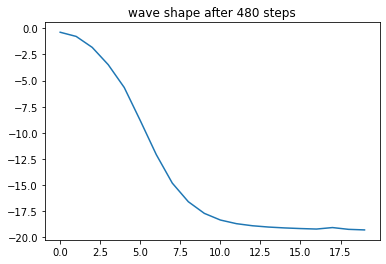

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_480/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_480/model_weights.tf
generator loss:1.65297075645663
-----------------------
total discriminator loss:0.35020414328876803
average true return:0.4970177239042758
-----------------------


 31%|███       | 481/1562 [30:26<2:07:37,  7.08s/it]

Training Step: 481
generator loss:1.6646171016601081
-----------------------
total discriminator loss:0.3674075866568453
average true return:0.4997378788911262
-----------------------


 31%|███       | 482/1562 [30:28<1:43:18,  5.74s/it]

Training Step: 482
generator loss:1.6575912122290926
-----------------------
total discriminator loss:0.35273625921400065
average true return:0.49877000918670583
-----------------------


 31%|███       | 483/1562 [30:31<1:26:18,  4.80s/it]

Training Step: 483
generator loss:1.6626112844153376
-----------------------
total discriminator loss:0.35712385717169937
average true return:0.500391788281576
-----------------------


 31%|███       | 484/1562 [30:34<1:14:29,  4.15s/it]

Training Step: 484
generator loss:1.66320817915719
-----------------------
total discriminator loss:0.3442515809853487
average true return:0.4959209763725831
-----------------------


 31%|███       | 485/1562 [30:36<1:06:14,  3.69s/it]

Training Step: 485
event_types: [0, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mad_score: 0.835475
fid_score: 2533332.56879536
rule_score: 0.06075


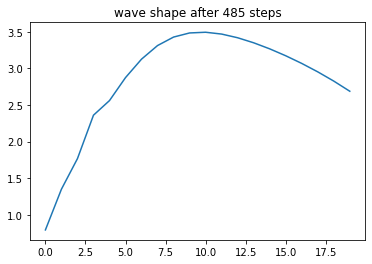

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_485/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_485/model_weights.tf
generator loss:1.6626671957217485
-----------------------
total discriminator loss:0.343349889823626
average true return:0.4966523389954689
-----------------------


 31%|███       | 486/1562 [30:52<2:08:48,  7.18s/it]

Training Step: 486
generator loss:1.6717068626011866
-----------------------
total discriminator loss:0.3638730844150705
average true return:0.49903784212988167
-----------------------


 31%|███       | 487/1562 [30:54<1:44:02,  5.81s/it]

Training Step: 487
generator loss:1.6892323483943252
-----------------------
total discriminator loss:0.3387107224819311
average true return:0.4963883370089201
-----------------------


 31%|███       | 488/1562 [30:57<1:26:55,  4.86s/it]

Training Step: 488
generator loss:1.6928622991997366
-----------------------
total discriminator loss:0.3420601549721617
average true return:0.49935583091467595
-----------------------


 31%|███▏      | 489/1562 [30:59<1:14:46,  4.18s/it]

Training Step: 489
generator loss:1.6968966538503278
-----------------------
total discriminator loss:0.3422240006542351
average true return:0.5010023422043584
-----------------------


 31%|███▏      | 490/1562 [31:02<1:06:18,  3.71s/it]

Training Step: 490
event_types: [2, 1, 1, 1, 3, 2, 1, 2, 2, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0]
mad_score: 0.8311125
fid_score: 2634468.5293885698
rule_score: 0.07175


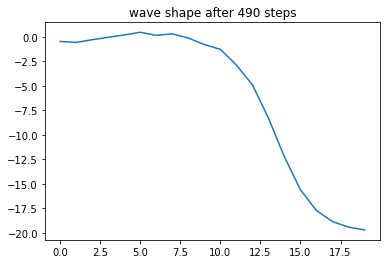

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/G_490/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12/D_490/model_weights.tf
generator loss:1.7017970503315012
-----------------------


 31%|███▏      | 490/1562 [31:16<1:08:24,  3.83s/it]


KeyboardInterrupt: 

In [152]:
for feature_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    print('Training Step:', step)
    
    if step % 5 == 0:
        _mad_score, _fid_score, _rule_score = track_training(step, G, train_model_save_path, verbose=True, plot=True)
        train_history['mad'].append(_mad_score)
        train_history['fid'].append(_fid_score)
        train_history['oracle'].append(_rule_score)
        
    # train the generator and critic
    for _ in range(_G_STEPS):
        gen_loss = train_generator_gumbel(G, D, BATCH_SIZE, T, verbose=True, optimizer=G_optimizer, temperature=0.9)
        train_history['gen_loss'].append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator_gumbel(event_type_batch, time_delta_batch, G, D, BATCH_SIZE, T,
                                                                verbose=True, optimizer=D_optimizer, 
                                                                label_smoothing=True, label_flipping=True)
        train_history['disc_loss'].append(disc_loss.numpy())
        train_history['avg_true_return'].append(ave_true_return.numpy())
                
    step += 1

Text(0.5, 0, 'Training steps')

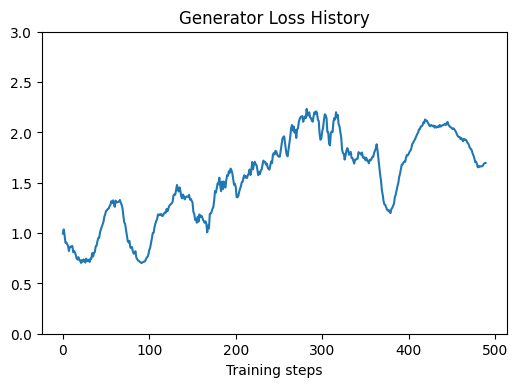

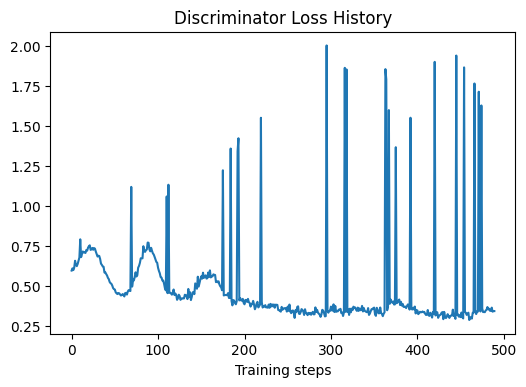

In [155]:
gen_loss_history = train_history['gen_loss']
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')
plt.ylim([0, 3])

disc_loss_history = train_history['disc_loss']
x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

Text(0.5, 0, 'Training steps')

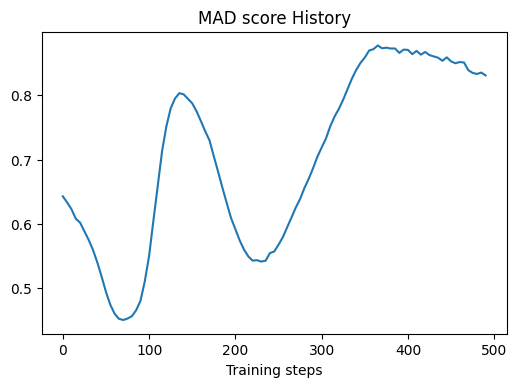

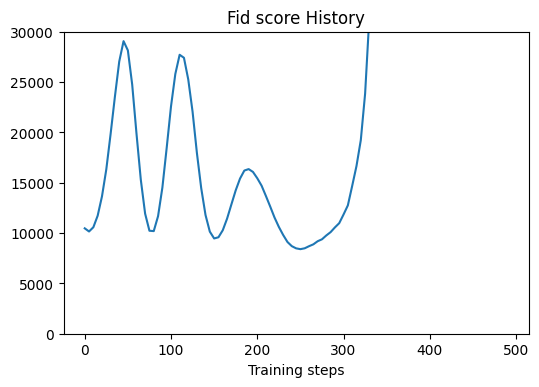

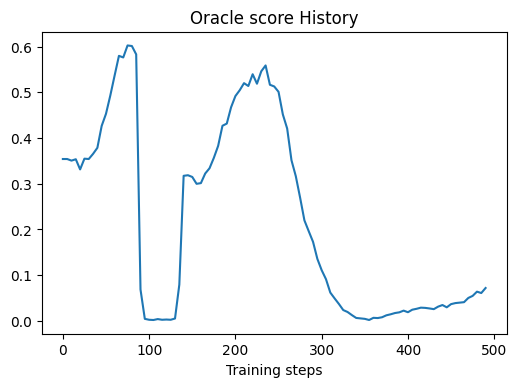

In [156]:
mad_history = train_history['mad']
x =  [i * 5 for i in range(len(mad_history))]
plt.figure(dpi=100)
plt.plot(x, mad_history)
plt.title('MAD score History')
plt.xlabel('Training steps')

fid_history = train_history['fid']
x =  [i * 5 for i in range(len(fid_history))]
plt.figure(dpi=100)
plt.plot(x, fid_history)
plt.title('Fid score History')
plt.xlabel('Training steps')
plt.ylim([0, 30000])

rule_history = train_history['oracle']
x =  [i * 5 for i in range(len(rule_history))]
plt.figure(dpi=100)
plt.plot(x, rule_history)
plt.title('Oracle score History')
plt.xlabel('Training steps')

## save train stats

In [169]:
train_metrics_history = {k : train_history[k] for k in ['mad', 'fid', 'oracle']}
train_losses_history = {k : train_history[k] for k in ['gen_loss', 'disc_loss', 'avg_true_return']}

In [170]:
df_train_metrics = pd.DataFrame(train_metrics_history)
df_train_metrics.index = pd.Index(range(0,step+1,5))

In [171]:
df_train_metrics

,mad,fid,oracle
0,0.642863,1.046944e+04,0.35400
5,0.633275,1.015545e+04,0.35400
10,0.622875,1.057871e+04,0.35050
15,0.608062,1.172512e+04,0.35350
20,0.601975,1.364831e+04,0.33125
...,...,...,...
470,0.839137,2.216894e+06,0.05000
475,0.834925,2.300478e+06,0.05450
480,0.833300,2.402094e+06,0.06375
485,0.835475,2.533333e+06,0.06075


In [172]:
df_train_metrics.iloc[np.argmax(df_train_metrics['oracle'])]

mad           0.452775
fid       10228.793356
oracle        0.602500
Name: 75, dtype: float64

In [173]:
for k, v in train_losses_history.items():
    print(k, len(v))

gen_loss 490
disc_loss 490
avg_true_return 490


In [175]:
df_train_losses = pd.DataFrame(train_losses_history)
df_train_losses.index = pd.Index(range(step))

In [177]:
df_train_metrics.to_csv(os.path.join(train_model_save_path, 'train_metrics.csv'), header=True, index=True)
df_train_losses.to_csv(os.path.join(train_model_save_path, 'train_losses.csv'), header=True, index=True)

In [178]:
train_model_save_path

'/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/train/2021-04-02-11-07-12'

## Compare between G0, G1 and G2

In [ ]:
G0_mcc = build_G_mcc(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G0_gs = build_G_gs(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

In [ ]:
_gen_seqs_et_mcc, _gen_seqs_ts_mcc, _, _, _ = generate_sequences_mcc(N_DATA, G0_mcc, BATCH_SIZE, T)

_gen_seqs_et_gs, _gen_seqs_ts_gs = generate_sequences_gumbel(N_DATA, G0_gs, BATCH_SIZE, T)

In [ ]:
def get_metrics(_gen_seqs_et, _gen_seqs_ts):
    # convert one-hot event types to indices; convert normalized timestamps to original
    _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
    _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
    _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))    

    _mad_score = calculate_MAD_score(_gen_seqs_et_ind)
    _smad_score = calculate_self_MAD_score(_gen_seqs_et_ind)
    _fid_score = calculate_FID_score(_gen_seqs_ts_ori)
    _rule_score = calculate_rule_score(_gen_seqs_for_rules)
    
    return {'mad' : _mad_score, 'fid' : _fid_score, 'oracle' : _rule_score, 'smad' : _smad_score}

In [ ]:
get_metrics(_gen_seqs_et_mcc, _gen_seqs_ts_mcc)

In [ ]:
get_metrics(_gen_seqs_et_gs, _gen_seqs_ts_gs )

In [ ]:
_gen_seqs_ts_mcc

In [ ]:
_gen_seqs_ts_ori1 = apply_mean_std(_gen_seqs_ts_mcc, GLOBAL_MEAN, GLOBAL_STD)
_gen_seqs_ts_ori2 = apply_mean_std(_gen_seqs_ts_gs, GLOBAL_MEAN, GLOBAL_STD)

In [ ]:
_gen_seqs_ts_ori1

In [ ]:
_gen_seqs_ts_ori2

In [ ]:
from matplotlib import pyplot as plt
